# LSTM using glove by Sky
## Grid search each settings version 2
## Unified：
1. 字母小寫
2. 刪除網址
3. 移除標點符號(所有標點符號都要刪除)
4. 移除非英文字母
5. 要做class_weight
## To be ensured：
1. 是否要使用stop_words(如果使用記得保留no not never)
2. pooling方法(hidden state pooling, max pooling, mean pooling)
3. @人名 統一改成 username 
4. 因covid和coronavir不在Glove的預訓練資料集中，所以是否要將這兩個字改成Glove中有的字像是virus
### 2025/5/19 11:32 pm

## 步驟1：載入套件

In [10]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [11]:
# 檢查 GPU 可用性並設置設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備：{device}")
print(f"PyTorch 版本：{torch.__version__}")
print(f"GPU 可用：{torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 名稱：{torch.cuda.get_device_name(0)}")

使用設備：cuda
PyTorch 版本：2.5.1+cu121
GPU 可用：True
GPU 名稱：NVIDIA GeForce RTX 4060 Laptop GPU


In [12]:
# 步驟1：載入套件
import pandas as pd  # 用於資料讀取與處理
import numpy as np   # 用於數值運算
import torch         # PyTorch主套件
import torch.nn as nn  # PyTorch神經網路模組
import torch.optim as optim  # PyTorch優化器
from torch.utils.data import Dataset, DataLoader  # PyTorch資料集與資料加載器
import nltk  # 用於分詞與停用詞處理
from nltk.corpus import stopwords  # 停用詞
from nltk.tokenize import TweetTokenizer  # 改用 TweetTokenizer
import re  # 正則表達式，用於去除URL
import string  # 處理標點符號
from collections import Counter
from itertools import product
from torch.nn.init import uniform_  # 用於隨機初始化OOV詞的嵌入向量
import matplotlib.pyplot as plt  # 用於視覺化（已有）
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# 下載nltk的停用詞與分詞資源（只需執行一次）
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 步驟2：讀取資料

In [13]:
# 初始化 TweetTokenizer 和停用詞
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}

# 讀取訓練與測試資料
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

# 顯示前幾筆資料，確認欄位與內容
print("訓練資料前5筆：")
print(train_df.head())

print("\n測試資料前5筆：")
print(test_df.head())

訓練資料前5筆：
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  

測試資料前5筆：
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-0

## 步驟3：資料清理

In [14]:
# === 需要確認/修改的資料前處理步驟（中文說明） ===
# 1. 字母小寫：TweetTokenizer 已設定 preserve_case=False，確保所有文字轉為小寫，無需修改。
# 2. 刪除網址：以下正則表達式已正確刪除網址，無需修改。
# 3. 移除標點符號：當前程式碼僅移除部分標點符號，需修改以移除所有標點符號。
# 4. 移除非英文字母：需新增程式碼以移除非英文字母（僅保留 a-z 和空格）。
# 5. class_weight：當前程式碼已使用 compute_class_weight，無需修改。
# 6. @人名改為 username：需新增程式碼將 @ 開頭的人名替換為 "username"。
# 7. covid/coronavirus 改為 virus：需新增程式碼將 "covid" 和 "coronavirus" 替換為 "virus"。
# 8. stop_words：需新增選項以選擇是否使用 stop_words，並保留 "no"、"not"、"never"。

# 更新 clean_text 函數
def clean_text(text, use_stopwords=False, replace_username=True, replace_covid='none'):
    # 1. 處理 @username
    if replace_username:
        text = re.sub(r'@\w+', 'username', text)
    # 2. 處理 covid/coronavirus
    if replace_covid == 'virus':
        text = re.sub(r'\bcovid\b|\bcoronavirus\b', 'virus', text, flags=re.IGNORECASE)
    elif replace_covid == 'pandemic':
        text = re.sub(r'\bcovid\b|\bcoronavirus\b', 'pandemic', text, flags=re.IGNORECASE)
    # 3. 移除 URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    # 4. 轉小寫
    text = text.lower()
    # 5. 移除所有標點符號
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 6. 分詞
    words = tokenizer.tokenize(text)
    # 7. 移除停用詞（若啟用）
    if use_stopwords:
        words = [word for word in words if word not in stop_words]
    # 8. 移除非英文字母
    words = [word for word in words if word.isalpha()]
    
    return words

清理後的訓練資料前 5 筆：
                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                        clean_tokens  token_length  
0           [username, username, username, and, and]             5  
1  [advice, talk, to, your, neighbours, family, t...            38  
2  [coronavirus, australia, woolworths, to, give,...            13  
3  [my, food, stock, is, not, the, only, one, whi...            41  
4  [me, ready, to, go, at, supermarket, during, t...            39  

清理後的測試資料前 5 筆：
                                       OriginalTweet  \
0  TRENDING: New Yorkers encounter empty supermar...   
1  When I couldn't find hand sanitizer at Fred Me...   
2  Find out how you can protect yourself and love.

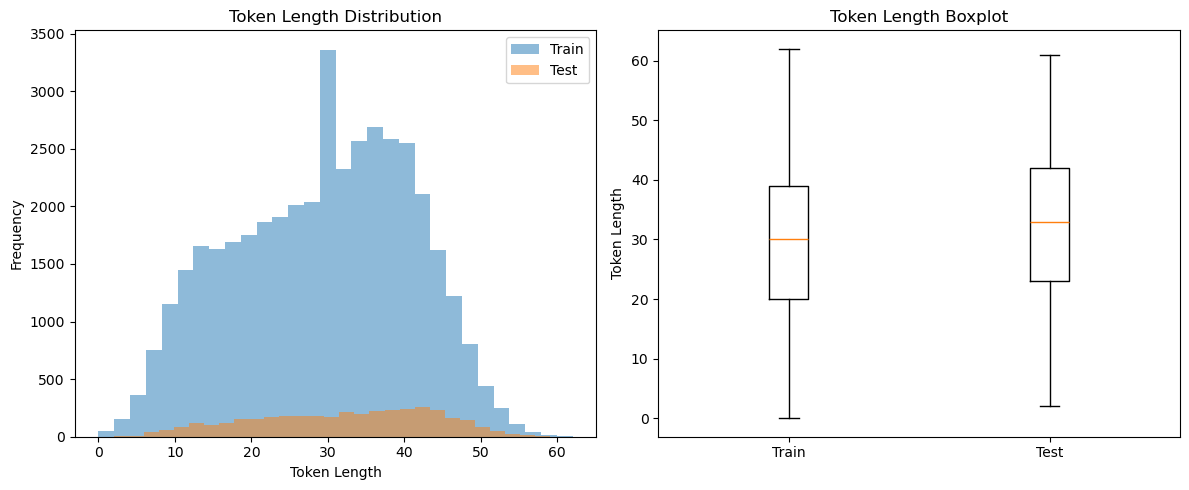


訓練集 token 長度統計：
count    41157.000000
mean        29.341910
std         11.630557
min          0.000000
25%         20.000000
50%         30.000000
75%         39.000000
max         62.000000
Name: token_length, dtype: float64

測試集 token 長度統計：
count    3798.000000
mean       32.038178
std        11.861498
min         2.000000
25%        23.000000
50%        33.000000
75%        42.000000
max        61.000000
Name: token_length, dtype: float64


In [15]:
# 清理訓練與測試資料
train_df['clean_tokens'] = train_df['OriginalTweet'].apply(lambda x: clean_text(x, use_stopwords=False))
test_df['clean_tokens'] = test_df['OriginalTweet'].apply(lambda x: clean_text(x, use_stopwords=False))

# 計算 token 長度
train_df['token_length'] = train_df['clean_tokens'].apply(len)
test_df['token_length'] = test_df['clean_tokens'].apply(len)

# 顯示清理後的資料
print("清理後的訓練資料前 5 筆：")
print(train_df[['OriginalTweet', 'clean_tokens', 'token_length']].head())
print("\n清理後的測試資料前 5 筆：")
print(test_df[['OriginalTweet', 'clean_tokens', 'token_length']].head())

# 視覺化 token 長度分佈
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_df['token_length'], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['token_length'], bins=30, alpha=0.5, label='Test')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.subplot(1, 2, 2)
plt.boxplot([train_df['token_length'], test_df['token_length']], labels=['Train', 'Test'])
plt.ylabel('Token Length')
plt.title('Token Length Boxplot')
plt.tight_layout()
plt.show()

# 顯示 token 長度統計
print("\n訓練集 token 長度統計：")
print(train_df['token_length'].describe())
print("\n測試集 token 長度統計：")
print(test_df['token_length'].describe())

## 步驟5：修改模型以支援不同pooling方法

In [16]:
# 更新 BiLSTMClassifier
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pooling_method):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 雙向 LSTM，隱藏層維度乘 2
        self.dropout = nn.Dropout(dropout)
        self.pooling_method = pooling_method
    
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))  # [batch_size, seq_len, embedding_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim * 2]
        
        # Pooling
        if self.pooling_method == 'hidden_state':
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))  # [batch_size, hidden_dim * 2]
            output = hidden
        elif self.pooling_method == 'max_pooling':
            output = torch.max(lstm_out, dim=1)[0]  # [batch_size, hidden_dim * 2]
        elif self.pooling_method == 'mean_pooling':
            output = torch.mean(lstm_out, dim=1)  # [batch_size, hidden_dim * 2]
        else:
            raise ValueError("Invalid pooling method. Choose 'hidden_state', 'max_pooling', or 'mean_pooling'.")
        
        return self.fc(output)  # [batch_size, output_dim]

## 步驟5.5：超參數調優

In [17]:
'''
# 匯入必要的套件
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

# 檢查設備
device = torch.device("cuda")
print(f"使用設備: {device}")

# Define BiLSTMClassifier class (copied from your Step 6)
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(BiLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_tensor.shape
        # Embedding layer, using pre-trained word vectors, allow fine-tuning
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim*2)
        # Take the last output of the bidirectional LSTM
        out_forward = lstm_out[:, -1, :self.lstm.hidden_size]
        out_backward = lstm_out[:, 0, self.lstm.hidden_size:]
        out = torch.cat((out_forward, out_backward), dim=1)  # (batch_size, hidden_dim*2)
        out = self.bn(out)
        out = self.dropout(out)
        logits = self.fc(out)  # (batch_size, output_dim)
        return logits


# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'hidden_dim': [128, 256],
    'dropout': [0.3, 0.5],
    'batch_size': [32, 64],
    'num_layers': [1, 4]  # Added to match your BiLSTMClassifier
}

# Function to train and evaluate model
def train_and_evaluate(params, train_loader, val_loader, embedding_tensor, output_dim, device, class_weights):
    model = BiLSTMClassifier(
        embedding_tensor=embedding_tensor,
        hidden_dim=params['hidden_dim'],
        output_dim=output_dim,
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    best_val_acc = 0
    for epoch in range(5):  # Reduced epochs for tuning
        model.train()
        total_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} 訓練中", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = val_correct / total
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    return best_val_acc

# Create a validation set by splitting train_dataset (optional)
from torch.utils.data import SubsetRandomSampler
import numpy as np

# Define validation split
val_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_size = int(val_split * dataset_size)
train_indices, val_indices = indices[val_size:], indices[:val_size]

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders with dynamic batch_size
best_acc = 0
best_params = None
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float).to(device)
output_dim = 5  # From your notebook (5 sentiment classes)

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    # Create data loaders with the current batch_size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=val_sampler)
    val_acc = train_and_evaluate(
        params, 
        train_loader, 
        val_loader, 
        embedding_tensor, 
        output_dim, 
        device, 
        class_weights
    )
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params

print(f"Best parameters: {best_params}, Validation Accuracy: {best_acc}")

# Update BATCH_SIZE, HIDDEN_DIM, DROPOUT, NUM_LAYERS with best parameters
BATCH_SIZE = best_params['batch_size']
HIDDEN_DIM = best_params['hidden_dim']
DROPOUT = best_params['dropout']
NUM_LAYERS = best_params['num_layers']
print(f"Updated parameters: BATCH_SIZE={BATCH_SIZE}, HIDDEN_DIM={HIDDEN_DIM}, DROPOUT={DROPOUT}, NUM_LAYERS={NUM_LAYERS}")
'''

'\n# 匯入必要的套件\nimport matplotlib.pyplot as plt\nfrom tqdm import tqdm\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.optim.lr_scheduler import ReduceLROnPlateau\nfrom sklearn.model_selection import ParameterGrid\n\n# 檢查設備\ndevice = torch.device("cuda")\nprint(f"使用設備: {device}")\n\n# Define BiLSTMClassifier class (copied from your Step 6)\nclass BiLSTMClassifier(nn.Module):\n    def __init__(self, embedding_tensor, hidden_dim, output_dim, num_layers=2, dropout=0.2):\n        super(BiLSTMClassifier, self).__init__()\n        vocab_size, embedding_dim = embedding_tensor.shape\n        # Embedding layer, using pre-trained word vectors, allow fine-tuning\n        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)\n        # Bidirectional LSTM\n        self.lstm = nn.LSTM(\n            input_size=embedding_dim,\n            hidden_size=hidden_dim,\n            num_layers=num_layers,\n            batch_first=True,\n            bidirecti

## 步驟5.6：網格搜索與最佳組合選擇

In [18]:
# 定義詞彙表構建函數
def build_vocab(token_lists):
    all_tokens = [token for tokens in token_lists for token in tokens]
    token_counts = Counter(all_tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    vocab.update({token: idx + 2 for idx, (token, _) in enumerate(token_counts.items())})
    return vocab

# 定義資料集類
class TweetDataset(Dataset):
    def __init__(self, df, vocab, max_length):
        self.texts = df['clean_tokens']
        self.labels = df['Sentiment'].map({
            'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive': 3,
            'Extremely Positive': 4
        }).values
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts.iloc[idx]
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
        else:
            indices += [self.vocab['<PAD>']] * (self.max_length - len(indices))
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# 定義載入Glove嵌入函數
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    embeddings = np.zeros((len(vocab), embedding_dim))
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in vocab:
                embeddings[vocab[word]] = np.array(values[1:], dtype=np.float32)
    embeddings[vocab['<PAD>']] = np.zeros(embedding_dim)
    embeddings[vocab['<UNK>']] = np.random.uniform(-0.25, 0.25, embedding_dim)
    return embeddings

In [9]:
# 網格搜索
batch_sizes = [64, 128, 256]
max_lengths = [30, 50]
pooling_methods = ['hidden_state', 'max_pooling', 'mean_pooling']
use_stopwords_options = [True, False]
replace_username_options = [True, False]
replace_covid_options = ['none', 'virus', 'pandemic']

results = []
best_val_acc = 0
best_params = None
best_train_losses = None
best_val_losses = None
best_val_accuracies = None

total_combinations = len(batch_sizes) * len(max_lengths) * len(pooling_methods) * \
                     len(use_stopwords_options) * len(replace_username_options) * len(replace_covid_options)
current_combination = 0

for batch_size, max_length, pooling_method, use_stopwords, replace_username, replace_covid in product(
    batch_sizes, max_lengths, pooling_methods, use_stopwords_options, replace_username_options, replace_covid_options
):
    current_combination += 1
    print(f"\n試驗 {current_combination}/{total_combinations}：batch_size={batch_size}, max_length={max_length}, "
          f"pooling_method={pooling_method}, use_stopwords={use_stopwords}, replace_username={replace_username}, "
          f"replace_covid={replace_covid}")
    
    # 清理資料
    train_df['clean_tokens'] = train_df['OriginalTweet'].apply(
        lambda x: clean_text(x, use_stopwords=use_stopwords, replace_username=replace_username, replace_covid=replace_covid)
    )
    test_df['clean_tokens'] = test_df['OriginalTweet'].apply(
        lambda x: clean_text(x, use_stopwords=use_stopwords, replace_username=replace_username, replace_covid=replace_covid)
    )
    
    # 檢查空序列並記錄
    empty_train = train_df[train_df['clean_tokens'].apply(len) == 0]
    if not empty_train.empty:
        print(f"警告：訓練集有 {len(empty_train)} 筆空序列，移除中...")
        print("空序列範例：")
        print(empty_train[['OriginalTweet', 'clean_tokens']].head())
        train_df = train_df[train_df['clean_tokens'].apply(len) > 0]
    
    # 構建詞彙表和資料集
    vocab = build_vocab(train_df['clean_tokens'])
    train_dataset = TweetDataset(train_df, vocab, max_length=max_length)
    test_dataset = TweetDataset(test_df, vocab, max_length=max_length)
    
    # 建立 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)
    
    # 初始化模型
    model = BiLSTMClassifier(
        vocab_size=len(vocab),
        embedding_dim=100,
        hidden_dim=256,
        output_dim=5,
        n_layers=4,
        dropout=0.2,
        pooling_method=pooling_method
    ).to(device)
    
    # 載入 GloVe 嵌入
    glove_embeddings = load_glove_embeddings(r'C:\Users\skych\glove.twitter.27B\glove.twitter.27B.100d.txt', vocab)
    model.embedding.weight.data.copy_(torch.tensor(glove_embeddings, device=device))
    model.embedding.weight.requires_grad = False
    
    # 設定優化器和損失函數
    optimizer = optim.Adam(model.parameters())
    class_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(train_df['Sentiment']), y=train_df['Sentiment']),
        device=device
    ).float()
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    
    # 訓練模型
    num_epochs = 10
    patience = 3
    current_val_acc = 0
    counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        
        # 驗證
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader:
                texts, labels = batch
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                _, predicted = torch.max(predictions, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(correct / total)
        
        # 顯示進度
        print(f"Epoch {epoch+1}/{num_epochs} 完成：")
        print(f"  訓練損失: {train_losses[-1]:.4f}")
        print(f"  驗證損失: {val_losses[-1]:.4f}")
        print(f"  驗證準確率: {val_accuracies[-1]:.4f}")
        
        # 提前停止
        if val_accuracies[-1] > current_val_acc:
            current_val_acc = val_accuracies[-1]
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"提前停止於 epoch {epoch+1}")
            break
    
    # 記錄結果
    results.append({
        'batch_size': batch_size,
        'max_length': max_length,
        'pooling_method': pooling_method,
        'use_stopwords': use_stopwords,
        'replace_username': replace_username,
        'replace_covid': replace_covid,
        'best_val_accuracy': current_val_acc
    })
    
    # 更新最佳參數
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_params = {
            'batch_size': batch_size,
            'max_length': max_length,
            'pooling_method': pooling_method,
            'use_stopwords': use_stopwords,
            'replace_username': replace_username,
            'replace_covid': replace_covid
        }
        best_train_losses = train_losses
        best_val_losses = val_losses
        best_val_accuracies = val_accuracies
    
    # 釋放 GPU 記憶體
    torch.cuda.empty_cache()

# 顯示並分析結果
results_df = pd.DataFrame(results)
print("\nGrid Search 結果：")
print(results_df)
results_df.to_csv('grid_search_results_0521.csv', index=False)

# 報告最佳參數
print("\n最佳參數組合：")
print(f"batch_size: {best_params['batch_size']}")
print(f"max_length: {best_params['max_length']}")
print(f"pooling_method: {best_params['pooling_method']}")
print(f"use_stopwords: {best_params['use_stopwords']}")
print(f"replace_username: {best_params['replace_username']}")
print(f"replace_covid: {best_params['replace_covid']}")
print(f"最佳驗證準確率: {best_val_acc:.4f}")


試驗 1/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=none
警告：訓練集有 16 筆空序列，移除中...
空序列範例：
                                          OriginalTweet clean_tokens
16    ????? ????? ????? ????? ??\r\r\n?????? ????? ?...           []
583   #????_???_?????? ???? ???????..? ?? ?????? ?? ...           []
2385  ?? ??? ???. ????????-????? ?????? 3 ??????????...           []
5214  ???? ???????? ??????????? - ???????? ?????????...           []
8841  ????? ? ????? ?? ?????: ??????????? ??? ?? ???...           []


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 50.66it/s]


Epoch 1/10 完成：
  訓練損失: 1.2136
  驗證損失: 1.0738
  驗證準確率: 0.5116


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 52.56it/s]


Epoch 2/10 完成：
  訓練損失: 1.0260
  驗證損失: 0.9370
  驗證準確率: 0.6185


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 54.90it/s]


Epoch 3/10 完成：
  訓練損失: 0.8916
  驗證損失: 0.8374
  驗證準確率: 0.6709


Epoch 4/10: 100%|██████████| 643/643 [00:12<00:00, 53.07it/s]


Epoch 4/10 完成：
  訓練損失: 0.7951
  驗證損失: 0.7698
  驗證準確率: 0.7046


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 52.12it/s]


Epoch 5/10 完成：
  訓練損失: 0.7200
  驗證損失: 0.7448
  驗證準確率: 0.7164


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 52.21it/s]


Epoch 6/10 完成：
  訓練損失: 0.6713
  驗證損失: 0.7080
  驗證準確率: 0.7401


Epoch 7/10: 100%|██████████| 643/643 [00:22<00:00, 27.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.6217
  驗證損失: 0.6881
  驗證準確率: 0.7514


Epoch 8/10: 100%|██████████| 643/643 [00:24<00:00, 26.68it/s]


Epoch 8/10 完成：
  訓練損失: 0.5835
  驗證損失: 0.7027
  驗證準確率: 0.7491


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.39it/s]


Epoch 9/10 完成：
  訓練損失: 0.5421
  驗證損失: 0.6876
  驗證準確率: 0.7496


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 35.80it/s]


Epoch 10/10 完成：
  訓練損失: 0.5111
  驗證損失: 0.7048
  驗證準確率: 0.7475
提前停止於 epoch 10

試驗 2/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:23<00:00, 27.78it/s]


Epoch 1/10 完成：
  訓練損失: 1.2300
  驗證損失: 1.0582
  驗證準確率: 0.5545


Epoch 2/10: 100%|██████████| 643/643 [00:23<00:00, 27.90it/s]


Epoch 2/10 完成：
  訓練損失: 1.0199
  驗證損失: 0.9622
  驗證準確率: 0.6082


Epoch 3/10: 100%|██████████| 643/643 [00:24<00:00, 26.48it/s]


Epoch 3/10 完成：
  訓練損失: 0.8896
  驗證損失: 0.8401
  驗證準確率: 0.6730


Epoch 4/10: 100%|██████████| 643/643 [00:22<00:00, 28.34it/s]


Epoch 4/10 完成：
  訓練損失: 0.7980
  驗證損失: 0.7869
  驗證準確率: 0.7101


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 29.45it/s]


Epoch 5/10 完成：
  訓練損失: 0.7279
  驗證損失: 0.7494
  驗證準確率: 0.7209


Epoch 6/10: 100%|██████████| 643/643 [00:22<00:00, 28.90it/s]


Epoch 6/10 完成：
  訓練損失: 0.6754
  驗證損失: 0.7177
  驗證準確率: 0.7267


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 49.92it/s]


Epoch 7/10 完成：
  訓練損失: 0.6273
  驗證損失: 0.7218
  驗證準確率: 0.7354


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 51.98it/s]


Epoch 8/10 完成：
  訓練損失: 0.5839
  驗證損失: 0.7010
  驗證準確率: 0.7475


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 53.48it/s]


Epoch 9/10 完成：
  訓練損失: 0.5504
  驗證損失: 0.6856
  驗證準確率: 0.7528


Epoch 10/10: 100%|██████████| 643/643 [00:12<00:00, 53.36it/s]


Epoch 10/10 完成：
  訓練損失: 0.5108
  驗證損失: 0.6965
  驗證準確率: 0.7517

試驗 3/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 34.69it/s]


Epoch 1/10 完成：
  訓練損失: 1.2265
  驗證損失: 1.0853
  驗證準確率: 0.5229


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 51.76it/s]


Epoch 2/10 完成：
  訓練損失: 1.0304
  驗證損失: 0.9458
  驗證準確率: 0.6111


Epoch 3/10: 100%|██████████| 643/643 [00:12<00:00, 50.65it/s]


Epoch 3/10 完成：
  訓練損失: 0.8906
  驗證損失: 0.8411
  驗證準確率: 0.6656


Epoch 4/10: 100%|██████████| 643/643 [00:21<00:00, 29.76it/s]


Epoch 4/10 完成：
  訓練損失: 0.7937
  驗證損失: 0.7911
  驗證準確率: 0.6956


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 29.39it/s]


Epoch 5/10 完成：
  訓練損失: 0.7217
  驗證損失: 0.7578
  驗證準確率: 0.6964


Epoch 6/10: 100%|██████████| 643/643 [00:21<00:00, 29.58it/s]


Epoch 6/10 完成：
  訓練損失: 0.6652
  驗證損失: 0.7094
  驗證準確率: 0.7278


Epoch 7/10: 100%|██████████| 643/643 [00:22<00:00, 29.18it/s]


Epoch 7/10 完成：
  訓練損失: 0.6211
  驗證損失: 0.7621
  驗證準確率: 0.7330


Epoch 8/10: 100%|██████████| 643/643 [00:23<00:00, 27.78it/s]


Epoch 8/10 完成：
  訓練損失: 0.5824
  驗證損失: 0.7051
  驗證準確率: 0.7425


Epoch 9/10: 100%|██████████| 643/643 [00:22<00:00, 27.97it/s]


Epoch 9/10 完成：
  訓練損失: 0.5427
  驗證損失: 0.6900
  驗證準確率: 0.7475


Epoch 10/10: 100%|██████████| 643/643 [00:24<00:00, 26.11it/s]


Epoch 10/10 完成：
  訓練損失: 0.5033
  驗證損失: 0.6886
  驗證準確率: 0.7559

試驗 4/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:20<00:00, 30.71it/s]


Epoch 1/10 完成：
  訓練損失: 1.2114
  驗證損失: 1.0366
  驗證準確率: 0.5679


Epoch 2/10: 100%|██████████| 643/643 [00:21<00:00, 29.80it/s]


Epoch 2/10 完成：
  訓練損失: 1.0179
  驗證損失: 0.9427
  驗證準確率: 0.6240


Epoch 3/10: 100%|██████████| 643/643 [00:21<00:00, 29.87it/s]


Epoch 3/10 完成：
  訓練損失: 0.8936
  驗證損失: 0.8555
  驗證準確率: 0.6577


Epoch 4/10: 100%|██████████| 643/643 [00:23<00:00, 27.19it/s]


Epoch 4/10 完成：
  訓練損失: 0.7967
  驗證損失: 0.8110
  驗證準確率: 0.6906


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 29.72it/s]


Epoch 5/10 完成：
  訓練損失: 0.7316
  驗證損失: 0.7473
  驗證準確率: 0.7120


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 53.26it/s]


Epoch 6/10 完成：
  訓練損失: 0.6759
  驗證損失: 0.7204
  驗證準確率: 0.7306


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 34.94it/s]


Epoch 7/10 完成：
  訓練損失: 0.6334
  驗證損失: 0.6897
  驗證準確率: 0.7417


Epoch 8/10: 100%|██████████| 643/643 [00:23<00:00, 26.80it/s]


Epoch 8/10 完成：
  訓練損失: 0.5904
  驗證損失: 0.6881
  驗證準確率: 0.7420


Epoch 9/10: 100%|██████████| 643/643 [00:15<00:00, 41.70it/s]


Epoch 9/10 完成：
  訓練損失: 0.5527
  驗證損失: 0.6971
  驗證準確率: 0.7483


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.33it/s]


Epoch 10/10 完成：
  訓練損失: 0.5164
  驗證損失: 0.6976
  驗證準確率: 0.7472

試驗 5/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 55.80it/s]


Epoch 1/10 完成：
  訓練損失: 1.2357
  驗證損失: 1.0925
  驗證準確率: 0.5340


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 56.32it/s]


Epoch 2/10 完成：
  訓練損失: 1.0420
  驗證損失: 0.9695
  驗證準確率: 0.6114


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 54.66it/s]


Epoch 3/10 完成：
  訓練損失: 0.9166
  驗證損失: 0.8678
  驗證準確率: 0.6669


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 56.09it/s]


Epoch 4/10 完成：
  訓練損失: 0.8109
  驗證損失: 0.7926
  驗證準確率: 0.6869


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.74it/s]


Epoch 5/10 完成：
  訓練損失: 0.7429
  驗證損失: 0.7469
  驗證準確率: 0.7154


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 50.92it/s]


Epoch 6/10 完成：
  訓練損失: 0.6830
  驗證損失: 0.7245
  驗證準確率: 0.7146


Epoch 7/10: 100%|██████████| 643/643 [00:13<00:00, 46.56it/s]


Epoch 7/10 完成：
  訓練損失: 0.6339
  驗證損失: 0.7082
  驗證準確率: 0.7407


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 54.54it/s]


Epoch 8/10 完成：
  訓練損失: 0.5957
  驗證損失: 0.6827
  驗證準確率: 0.7407


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 55.02it/s]


Epoch 9/10 完成：
  訓練損失: 0.5534
  驗證損失: 0.6809
  驗證準確率: 0.7501


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 55.20it/s]


Epoch 10/10 完成：
  訓練損失: 0.5209
  驗證損失: 0.6886
  驗證準確率: 0.7525

試驗 6/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:16<00:00, 39.97it/s]


Epoch 1/10 完成：
  訓練損失: 1.2201
  驗證損失: 1.1121
  驗證準確率: 0.5068


Epoch 2/10: 100%|██████████| 643/643 [00:14<00:00, 43.88it/s]


Epoch 2/10 完成：
  訓練損失: 1.0304
  驗證損失: 0.9791
  驗證準確率: 0.6035


Epoch 3/10: 100%|██████████| 643/643 [00:14<00:00, 44.35it/s]


Epoch 3/10 完成：
  訓練損失: 0.8963
  驗證損失: 0.8477
  驗證準確率: 0.6601


Epoch 4/10: 100%|██████████| 643/643 [00:14<00:00, 43.83it/s]


Epoch 4/10 完成：
  訓練損失: 0.7953
  驗證損失: 0.7872
  驗證準確率: 0.6872


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 52.98it/s]


Epoch 5/10 完成：
  訓練損失: 0.7341
  驗證損失: 0.7554
  驗證準確率: 0.7193


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.88it/s]


Epoch 6/10 完成：
  訓練損失: 0.6775
  驗證損失: 0.7232
  驗證準確率: 0.7349


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 49.86it/s]


Epoch 7/10 完成：
  訓練損失: 0.6337
  驗證損失: 0.6996
  驗證準確率: 0.7449


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 53.86it/s]


Epoch 8/10 完成：
  訓練損失: 0.5917
  驗證損失: 0.7230
  驗證準確率: 0.7443


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 53.48it/s]


Epoch 9/10 完成：
  訓練損失: 0.5554
  驗證損失: 0.6883
  驗證準確率: 0.7446


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.46it/s]


Epoch 10/10 完成：
  訓練損失: 0.5144
  驗證損失: 0.7092
  驗證準確率: 0.7407
提前停止於 epoch 10

試驗 7/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 54.02it/s]


Epoch 1/10 完成：
  訓練損失: 1.2873
  驗證損失: 1.1820
  驗證準確率: 0.4879


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 54.44it/s]


Epoch 2/10 完成：
  訓練損失: 1.1214
  驗證損失: 1.1086
  驗證準確率: 0.5358


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 54.82it/s]


Epoch 3/10 完成：
  訓練損失: 1.0276
  驗證損失: 1.0167
  驗證準確率: 0.5742


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 53.72it/s]


Epoch 4/10 完成：
  訓練損失: 0.9350
  驗證損失: 0.9900
  驗證準確率: 0.6172


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 56.75it/s]


Epoch 5/10 完成：
  訓練損失: 0.8720
  驗證損失: 0.9237
  驗證準確率: 0.6388


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 37.41it/s]


Epoch 6/10 完成：
  訓練損失: 0.8249
  驗證損失: 0.9111
  驗證準確率: 0.6309


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 54.37it/s]


Epoch 7/10 完成：
  訓練損失: 0.7806
  驗證損失: 0.9118
  驗證準確率: 0.6464


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 52.55it/s]


Epoch 8/10 完成：
  訓練損失: 0.7482
  驗證損失: 0.8935
  驗證準確率: 0.6553


Epoch 9/10: 100%|██████████| 643/643 [00:15<00:00, 41.19it/s]


Epoch 9/10 完成：
  訓練損失: 0.7149
  驗證損失: 0.8827
  驗證準確率: 0.6638


Epoch 10/10: 100%|██████████| 643/643 [00:14<00:00, 44.04it/s]


Epoch 10/10 完成：
  訓練損失: 0.6805
  驗證損失: 0.8856
  驗證準確率: 0.6611

試驗 8/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:15<00:00, 41.16it/s]


Epoch 1/10 完成：
  訓練損失: 1.2922
  驗證損失: 1.1979
  驗證準確率: 0.4855


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 37.93it/s]


Epoch 2/10 完成：
  訓練損失: 1.1209
  驗證損失: 1.0993
  驗證準確率: 0.5456


Epoch 3/10: 100%|██████████| 643/643 [00:18<00:00, 35.45it/s]


Epoch 3/10 完成：
  訓練損失: 1.0220
  驗證損失: 1.0028
  驗證準確率: 0.5887


Epoch 4/10: 100%|██████████| 643/643 [00:15<00:00, 41.34it/s]


Epoch 4/10 完成：
  訓練損失: 0.9339
  驗證損失: 0.9552
  驗證準確率: 0.6101


Epoch 5/10: 100%|██████████| 643/643 [00:15<00:00, 41.96it/s]


Epoch 5/10 完成：
  訓練損失: 0.8656
  驗證損失: 0.9310
  驗證準確率: 0.6361


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 53.33it/s]


Epoch 6/10 完成：
  訓練損失: 0.8220
  驗證損失: 0.9030
  驗證準確率: 0.6280


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 37.31it/s]


Epoch 7/10 完成：
  訓練損失: 0.7797
  驗證損失: 0.8849
  驗證準確率: 0.6451


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 53.71it/s]


Epoch 8/10 完成：
  訓練損失: 0.7442
  驗證損失: 0.8972
  驗證準確率: 0.6448


Epoch 9/10: 100%|██████████| 643/643 [00:15<00:00, 42.01it/s]


Epoch 9/10 完成：
  訓練損失: 0.7094
  驗證損失: 0.8983
  驗證準確率: 0.6577


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 39.96it/s]


Epoch 10/10 完成：
  訓練損失: 0.6703
  驗證損失: 0.8829
  驗證準確率: 0.6685

試驗 9/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:14<00:00, 43.18it/s]


Epoch 1/10 完成：
  訓練損失: 1.3060
  驗證損失: 1.1945
  驗證準確率: 0.4729


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 37.86it/s]


Epoch 2/10 完成：
  訓練損失: 1.1264
  驗證損失: 1.0953
  驗證準確率: 0.5448


Epoch 3/10: 100%|██████████| 643/643 [00:14<00:00, 43.65it/s]


Epoch 3/10 完成：
  訓練損失: 1.0309
  驗證損失: 1.0015
  驗證準確率: 0.5856


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 55.05it/s]


Epoch 4/10 完成：
  訓練損失: 0.9428
  驗證損失: 0.9694
  驗證準確率: 0.6098


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 52.96it/s]


Epoch 5/10 完成：
  訓練損失: 0.8816
  驗證損失: 0.9360
  驗證準確率: 0.6343


Epoch 6/10: 100%|██████████| 643/643 [00:14<00:00, 44.75it/s]


Epoch 6/10 完成：
  訓練損失: 0.8302
  驗證損失: 0.9232
  驗證準確率: 0.6280


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 55.87it/s]


Epoch 7/10 完成：
  訓練損失: 0.7857
  驗證損失: 0.8960
  驗證準確率: 0.6488


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 57.38it/s]


Epoch 8/10 完成：
  訓練損失: 0.7532
  驗證損失: 0.8890
  驗證準確率: 0.6332


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.39it/s]


Epoch 9/10 完成：
  訓練損失: 0.7139
  驗證損失: 0.8931
  驗證準確率: 0.6585


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.19it/s]


Epoch 10/10 完成：
  訓練損失: 0.6796
  驗證損失: 0.9003
  驗證準確率: 0.6569

試驗 10/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 51.01it/s]


Epoch 1/10 完成：
  訓練損失: 1.2960
  驗證損失: 1.1801
  驗證準確率: 0.4884


Epoch 2/10: 100%|██████████| 643/643 [00:21<00:00, 29.96it/s]


Epoch 2/10 完成：
  訓練損失: 1.1193
  驗證損失: 1.1079
  驗證準確率: 0.5363


Epoch 3/10: 100%|██████████| 643/643 [00:22<00:00, 28.74it/s]


Epoch 3/10 完成：
  訓練損失: 1.0194
  驗證損失: 0.9950
  驗證準確率: 0.5977


Epoch 4/10: 100%|██████████| 643/643 [00:23<00:00, 27.84it/s]


Epoch 4/10 完成：
  訓練損失: 0.9267
  驗證損失: 0.9680
  驗證準確率: 0.6114


Epoch 5/10: 100%|██████████| 643/643 [00:18<00:00, 34.14it/s]


Epoch 5/10 完成：
  訓練損失: 0.8671
  驗證損失: 0.9247
  驗證準確率: 0.6351


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 52.91it/s]


Epoch 6/10 完成：
  訓練損失: 0.8192
  驗證損失: 0.9120
  驗證準確率: 0.6372


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 53.95it/s]


Epoch 7/10 完成：
  訓練損失: 0.7827
  驗證損失: 0.8923
  驗證準確率: 0.6511


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 54.37it/s]


Epoch 8/10 完成：
  訓練損失: 0.7399
  驗證損失: 0.9139
  驗證準確率: 0.6214


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.05it/s]


Epoch 9/10 完成：
  訓練損失: 0.7076
  驗證損失: 0.8882
  驗證準確率: 0.6501


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 53.91it/s]


Epoch 10/10 完成：
  訓練損失: 0.6710
  驗證損失: 0.8966
  驗證準確率: 0.6619

試驗 11/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 52.77it/s]


Epoch 1/10 完成：
  訓練損失: 1.3152
  驗證損失: 1.1925
  驗證準確率: 0.4781


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 53.29it/s]


Epoch 2/10 完成：
  訓練損失: 1.1401
  驗證損失: 1.1131
  驗證準確率: 0.5171


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 53.65it/s]


Epoch 3/10 完成：
  訓練損失: 1.0533
  驗證損失: 1.0380
  驗證準確率: 0.5740


Epoch 4/10: 100%|██████████| 643/643 [00:12<00:00, 52.76it/s]


Epoch 4/10 完成：
  訓練損失: 0.9650
  驗證損失: 0.9861
  驗證準確率: 0.5948


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 53.20it/s]


Epoch 5/10 完成：
  訓練損失: 0.8943
  驗證損失: 0.9361
  驗證準確率: 0.6293


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 53.20it/s]


Epoch 6/10 完成：
  訓練損失: 0.8402
  驗證損失: 0.9160
  驗證準確率: 0.6356


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 50.12it/s]


Epoch 7/10 完成：
  訓練損失: 0.8012
  驗證損失: 0.8945
  驗證準確率: 0.6474


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 50.05it/s]


Epoch 8/10 完成：
  訓練損失: 0.7586
  驗證損失: 0.8813
  驗證準確率: 0.6480


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 50.95it/s]


Epoch 9/10 完成：
  訓練損失: 0.7249
  驗證損失: 0.8977
  驗證準確率: 0.6477


Epoch 10/10: 100%|██████████| 643/643 [00:21<00:00, 29.85it/s]


Epoch 10/10 完成：
  訓練損失: 0.6922
  驗證損失: 0.8791
  驗證準確率: 0.6564

試驗 12/216：batch_size=64, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:23<00:00, 27.63it/s]


Epoch 1/10 完成：
  訓練損失: 1.2925
  驗證損失: 1.1704
  驗證準確率: 0.5066


Epoch 2/10: 100%|██████████| 643/643 [00:23<00:00, 27.18it/s]


Epoch 2/10 完成：
  訓練損失: 1.1236
  驗證損失: 1.0942
  驗證準確率: 0.5319


Epoch 3/10: 100%|██████████| 643/643 [00:21<00:00, 29.27it/s]


Epoch 3/10 完成：
  訓練損失: 1.0262
  驗證損失: 0.9992
  驗證準確率: 0.5979


Epoch 4/10: 100%|██████████| 643/643 [00:21<00:00, 29.75it/s]


Epoch 4/10 完成：
  訓練損失: 0.9315
  驗證損失: 0.9530
  驗證準確率: 0.6082


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 29.39it/s]


Epoch 5/10 完成：
  訓練損失: 0.8684
  驗證損失: 0.9400
  驗證準確率: 0.6256


Epoch 6/10: 100%|██████████| 643/643 [00:25<00:00, 24.95it/s]


Epoch 6/10 完成：
  訓練損失: 0.8215
  驗證損失: 0.8917
  驗證準確率: 0.6472


Epoch 7/10: 100%|██████████| 643/643 [00:21<00:00, 30.40it/s]


Epoch 7/10 完成：
  訓練損失: 0.7856
  驗證損失: 0.8849
  驗證準確率: 0.6506


Epoch 8/10: 100%|██████████| 643/643 [00:21<00:00, 29.93it/s]


Epoch 8/10 完成：
  訓練損失: 0.7435
  驗證損失: 0.9109
  驗證準確率: 0.6543


Epoch 9/10: 100%|██████████| 643/643 [00:21<00:00, 29.38it/s]


Epoch 9/10 完成：
  訓練損失: 0.7062
  驗證損失: 0.8794
  驗證準確率: 0.6535


Epoch 10/10: 100%|██████████| 643/643 [00:22<00:00, 28.76it/s]


Epoch 10/10 完成：
  訓練損失: 0.6736
  驗證損失: 0.8863
  驗證準確率: 0.6532

試驗 13/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:23<00:00, 27.10it/s]


Epoch 1/10 完成：
  訓練損失: 1.1688
  驗證損失: 1.0125
  驗證準確率: 0.5606


Epoch 2/10: 100%|██████████| 643/643 [00:21<00:00, 30.48it/s]


Epoch 2/10 完成：
  訓練損失: 0.9666
  驗證損失: 0.8648
  驗證準確率: 0.6619


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.74it/s]


Epoch 3/10 完成：
  訓練損失: 0.8443
  驗證損失: 0.8018
  驗證準確率: 0.6888


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 55.84it/s]


Epoch 4/10 完成：
  訓練損失: 0.7641
  驗證損失: 0.7644
  驗證準確率: 0.7041


Epoch 5/10: 100%|██████████| 643/643 [00:10<00:00, 60.11it/s]


Epoch 5/10 完成：
  訓練損失: 0.7022
  驗證損失: 0.7352
  驗證準確率: 0.7188


Epoch 6/10: 100%|██████████| 643/643 [00:10<00:00, 60.22it/s]


Epoch 6/10 完成：
  訓練損失: 0.6607
  驗證損失: 0.7069
  驗證準確率: 0.7396


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 57.83it/s]


Epoch 7/10 完成：
  訓練損失: 0.6208
  驗證損失: 0.6852
  驗證準確率: 0.7462


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 56.34it/s]


Epoch 8/10 完成：
  訓練損失: 0.5830
  驗證損失: 0.6876
  驗證準確率: 0.7528


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 56.16it/s]


Epoch 9/10 完成：
  訓練損失: 0.5430
  驗證損失: 0.6882
  驗證準確率: 0.7580


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 56.02it/s]


Epoch 10/10 完成：
  訓練損失: 0.5118
  驗證損失: 0.6617
  驗證準確率: 0.7694

試驗 14/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 55.31it/s]


Epoch 1/10 完成：
  訓練損失: 1.1827
  驗證損失: 1.0109
  驗證準確率: 0.5637


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 56.40it/s]


Epoch 2/10 完成：
  訓練損失: 0.9518
  驗證損失: 0.9087
  驗證準確率: 0.6332


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.46it/s]


Epoch 3/10 完成：
  訓練損失: 0.8303
  驗證損失: 0.7919
  驗證準確率: 0.6959


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 57.08it/s]


Epoch 4/10 完成：
  訓練損失: 0.7438
  驗證損失: 0.7460
  驗證準確率: 0.7241


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.12it/s]


Epoch 5/10 完成：
  訓練損失: 0.6868
  驗證損失: 0.7106
  驗證準確率: 0.7301


Epoch 6/10: 100%|██████████| 643/643 [14:16<00:00,  1.33s/it]  


Epoch 6/10 完成：
  訓練損失: 0.6428
  驗證損失: 0.7062
  驗證準確率: 0.7317


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 52.12it/s]


Epoch 7/10 完成：
  訓練損失: 0.6017
  驗證損失: 0.6751
  驗證準確率: 0.7546


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 55.38it/s]


Epoch 8/10 完成：
  訓練損失: 0.5617
  驗證損失: 0.6797
  驗證準確率: 0.7512


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 56.48it/s]


Epoch 9/10 完成：
  訓練損失: 0.5307
  驗證損失: 0.7039
  驗證準確率: 0.7446


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.90it/s]


Epoch 10/10 完成：
  訓練損失: 0.4963
  驗證損失: 0.6906
  驗證準確率: 0.7543
提前停止於 epoch 10

試驗 15/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 52.44it/s]


Epoch 1/10 完成：
  訓練損失: 1.1676
  驗證損失: 1.0256
  驗證準確率: 0.5477


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 57.28it/s]


Epoch 2/10 完成：
  訓練損失: 0.9487
  驗證損失: 0.8770
  驗證準確率: 0.6469


Epoch 3/10: 100%|██████████| 643/643 [00:10<00:00, 60.72it/s]


Epoch 3/10 完成：
  訓練損失: 0.8290
  驗證損失: 0.7950
  驗證準確率: 0.6859


Epoch 4/10: 100%|██████████| 643/643 [00:10<00:00, 59.63it/s]


Epoch 4/10 完成：
  訓練損失: 0.7484
  驗證損失: 0.7395
  驗證準確率: 0.7220


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 57.14it/s]


Epoch 5/10 完成：
  訓練損失: 0.6878
  驗證損失: 0.7169
  驗證準確率: 0.7288


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 56.20it/s]


Epoch 6/10 完成：
  訓練損失: 0.6426
  驗證損失: 0.6968
  驗證準確率: 0.7325


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 55.79it/s]


Epoch 7/10 完成：
  訓練損失: 0.6015
  驗證損失: 0.6850
  驗證準確率: 0.7475


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 57.18it/s]


Epoch 8/10 完成：
  訓練損失: 0.5703
  驗證損失: 0.6968
  驗證準確率: 0.7478


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 56.94it/s]


Epoch 9/10 完成：
  訓練損失: 0.5350
  驗證損失: 0.6823
  驗證準確率: 0.7514


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 56.39it/s]


Epoch 10/10 完成：
  訓練損失: 0.5006
  驗證損失: 0.6894
  驗證準確率: 0.7633

試驗 16/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 54.36it/s]


Epoch 1/10 完成：
  訓練損失: 1.1678
  驗證損失: 1.0189
  驗證準確率: 0.5711


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 56.30it/s]


Epoch 2/10 完成：
  訓練損失: 0.9508
  驗證損失: 0.8853
  驗證準確率: 0.6514


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 56.41it/s]


Epoch 3/10 完成：
  訓練損失: 0.8358
  驗證損失: 0.8027
  驗證準確率: 0.6798


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 55.75it/s]


Epoch 4/10 完成：
  訓練損失: 0.7544
  驗證損失: 0.7660
  驗證準確率: 0.7083


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.85it/s]


Epoch 5/10 完成：
  訓練損失: 0.6944
  驗證損失: 0.7170
  驗證準確率: 0.7272


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 55.56it/s]


Epoch 6/10 完成：
  訓練損失: 0.6494
  驗證損失: 0.6990
  驗證準確率: 0.7338


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 55.63it/s]


Epoch 7/10 完成：
  訓練損失: 0.6114
  驗證損失: 0.6829
  驗證準確率: 0.7525


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 55.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.5735
  驗證損失: 0.6798
  驗證準確率: 0.7546


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 55.81it/s]


Epoch 9/10 完成：
  訓練損失: 0.5358
  驗證損失: 0.6741
  驗證準確率: 0.7525


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.13it/s]


Epoch 10/10 完成：
  訓練損失: 0.5030
  驗證損失: 0.6860
  驗證準確率: 0.7593

試驗 17/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 53.74it/s]


Epoch 1/10 完成：
  訓練損失: 1.1617
  驗證損失: 1.0027
  驗證準確率: 0.5771


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 56.48it/s]


Epoch 2/10 完成：
  訓練損失: 0.9581
  驗證損失: 0.8814
  驗證準確率: 0.6546


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.31it/s]


Epoch 3/10 完成：
  訓練損失: 0.8299
  驗證損失: 0.8209
  驗證準確率: 0.6603


Epoch 4/10: 100%|██████████| 643/643 [00:12<00:00, 53.09it/s]


Epoch 4/10 完成：
  訓練損失: 0.7485
  驗證損失: 0.7345
  驗證準確率: 0.7188


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 52.80it/s]


Epoch 5/10 完成：
  訓練損失: 0.6860
  驗證損失: 0.7130
  驗證準確率: 0.7306


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 53.16it/s]


Epoch 6/10 完成：
  訓練損失: 0.6452
  驗證損失: 0.7036
  驗證準確率: 0.7378


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 56.28it/s]


Epoch 7/10 完成：
  訓練損失: 0.6039
  驗證損失: 0.6755
  驗證準確率: 0.7486


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 55.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.5661
  驗證損失: 0.6708
  驗證準確率: 0.7483


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 53.81it/s]


Epoch 9/10 完成：
  訓練損失: 0.5400
  驗證損失: 0.6798
  驗證準確率: 0.7538


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 57.19it/s]


Epoch 10/10 完成：
  訓練損失: 0.5035
  驗證損失: 0.6721
  驗證準確率: 0.7572

試驗 18/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 56.65it/s]


Epoch 1/10 完成：
  訓練損失: 1.1811
  驗證損失: 1.0270
  驗證準確率: 0.5448


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 55.41it/s]


Epoch 2/10 完成：
  訓練損失: 0.9506
  驗證損失: 0.8821
  驗證準確率: 0.6374


Epoch 3/10: 100%|██████████| 643/643 [00:12<00:00, 53.09it/s]


Epoch 3/10 完成：
  訓練損失: 0.8307
  驗證損失: 0.8009
  驗證準確率: 0.6835


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 55.05it/s]


Epoch 4/10 完成：
  訓練損失: 0.7534
  驗證損失: 0.7430
  驗證準確率: 0.7096


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.47it/s]


Epoch 5/10 完成：
  訓練損失: 0.6942
  驗證損失: 0.7235
  驗證準確率: 0.7267


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 55.18it/s]


Epoch 6/10 完成：
  訓練損失: 0.6479
  驗證損失: 0.6952
  驗證準確率: 0.7349


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 55.51it/s]


Epoch 7/10 完成：
  訓練損失: 0.6024
  驗證損失: 0.6846
  驗證準確率: 0.7380


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 54.32it/s]


Epoch 8/10 完成：
  訓練損失: 0.5620
  驗證損失: 0.6742
  驗證準確率: 0.7543


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 55.21it/s]


Epoch 9/10 完成：
  訓練損失: 0.5283
  驗證損失: 0.6852
  驗證準確率: 0.7451


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 55.30it/s]


Epoch 10/10 完成：
  訓練損失: 0.4955
  驗證損失: 0.6681
  驗證準確率: 0.7586

試驗 19/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 53.51it/s]


Epoch 1/10 完成：
  訓練損失: 1.2701
  驗證損失: 1.1692
  驗證準確率: 0.4989


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 54.97it/s]


Epoch 2/10 完成：
  訓練損失: 1.0687
  驗證損失: 1.0553
  驗證準確率: 0.5624


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.01it/s]


Epoch 3/10 完成：
  訓練損失: 0.9728
  驗證損失: 0.9822
  驗證準確率: 0.6019


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 54.73it/s]


Epoch 4/10 完成：
  訓練損失: 0.9000
  驗證損失: 0.9541
  驗證準確率: 0.6172


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 54.14it/s]


Epoch 5/10 完成：
  訓練損失: 0.8460
  驗證損失: 0.9174
  驗證準確率: 0.6232


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 55.35it/s]


Epoch 6/10 完成：
  訓練損失: 0.8008
  驗證損失: 0.9139
  驗證準確率: 0.6427


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 53.64it/s]


Epoch 7/10 完成：
  訓練損失: 0.7647
  驗證損失: 0.8709
  驗證準確率: 0.6601


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 52.68it/s]


Epoch 8/10 完成：
  訓練損失: 0.7246
  驗證損失: 0.8725
  驗證準確率: 0.6543


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 52.74it/s]


Epoch 9/10 完成：
  訓練損失: 0.6905
  驗證損失: 0.8720
  驗證準確率: 0.6598


Epoch 10/10: 100%|██████████| 643/643 [00:12<00:00, 53.01it/s]


Epoch 10/10 完成：
  訓練損失: 0.6610
  驗證損失: 0.8927
  驗證準確率: 0.6722

試驗 20/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 52.88it/s]


Epoch 1/10 完成：
  訓練損失: 1.2549
  驗證損失: 1.1307
  驗證準確率: 0.5208


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 52.12it/s]


Epoch 2/10 完成：
  訓練損失: 1.0718
  驗證損失: 1.0465
  驗證準確率: 0.5658


Epoch 3/10: 100%|██████████| 643/643 [00:12<00:00, 52.86it/s]


Epoch 3/10 完成：
  訓練損失: 0.9641
  驗證損失: 0.9681
  驗證準確率: 0.6082


Epoch 4/10: 100%|██████████| 643/643 [00:12<00:00, 53.50it/s]


Epoch 4/10 完成：
  訓練損失: 0.8903
  驗證損失: 0.9316
  驗證準確率: 0.6256


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 53.79it/s]


Epoch 5/10 完成：
  訓練損失: 0.8442
  驗證損失: 0.9257
  驗證準確率: 0.6285


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 53.65it/s]


Epoch 6/10 完成：
  訓練損失: 0.8008
  驗證損失: 0.9032
  驗證準確率: 0.6469


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 56.44it/s]


Epoch 7/10 完成：
  訓練損失: 0.7664
  驗證損失: 0.8725
  驗證準確率: 0.6553


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 56.47it/s]


Epoch 8/10 完成：
  訓練損失: 0.7334
  驗證損失: 0.8641
  驗證準確率: 0.6546


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 57.88it/s]


Epoch 9/10 完成：
  訓練損失: 0.6983
  驗證損失: 0.8711
  驗證準確率: 0.6635


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 55.98it/s]


Epoch 10/10 完成：
  訓練損失: 0.6682
  驗證損失: 0.8817
  驗證準確率: 0.6664

試驗 21/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 53.98it/s]


Epoch 1/10 完成：
  訓練損失: 1.2345
  驗證損失: 1.1731
  驗證準確率: 0.5063


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 55.91it/s]


Epoch 2/10 完成：
  訓練損失: 1.0646
  驗證損失: 1.0381
  驗證準確率: 0.5771


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.22it/s]


Epoch 3/10 完成：
  訓練損失: 0.9660
  驗證損失: 0.9717
  驗證準確率: 0.6124


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 54.74it/s]


Epoch 4/10 完成：
  訓練損失: 0.8960
  驗證損失: 0.9496
  驗證準確率: 0.6309


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 56.03it/s]


Epoch 5/10 完成：
  訓練損失: 0.8426
  驗證損失: 0.9251
  驗證準確率: 0.6211


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 52.73it/s]


Epoch 6/10 完成：
  訓練損失: 0.7977
  驗證損失: 0.9129
  驗證準確率: 0.6401


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 54.05it/s]


Epoch 7/10 完成：
  訓練損失: 0.7623
  驗證損失: 0.8754
  驗證準確率: 0.6535


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 53.56it/s]


Epoch 8/10 完成：
  訓練損失: 0.7304
  驗證損失: 0.8874
  驗證準確率: 0.6480


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.14it/s]


Epoch 9/10 完成：
  訓練損失: 0.7020
  驗證損失: 0.8635
  驗證準確率: 0.6593


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.54it/s]


Epoch 10/10 完成：
  訓練損失: 0.6662
  驗證損失: 0.8760
  驗證準確率: 0.6603

試驗 22/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 52.17it/s]


Epoch 1/10 完成：
  訓練損失: 1.2518
  驗證損失: 1.1425
  驗證準確率: 0.5116


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 52.74it/s]


Epoch 2/10 完成：
  訓練損失: 1.0693
  驗證損失: 1.0388
  驗證準確率: 0.5721


Epoch 3/10: 100%|██████████| 643/643 [00:12<00:00, 52.69it/s]


Epoch 3/10 完成：
  訓練損失: 0.9682
  驗證損失: 0.9686
  驗證準確率: 0.6108


Epoch 4/10: 100%|██████████| 643/643 [00:12<00:00, 51.32it/s]


Epoch 4/10 完成：
  訓練損失: 0.8933
  驗證損失: 0.9288
  驗證準確率: 0.6288


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 51.44it/s]


Epoch 5/10 完成：
  訓練損失: 0.8355
  驗證損失: 0.9096
  驗證準確率: 0.6359


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 51.40it/s]


Epoch 6/10 完成：
  訓練損失: 0.7938
  驗證損失: 0.8799
  驗證準確率: 0.6456


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 52.17it/s]


Epoch 7/10 完成：
  訓練損失: 0.7620
  驗證損失: 0.8816
  驗證準確率: 0.6543


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 52.15it/s]


Epoch 8/10 完成：
  訓練損失: 0.7276
  驗證損失: 0.8668
  驗證準確率: 0.6611


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 52.35it/s]


Epoch 9/10 完成：
  訓練損失: 0.6919
  驗證損失: 0.8690
  驗證準確率: 0.6690


Epoch 10/10: 100%|██████████| 643/643 [00:12<00:00, 53.33it/s]


Epoch 10/10 完成：
  訓練損失: 0.6638
  驗證損失: 0.8829
  驗證準確率: 0.6490

試驗 23/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 53.12it/s]


Epoch 1/10 完成：
  訓練損失: 1.2433
  驗證損失: 1.1344
  驗證準確率: 0.5211


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 54.02it/s]


Epoch 2/10 完成：
  訓練損失: 1.0642
  驗證損失: 1.0521
  驗證準確率: 0.5658


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.88it/s]


Epoch 3/10 完成：
  訓練損失: 0.9623
  驗證損失: 0.9884
  驗證準確率: 0.5937


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 55.63it/s]


Epoch 4/10 完成：
  訓練損失: 0.8943
  驗證損失: 0.9508
  驗證準確率: 0.6280


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.14it/s]


Epoch 5/10 完成：
  訓練損失: 0.8412
  驗證損失: 0.9152
  驗證準確率: 0.6467


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 54.85it/s]


Epoch 6/10 完成：
  訓練損失: 0.7999
  驗證損失: 0.8907
  驗證準確率: 0.6509


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 54.05it/s]


Epoch 7/10 完成：
  訓練損失: 0.7673
  驗證損失: 0.8783
  驗證準確率: 0.6493


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 54.33it/s]


Epoch 8/10 完成：
  訓練損失: 0.7337
  驗證損失: 0.8635
  驗證準確率: 0.6632


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.73it/s]


Epoch 9/10 完成：
  訓練損失: 0.7004
  驗證損失: 0.8625
  驗證準確率: 0.6630


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.93it/s]


Epoch 10/10 完成：
  訓練損失: 0.6721
  驗證損失: 0.8705
  驗證準確率: 0.6756

試驗 24/216：batch_size=64, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 53.16it/s]


Epoch 1/10 完成：
  訓練損失: 1.2570
  驗證損失: 1.1496
  驗證準確率: 0.5039


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 54.03it/s]


Epoch 2/10 完成：
  訓練損失: 1.0765
  驗證損失: 1.0532
  驗證準確率: 0.5737


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 55.24it/s]


Epoch 3/10 完成：
  訓練損失: 0.9695
  驗證損失: 0.9701
  驗證準確率: 0.6108


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 54.31it/s]


Epoch 4/10 完成：
  訓練損失: 0.9050
  驗證損失: 0.9488
  驗證準確率: 0.6245


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 53.43it/s]


Epoch 5/10 完成：
  訓練損失: 0.8446
  驗證損失: 0.9113
  驗證準確率: 0.6393


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 54.39it/s]


Epoch 6/10 完成：
  訓練損失: 0.8065
  驗證損失: 0.8890
  驗證準確率: 0.6401


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 51.11it/s]


Epoch 7/10 完成：
  訓練損失: 0.7667
  驗證損失: 0.8872
  驗證準確率: 0.6380


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 51.51it/s]


Epoch 8/10 完成：
  訓練損失: 0.7353
  驗證損失: 0.8578
  驗證準確率: 0.6675


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 50.99it/s]


Epoch 9/10 完成：
  訓練損失: 0.7063
  驗證損失: 0.8660
  驗證準確率: 0.6701


Epoch 10/10: 100%|██████████| 643/643 [00:12<00:00, 52.08it/s]


Epoch 10/10 完成：
  訓練損失: 0.6717
  驗證損失: 0.8636
  驗證準確率: 0.6664

試驗 25/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 51.89it/s]


Epoch 1/10 完成：
  訓練損失: 1.1793
  驗證損失: 1.0497
  驗證準確率: 0.5529


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 52.15it/s]


Epoch 2/10 完成：
  訓練損失: 0.9727
  驗證損失: 0.8955
  驗證準確率: 0.6406


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 54.32it/s]


Epoch 3/10 完成：
  訓練損失: 0.8554
  驗證損失: 0.8118
  驗證準確率: 0.6790


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 53.82it/s]


Epoch 4/10 完成：
  訓練損失: 0.7685
  驗證損失: 0.7733
  驗證準確率: 0.6993


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 53.45it/s]


Epoch 5/10 完成：
  訓練損失: 0.7035
  驗證損失: 0.7256
  驗證準確率: 0.7196


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 53.63it/s]


Epoch 6/10 完成：
  訓練損失: 0.6503
  驗證損失: 0.7135
  驗證準確率: 0.7233


Epoch 7/10: 100%|██████████| 643/643 [00:12<00:00, 53.13it/s]


Epoch 7/10 完成：
  訓練損失: 0.6089
  驗證損失: 0.7161
  驗證準確率: 0.7278


Epoch 8/10: 100%|██████████| 643/643 [00:12<00:00, 53.19it/s]


Epoch 8/10 完成：
  訓練損失: 0.5699
  驗證損失: 0.6731
  驗證準確率: 0.7486


Epoch 9/10: 100%|██████████| 643/643 [00:12<00:00, 53.21it/s]


Epoch 9/10 完成：
  訓練損失: 0.5325
  驗證損失: 0.6806
  驗證準確率: 0.7525


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 56.97it/s]


Epoch 10/10 完成：
  訓練損失: 0.4981
  驗證損失: 0.7021
  驗證準確率: 0.7438

試驗 26/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 55.69it/s]


Epoch 1/10 完成：
  訓練損失: 1.1871
  驗證損失: 1.0346
  驗證準確率: 0.5579


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 54.52it/s]


Epoch 2/10 完成：
  訓練損失: 0.9748
  驗證損失: 0.8931
  驗證準確率: 0.6388


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 54.85it/s]


Epoch 3/10 完成：
  訓練損失: 0.8512
  驗證損失: 0.8195
  驗證準確率: 0.6675


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 55.56it/s]


Epoch 4/10 完成：
  訓練損失: 0.7662
  驗證損失: 0.7616
  驗證準確率: 0.7046


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.40it/s]


Epoch 5/10 完成：
  訓練損失: 0.7031
  驗證損失: 0.7264
  驗證準確率: 0.7141


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 56.45it/s]


Epoch 6/10 完成：
  訓練損失: 0.6492
  驗證損失: 0.7015
  驗證準確率: 0.7335


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 54.66it/s]


Epoch 7/10 完成：
  訓練損失: 0.6082
  驗證損失: 0.6907
  驗證準確率: 0.7414


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 55.13it/s]


Epoch 8/10 完成：
  訓練損失: 0.5721
  驗證損失: 0.6811
  驗證準確率: 0.7507


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 55.31it/s]


Epoch 9/10 完成：
  訓練損失: 0.5304
  驗證損失: 0.6805
  驗證準確率: 0.7507


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.58it/s]


Epoch 10/10 完成：
  訓練損失: 0.4957
  驗證損失: 0.6918
  驗證準確率: 0.7554

試驗 27/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 53.43it/s]


Epoch 1/10 完成：
  訓練損失: 1.1770
  驗證損失: 1.0534
  驗證準確率: 0.5513


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 54.81it/s]


Epoch 2/10 完成：
  訓練損失: 0.9814
  驗證損失: 0.9190
  驗證準確率: 0.6398


Epoch 3/10: 100%|██████████| 643/643 [00:12<00:00, 52.85it/s]


Epoch 3/10 完成：
  訓練損失: 0.8547
  驗證損失: 0.8061
  驗證準確率: 0.6862


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 54.44it/s]


Epoch 4/10 完成：
  訓練損失: 0.7611
  驗證損失: 0.7663
  驗證準確率: 0.6988


Epoch 5/10: 100%|██████████| 643/643 [00:12<00:00, 53.48it/s]


Epoch 5/10 完成：
  訓練損失: 0.7046
  驗證損失: 0.7226
  驗證準確率: 0.7362


Epoch 6/10: 100%|██████████| 643/643 [00:12<00:00, 53.43it/s]


Epoch 6/10 完成：
  訓練損失: 0.6471
  驗證損失: 0.7101
  驗證準確率: 0.7351


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 54.25it/s]


Epoch 7/10 完成：
  訓練損失: 0.6024
  驗證損失: 0.6804
  驗證準確率: 0.7528


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 55.09it/s]


Epoch 8/10 完成：
  訓練損失: 0.5638
  驗證損失: 0.6808
  驗證準確率: 0.7475


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.61it/s]


Epoch 9/10 完成：
  訓練損失: 0.5307
  驗證損失: 0.6847
  驗證準確率: 0.7472


Epoch 10/10: 100%|██████████| 643/643 [00:12<00:00, 53.51it/s]


Epoch 10/10 完成：
  訓練損失: 0.4895
  驗證損失: 0.6965
  驗證準確率: 0.7509
提前停止於 epoch 10

試驗 28/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 51.23it/s]


Epoch 1/10 完成：
  訓練損失: 1.1791
  驗證損失: 1.0586
  驗證準確率: 0.5611


Epoch 2/10: 100%|██████████| 643/643 [00:12<00:00, 53.01it/s]


Epoch 2/10 完成：
  訓練損失: 0.9716
  驗證損失: 0.9032
  驗證準確率: 0.6306


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 53.90it/s]


Epoch 3/10 完成：
  訓練損失: 0.8467
  驗證損失: 0.8097
  驗證準確率: 0.6840


Epoch 4/10: 100%|██████████| 643/643 [00:11<00:00, 54.40it/s]


Epoch 4/10 完成：
  訓練損失: 0.7577
  驗證損失: 0.7619
  驗證準確率: 0.6890


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.30it/s]


Epoch 5/10 完成：
  訓練損失: 0.6962
  驗證損失: 0.7268
  驗證準確率: 0.7280


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 56.02it/s]


Epoch 6/10 完成：
  訓練損失: 0.6484
  驗證損失: 0.7092
  驗證準確率: 0.7314


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 58.17it/s]


Epoch 7/10 完成：
  訓練損失: 0.6036
  驗證損失: 0.7230
  驗證準確率: 0.7241


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 58.19it/s]


Epoch 8/10 完成：
  訓練損失: 0.5640
  驗證損失: 0.7138
  驗證準確率: 0.7572


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.50it/s]


Epoch 9/10 完成：
  訓練損失: 0.5254
  驗證損失: 0.6632
  驗證準確率: 0.7593


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.67it/s]


Epoch 10/10 完成：
  訓練損失: 0.4957
  驗證損失: 0.6810
  驗證準確率: 0.7565

試驗 29/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:11<00:00, 54.40it/s]


Epoch 1/10 完成：
  訓練損失: 1.1845
  驗證損失: 1.0294
  驗證準確率: 0.5706


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 55.80it/s]


Epoch 2/10 完成：
  訓練損失: 0.9760
  驗證損失: 0.9228
  驗證準確率: 0.6256


Epoch 3/10: 100%|██████████| 643/643 [00:12<00:00, 50.62it/s]


Epoch 3/10 完成：
  訓練損失: 0.8405
  驗證損失: 0.8018
  驗證準確率: 0.6898


Epoch 4/10: 100%|██████████| 643/643 [00:22<00:00, 28.80it/s]


Epoch 4/10 完成：
  訓練損失: 0.7576
  驗證損失: 0.7775
  驗證準確率: 0.7070


Epoch 5/10: 100%|██████████| 643/643 [00:22<00:00, 28.97it/s]


Epoch 5/10 完成：
  訓練損失: 0.6952
  驗證損失: 0.7382
  驗證準確率: 0.7162


Epoch 6/10: 100%|██████████| 643/643 [00:26<00:00, 24.28it/s]


Epoch 6/10 完成：
  訓練損失: 0.6500
  驗證損失: 0.6888
  驗證準確率: 0.7428


Epoch 7/10: 100%|██████████| 643/643 [00:22<00:00, 28.16it/s]


Epoch 7/10 完成：
  訓練損失: 0.6015
  驗證損失: 0.6881
  驗證準確率: 0.7420


Epoch 8/10: 100%|██████████| 643/643 [00:22<00:00, 28.97it/s]


Epoch 8/10 完成：
  訓練損失: 0.5660
  驗證損失: 0.6925
  驗證準確率: 0.7462


Epoch 9/10: 100%|██████████| 643/643 [00:22<00:00, 28.71it/s]


Epoch 9/10 完成：
  訓練損失: 0.5298
  驗證損失: 0.6782
  驗證準確率: 0.7538


Epoch 10/10: 100%|██████████| 643/643 [00:23<00:00, 27.33it/s]


Epoch 10/10 完成：
  訓練損失: 0.4957
  驗證損失: 0.6824
  驗證準確率: 0.7491

試驗 30/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:21<00:00, 29.94it/s]


Epoch 1/10 完成：
  訓練損失: 1.1773
  驗證損失: 1.0405
  驗證準確率: 0.5484


Epoch 2/10: 100%|██████████| 643/643 [00:22<00:00, 28.37it/s]


Epoch 2/10 完成：
  訓練損失: 0.9736
  驗證損失: 0.8870
  驗證準確率: 0.6501


Epoch 3/10: 100%|██████████| 643/643 [00:24<00:00, 26.46it/s]


Epoch 3/10 完成：
  訓練損失: 0.8453
  驗證損失: 0.8138
  驗證準確率: 0.6867


Epoch 4/10: 100%|██████████| 643/643 [00:22<00:00, 28.10it/s]


Epoch 4/10 完成：
  訓練損失: 0.7601
  驗證損失: 0.7548
  驗證準確率: 0.7135


Epoch 5/10: 100%|██████████| 643/643 [00:22<00:00, 28.43it/s]


Epoch 5/10 完成：
  訓練損失: 0.6979
  驗證損失: 0.7185
  驗證準確率: 0.7275


Epoch 6/10: 100%|██████████| 643/643 [00:24<00:00, 26.43it/s]


Epoch 6/10 完成：
  訓練損失: 0.6475
  驗證損失: 0.7067
  驗證準確率: 0.7346


Epoch 7/10: 100%|██████████| 643/643 [00:23<00:00, 27.51it/s]


Epoch 7/10 完成：
  訓練損失: 0.6076
  驗證損失: 0.7029
  驗證準確率: 0.7428


Epoch 8/10: 100%|██████████| 643/643 [00:23<00:00, 27.28it/s]


Epoch 8/10 完成：
  訓練損失: 0.5664
  驗證損失: 0.6936
  驗證準確率: 0.7491


Epoch 9/10: 100%|██████████| 643/643 [00:23<00:00, 27.85it/s]


Epoch 9/10 完成：
  訓練損失: 0.5330
  驗證損失: 0.6704
  驗證準確率: 0.7620


Epoch 10/10: 100%|██████████| 643/643 [00:22<00:00, 28.45it/s]


Epoch 10/10 完成：
  訓練損失: 0.4945
  驗證損失: 0.6695
  驗證準確率: 0.7578

試驗 31/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:24<00:00, 26.06it/s]


Epoch 1/10 完成：
  訓練損失: 1.2566
  驗證損失: 1.1754
  驗證準確率: 0.5032


Epoch 2/10: 100%|██████████| 643/643 [00:22<00:00, 29.07it/s]


Epoch 2/10 完成：
  訓練損失: 1.0877
  驗證損失: 1.0653
  驗證準確率: 0.5658


Epoch 3/10: 100%|██████████| 643/643 [00:21<00:00, 29.39it/s]


Epoch 3/10 完成：
  訓練損失: 0.9794
  驗證損失: 0.9955
  驗證準確率: 0.5987


Epoch 4/10: 100%|██████████| 643/643 [00:21<00:00, 30.07it/s]


Epoch 4/10 完成：
  訓練損失: 0.8984
  驗證損失: 0.9501
  驗證準確率: 0.6274


Epoch 5/10: 100%|██████████| 643/643 [00:23<00:00, 27.89it/s]


Epoch 5/10 完成：
  訓練損失: 0.8417
  驗證損失: 0.9193
  驗證準確率: 0.6198


Epoch 6/10: 100%|██████████| 643/643 [00:22<00:00, 29.03it/s]


Epoch 6/10 完成：
  訓練損失: 0.7993
  驗證損失: 0.8900
  驗證準確率: 0.6303


Epoch 7/10: 100%|██████████| 643/643 [00:23<00:00, 27.59it/s]


Epoch 7/10 完成：
  訓練損失: 0.7587
  驗證損失: 0.8800
  驗證準確率: 0.6472


Epoch 8/10: 100%|██████████| 643/643 [00:19<00:00, 33.27it/s]


Epoch 8/10 完成：
  訓練損失: 0.7210
  驗證損失: 0.8531
  驗證準確率: 0.6632


Epoch 9/10: 100%|██████████| 643/643 [00:21<00:00, 29.89it/s]


Epoch 9/10 完成：
  訓練損失: 0.6869
  驗證損失: 0.8814
  驗證準確率: 0.6627


Epoch 10/10: 100%|██████████| 643/643 [00:22<00:00, 28.01it/s]


Epoch 10/10 完成：
  訓練損失: 0.6562
  驗證損失: 0.8819
  驗證準確率: 0.6569

試驗 32/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:23<00:00, 27.65it/s]


Epoch 1/10 完成：
  訓練損失: 1.2623
  驗證損失: 1.1338
  驗證準確率: 0.5261


Epoch 2/10: 100%|██████████| 643/643 [00:21<00:00, 29.72it/s]


Epoch 2/10 完成：
  訓練損失: 1.0837
  驗證損失: 1.0592
  驗證準確率: 0.5653


Epoch 3/10: 100%|██████████| 643/643 [00:21<00:00, 29.84it/s]


Epoch 3/10 完成：
  訓練損失: 0.9769
  驗證損失: 0.9716
  驗證準確率: 0.6090


Epoch 4/10: 100%|██████████| 643/643 [00:22<00:00, 28.93it/s]


Epoch 4/10 完成：
  訓練損失: 0.8958
  驗證損失: 0.9432
  驗證準確率: 0.6164


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 30.48it/s]


Epoch 5/10 完成：
  訓練損失: 0.8392
  驗證損失: 0.9115
  驗證準確率: 0.6290


Epoch 6/10: 100%|██████████| 643/643 [00:21<00:00, 30.12it/s]


Epoch 6/10 完成：
  訓練損失: 0.7948
  驗證損失: 0.9017
  驗證準確率: 0.6430


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 35.55it/s]


Epoch 7/10 完成：
  訓練損失: 0.7561
  驗證損失: 0.8671
  驗證準確率: 0.6593


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 34.67it/s]


Epoch 8/10 完成：
  訓練損失: 0.7213
  驗證損失: 0.8743
  驗證準確率: 0.6640


Epoch 9/10: 100%|██████████| 643/643 [00:23<00:00, 27.48it/s]


Epoch 9/10 完成：
  訓練損失: 0.6873
  驗證損失: 0.8598
  驗證準確率: 0.6609


Epoch 10/10: 100%|██████████| 643/643 [00:20<00:00, 30.92it/s]


Epoch 10/10 完成：
  訓練損失: 0.6526
  驗證損失: 0.8534
  驗證準確率: 0.6711

試驗 33/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:20<00:00, 31.26it/s]


Epoch 1/10 完成：
  訓練損失: 1.2561
  驗證損失: 1.1320
  驗證準確率: 0.5245


Epoch 2/10: 100%|██████████| 643/643 [00:20<00:00, 31.09it/s]


Epoch 2/10 完成：
  訓練損失: 1.0759
  驗證損失: 1.0575
  驗證準確率: 0.5653


Epoch 3/10: 100%|██████████| 643/643 [00:21<00:00, 29.72it/s]


Epoch 3/10 完成：
  訓練損失: 0.9738
  驗證損失: 0.9803
  驗證準確率: 0.6019


Epoch 4/10: 100%|██████████| 643/643 [00:22<00:00, 28.50it/s]


Epoch 4/10 完成：
  訓練損失: 0.8933
  驗證損失: 0.9457
  驗證準確率: 0.6201


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 30.40it/s]


Epoch 5/10 完成：
  訓練損失: 0.8437
  驗證損失: 0.9114
  驗證準確率: 0.6224


Epoch 6/10: 100%|██████████| 643/643 [00:21<00:00, 30.47it/s]


Epoch 6/10 完成：
  訓練損失: 0.8004
  驗證損失: 0.9033
  驗證準確率: 0.6438


Epoch 7/10: 100%|██████████| 643/643 [00:22<00:00, 28.71it/s]


Epoch 7/10 完成：
  訓練損失: 0.7598
  驗證損失: 0.8724
  驗證準確率: 0.6617


Epoch 8/10: 100%|██████████| 643/643 [00:27<00:00, 23.78it/s]


Epoch 8/10 完成：
  訓練損失: 0.7213
  驗證損失: 0.9022
  驗證準確率: 0.6590


Epoch 9/10: 100%|██████████| 643/643 [00:23<00:00, 26.89it/s]


Epoch 9/10 完成：
  訓練損失: 0.6871
  驗證損失: 0.8659
  驗證準確率: 0.6467


Epoch 10/10: 100%|██████████| 643/643 [00:24<00:00, 26.15it/s]


Epoch 10/10 完成：
  訓練損失: 0.6563
  驗證損失: 0.8804
  驗證準確率: 0.6627

試驗 34/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:20<00:00, 31.50it/s]


Epoch 1/10 完成：
  訓練損失: 1.2495
  驗證損失: 1.1816
  驗證準確率: 0.4908


Epoch 2/10: 100%|██████████| 643/643 [00:21<00:00, 29.88it/s]


Epoch 2/10 完成：
  訓練損失: 1.0806
  驗證損失: 1.0562
  驗證準確率: 0.5613


Epoch 3/10: 100%|██████████| 643/643 [00:20<00:00, 30.83it/s]


Epoch 3/10 完成：
  訓練損失: 0.9742
  驗證損失: 0.9769
  驗證準確率: 0.6035


Epoch 4/10: 100%|██████████| 643/643 [00:20<00:00, 30.87it/s]


Epoch 4/10 完成：
  訓練損失: 0.8997
  驗證損失: 0.9360
  驗證準確率: 0.6211


Epoch 5/10: 100%|██████████| 643/643 [00:20<00:00, 31.66it/s]


Epoch 5/10 完成：
  訓練損失: 0.8423
  驗證損失: 0.8997
  驗證準確率: 0.6193


Epoch 6/10: 100%|██████████| 643/643 [00:20<00:00, 31.66it/s]


Epoch 6/10 完成：
  訓練損失: 0.7968
  驗證損失: 0.8989
  驗證準確率: 0.6322


Epoch 7/10: 100%|██████████| 643/643 [00:21<00:00, 29.90it/s]


Epoch 7/10 完成：
  訓練損失: 0.7559
  驗證損失: 0.8692
  驗證準確率: 0.6588


Epoch 8/10: 100%|██████████| 643/643 [00:20<00:00, 31.54it/s]


Epoch 8/10 完成：
  訓練損失: 0.7217
  驗證損失: 0.8757
  驗證準確率: 0.6582


Epoch 9/10: 100%|██████████| 643/643 [00:20<00:00, 31.47it/s]


Epoch 9/10 完成：
  訓練損失: 0.6873
  驗證損失: 0.8756
  驗證準確率: 0.6638


Epoch 10/10: 100%|██████████| 643/643 [00:20<00:00, 31.33it/s]


Epoch 10/10 完成：
  訓練損失: 0.6532
  驗證損失: 0.8780
  驗證準確率: 0.6625

試驗 35/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 33.92it/s]


Epoch 1/10 完成：
  訓練損失: 1.2543
  驗證損失: 1.2016
  驗證準確率: 0.5034


Epoch 2/10: 100%|██████████| 643/643 [00:19<00:00, 33.36it/s]


Epoch 2/10 完成：
  訓練損失: 1.0807
  驗證損失: 1.0700
  驗證準確率: 0.5703


Epoch 3/10: 100%|██████████| 643/643 [00:19<00:00, 33.71it/s]


Epoch 3/10 完成：
  訓練損失: 0.9719
  驗證損失: 0.9641
  驗證準確率: 0.6066


Epoch 4/10: 100%|██████████| 643/643 [00:19<00:00, 32.73it/s]


Epoch 4/10 完成：
  訓練損失: 0.8960
  驗證損失: 0.9335
  驗證準確率: 0.6193


Epoch 5/10: 100%|██████████| 643/643 [00:20<00:00, 31.56it/s]


Epoch 5/10 完成：
  訓練損失: 0.8421
  驗證損失: 0.9114
  驗證準確率: 0.6335


Epoch 6/10: 100%|██████████| 643/643 [00:21<00:00, 29.66it/s]


Epoch 6/10 完成：
  訓練損失: 0.7946
  驗證損失: 0.8809
  驗證準確率: 0.6453


Epoch 7/10: 100%|██████████| 643/643 [00:19<00:00, 32.45it/s]


Epoch 7/10 完成：
  訓練損失: 0.7546
  驗證損失: 0.8653
  驗證準確率: 0.6501


Epoch 8/10: 100%|██████████| 643/643 [00:19<00:00, 32.44it/s]


Epoch 8/10 完成：
  訓練損失: 0.7200
  驗證損失: 0.8877
  驗證準確率: 0.6530


Epoch 9/10: 100%|██████████| 643/643 [00:20<00:00, 31.29it/s]


Epoch 9/10 完成：
  訓練損失: 0.6859
  驗證損失: 0.8832
  驗證準確率: 0.6585


Epoch 10/10: 100%|██████████| 643/643 [00:21<00:00, 30.24it/s]


Epoch 10/10 完成：
  訓練損失: 0.6495
  驗證損失: 0.8617
  驗證準確率: 0.6690

試驗 36/216：batch_size=64, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:12<00:00, 52.46it/s]


Epoch 1/10 完成：
  訓練損失: 1.2536
  驗證損失: 1.1785
  驗證準確率: 0.4800


Epoch 2/10: 100%|██████████| 643/643 [00:11<00:00, 53.90it/s]


Epoch 2/10 完成：
  訓練損失: 1.0863
  驗證損失: 1.0603
  驗證準確率: 0.5692


Epoch 3/10: 100%|██████████| 643/643 [00:11<00:00, 58.34it/s]


Epoch 3/10 完成：
  訓練損失: 0.9806
  驗證損失: 0.9761
  驗證準確率: 0.6132


Epoch 4/10: 100%|██████████| 643/643 [00:10<00:00, 59.46it/s]


Epoch 4/10 完成：
  訓練損失: 0.8992
  驗證損失: 0.9455
  驗證準確率: 0.6222


Epoch 5/10: 100%|██████████| 643/643 [00:11<00:00, 55.64it/s]


Epoch 5/10 完成：
  訓練損失: 0.8426
  驗證損失: 0.9130
  驗證準確率: 0.6274


Epoch 6/10: 100%|██████████| 643/643 [00:11<00:00, 55.90it/s]


Epoch 6/10 完成：
  訓練損失: 0.7937
  驗證損失: 0.8869
  驗證準確率: 0.6506


Epoch 7/10: 100%|██████████| 643/643 [00:11<00:00, 55.05it/s]


Epoch 7/10 完成：
  訓練損失: 0.7541
  驗證損失: 0.8796
  驗證準確率: 0.6564


Epoch 8/10: 100%|██████████| 643/643 [00:11<00:00, 56.14it/s]


Epoch 8/10 完成：
  訓練損失: 0.7191
  驗證損失: 0.8745
  驗證準確率: 0.6593


Epoch 9/10: 100%|██████████| 643/643 [00:11<00:00, 54.92it/s]


Epoch 9/10 完成：
  訓練損失: 0.6851
  驗證損失: 0.8774
  驗證準確率: 0.6601


Epoch 10/10: 100%|██████████| 643/643 [00:11<00:00, 54.80it/s]


Epoch 10/10 完成：
  訓練損失: 0.6527
  驗證損失: 0.8904
  驗證準確率: 0.6590

試驗 37/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 35.29it/s]


Epoch 1/10 完成：
  訓練損失: 1.2140
  驗證損失: 1.0412
  驗證準確率: 0.5616


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 35.97it/s]


Epoch 2/10 完成：
  訓練損失: 1.0189
  驗證損失: 0.9259
  驗證準確率: 0.6216


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.12it/s]


Epoch 3/10 完成：
  訓練損失: 0.8878
  驗證損失: 0.9256
  驗證準確率: 0.6401


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.71it/s]


Epoch 4/10 完成：
  訓練損失: 0.7954
  驗證損失: 0.7830
  驗證準確率: 0.7017


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.13it/s]


Epoch 5/10 完成：
  訓練損失: 0.7291
  驗證損失: 0.7429
  驗證準確率: 0.7133


Epoch 6/10: 100%|██████████| 643/643 [00:18<00:00, 34.66it/s]


Epoch 6/10 完成：
  訓練損失: 0.6779
  驗證損失: 0.7221
  驗證準確率: 0.7201


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.01it/s]


Epoch 7/10 完成：
  訓練損失: 0.6284
  驗證損失: 0.7016
  驗證準確率: 0.7301


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 35.43it/s]


Epoch 8/10 完成：
  訓練損失: 0.5954
  驗證損失: 0.6793
  驗證準確率: 0.7546


Epoch 9/10: 100%|██████████| 643/643 [00:18<00:00, 35.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.5555
  驗證損失: 0.6936
  驗證準確率: 0.7533


Epoch 10/10: 100%|██████████| 643/643 [00:18<00:00, 35.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.5221
  驗證損失: 0.6866
  驗證準確率: 0.7667

試驗 38/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 34.04it/s]


Epoch 1/10 完成：
  訓練損失: 1.2498
  驗證損失: 1.1554
  驗證準確率: 0.5103


Epoch 2/10: 100%|██████████| 643/643 [00:18<00:00, 35.49it/s]


Epoch 2/10 完成：
  訓練損失: 1.0513
  驗證損失: 0.9582
  驗證準確率: 0.6037


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.67it/s]


Epoch 3/10 完成：
  訓練損失: 0.9330
  驗證損失: 0.8901
  驗證準確率: 0.6543


Epoch 4/10: 100%|██████████| 643/643 [00:16<00:00, 38.64it/s]


Epoch 4/10 完成：
  訓練損失: 0.8289
  驗證損失: 0.8269
  驗證準確率: 0.6811


Epoch 5/10: 100%|██████████| 643/643 [00:16<00:00, 38.73it/s]


Epoch 5/10 完成：
  訓練損失: 0.7564
  驗證損失: 0.7452
  驗證準確率: 0.6972


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 37.25it/s]


Epoch 6/10 完成：
  訓練損失: 0.6969
  驗證損失: 0.7233
  驗證準確率: 0.7299


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 35.90it/s]


Epoch 7/10 完成：
  訓練損失: 0.6470
  驗證損失: 0.6820
  驗證準確率: 0.7467


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.05it/s]


Epoch 8/10 完成：
  訓練損失: 0.6068
  驗證損失: 0.6921
  驗證準確率: 0.7557


Epoch 9/10: 100%|██████████| 643/643 [00:18<00:00, 35.65it/s]


Epoch 9/10 完成：
  訓練損失: 0.5691
  驗證損失: 0.6671
  驗證準確率: 0.7549


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 35.87it/s]


Epoch 10/10 完成：
  訓練損失: 0.5346
  驗證損失: 0.6802
  驗證準確率: 0.7525

試驗 39/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.11it/s]


Epoch 1/10 完成：
  訓練損失: 1.2228
  驗證損失: 1.0829
  驗證準確率: 0.5458


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 37.01it/s]


Epoch 2/10 完成：
  訓練損失: 1.0141
  驗證損失: 0.9097
  驗證準確率: 0.6172


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.76it/s]


Epoch 3/10 完成：
  訓練損失: 0.8810
  驗證損失: 0.8215
  驗證準確率: 0.6740


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.37it/s]


Epoch 4/10 完成：
  訓練損失: 0.7949
  驗證損失: 0.7586
  驗證準確率: 0.6940


Epoch 5/10: 100%|██████████| 643/643 [00:18<00:00, 35.48it/s]


Epoch 5/10 完成：
  訓練損失: 0.7260
  驗證損失: 0.7343
  驗證準確率: 0.7125


Epoch 6/10: 100%|██████████| 643/643 [00:18<00:00, 35.67it/s]


Epoch 6/10 完成：
  訓練損失: 0.6744
  驗證損失: 0.6923
  驗證準確率: 0.7409


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 35.20it/s]


Epoch 7/10 完成：
  訓練損失: 0.6340
  驗證損失: 0.6852
  驗證準確率: 0.7451


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.63it/s]


Epoch 8/10 完成：
  訓練損失: 0.5923
  驗證損失: 0.6856
  驗證準確率: 0.7467


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.04it/s]


Epoch 9/10 完成：
  訓練損失: 0.5572
  驗證損失: 0.6828
  驗證準確率: 0.7525


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.25it/s]


Epoch 10/10 完成：
  訓練損失: 0.5230
  驗證損失: 0.6648
  驗證準確率: 0.7572

試驗 40/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:20<00:00, 31.63it/s]


Epoch 1/10 完成：
  訓練損失: 1.2188
  驗證損失: 1.0523
  驗證準確率: 0.5313


Epoch 2/10: 100%|██████████| 643/643 [00:24<00:00, 26.01it/s]


Epoch 2/10 完成：
  訓練損失: 1.0130
  驗證損失: 0.9006
  驗證準確率: 0.6269


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.33it/s]


Epoch 3/10 完成：
  訓練損失: 0.8770
  驗證損失: 0.8269
  驗證準確率: 0.6646


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.86it/s]


Epoch 4/10 完成：
  訓練損失: 0.7889
  驗證損失: 0.7761
  驗證準確率: 0.6991


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.70it/s]


Epoch 5/10 完成：
  訓練損失: 0.7224
  驗證損失: 0.7212
  驗證準確率: 0.7188


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 37.44it/s]


Epoch 6/10 完成：
  訓練損失: 0.6720
  驗證損失: 0.7257
  驗證準確率: 0.7191


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 37.07it/s]


Epoch 7/10 完成：
  訓練損失: 0.6310
  驗證損失: 0.7085
  驗證準確率: 0.7293


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 35.99it/s]


Epoch 8/10 完成：
  訓練損失: 0.5959
  驗證損失: 0.6860
  驗證準確率: 0.7596


Epoch 9/10: 100%|██████████| 643/643 [00:27<00:00, 23.70it/s]


Epoch 9/10 完成：
  訓練損失: 0.5598
  驗證損失: 0.6998
  驗證準確率: 0.7462


Epoch 10/10: 100%|██████████| 643/643 [00:29<00:00, 21.54it/s]


Epoch 10/10 完成：
  訓練損失: 0.5269
  驗證損失: 0.6921
  驗證準確率: 0.7496

試驗 41/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:21<00:00, 29.64it/s]


Epoch 1/10 完成：
  訓練損失: 1.2210
  驗證損失: 1.1088
  驗證準確率: 0.5103


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 37.48it/s]


Epoch 2/10 完成：
  訓練損失: 1.0161
  驗證損失: 0.9306
  驗證準確率: 0.6190


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 37.43it/s]


Epoch 3/10 完成：
  訓練損失: 0.8801
  驗證損失: 0.8068
  驗證準確率: 0.6788


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 37.16it/s]


Epoch 4/10 完成：
  訓練損失: 0.7891
  驗證損失: 0.7504
  驗證準確率: 0.7167


Epoch 5/10: 100%|██████████| 643/643 [00:16<00:00, 38.14it/s]


Epoch 5/10 完成：
  訓練損失: 0.7213
  驗證損失: 0.7423
  驗證準確率: 0.7256


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.76it/s]


Epoch 6/10 完成：
  訓練損失: 0.6730
  驗證損失: 0.7018
  驗證準確率: 0.7372


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.85it/s]


Epoch 7/10 完成：
  訓練損失: 0.6299
  驗證損失: 0.6815
  驗證準確率: 0.7375


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.91it/s]


Epoch 8/10 完成：
  訓練損失: 0.5952
  驗證損失: 0.6943
  驗證準確率: 0.7520


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 37.60it/s]


Epoch 9/10 完成：
  訓練損失: 0.5535
  驗證損失: 0.6854
  驗證準確率: 0.7536


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 37.90it/s]


Epoch 10/10 完成：
  訓練損失: 0.5218
  驗證損失: 0.6839
  驗證準確率: 0.7675

試驗 42/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:16<00:00, 38.07it/s]


Epoch 1/10 完成：
  訓練損失: 1.2253
  驗證損失: 1.0815
  驗證準確率: 0.5287


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 38.26it/s]


Epoch 2/10 完成：
  訓練損失: 1.0332
  驗證損失: 0.9440
  驗證準確率: 0.6143


Epoch 3/10: 100%|██████████| 643/643 [00:16<00:00, 38.22it/s]


Epoch 3/10 完成：
  訓練損失: 0.9073
  驗證損失: 0.9211
  驗證準確率: 0.6282


Epoch 4/10: 100%|██████████| 643/643 [00:19<00:00, 32.90it/s]


Epoch 4/10 完成：
  訓練損失: 0.8110
  驗證損失: 0.7892
  驗證準確率: 0.6877


Epoch 5/10: 100%|██████████| 643/643 [00:29<00:00, 21.48it/s]


Epoch 5/10 完成：
  訓練損失: 0.7437
  驗證損失: 0.7290
  驗證準確率: 0.7206


Epoch 6/10: 100%|██████████| 643/643 [00:30<00:00, 20.78it/s]


Epoch 6/10 完成：
  訓練損失: 0.6820
  驗證損失: 0.7303
  驗證準確率: 0.7320


Epoch 7/10: 100%|██████████| 643/643 [00:30<00:00, 21.37it/s]


Epoch 7/10 完成：
  訓練損失: 0.6448
  驗證損失: 0.6946
  驗證準確率: 0.7385


Epoch 8/10: 100%|██████████| 643/643 [00:30<00:00, 21.05it/s]


Epoch 8/10 完成：
  訓練損失: 0.5988
  驗證損失: 0.6959
  驗證準確率: 0.7464


Epoch 9/10: 100%|██████████| 643/643 [00:29<00:00, 22.05it/s]


Epoch 9/10 完成：
  訓練損失: 0.5603
  驗證損失: 0.6780
  驗證準確率: 0.7488


Epoch 10/10: 100%|██████████| 643/643 [00:25<00:00, 25.52it/s]


Epoch 10/10 完成：
  訓練損失: 0.5281
  驗證損失: 0.6883
  驗證準確率: 0.7541

試驗 43/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:28<00:00, 22.63it/s]


Epoch 1/10 完成：
  訓練損失: 1.3526
  驗證損失: 1.2203
  驗證準確率: 0.4697


Epoch 2/10: 100%|██████████| 643/643 [00:30<00:00, 20.88it/s]


Epoch 2/10 完成：
  訓練損失: 1.1727
  驗證損失: 1.1134
  驗證準確率: 0.5345


Epoch 3/10: 100%|██████████| 643/643 [00:32<00:00, 19.84it/s]


Epoch 3/10 完成：
  訓練損失: 1.0509
  驗證損失: 0.9944
  驗證準確率: 0.5961


Epoch 4/10: 100%|██████████| 643/643 [00:27<00:00, 23.59it/s]


Epoch 4/10 完成：
  訓練損失: 0.9620
  驗證損失: 0.9282
  驗證準確率: 0.6345


Epoch 5/10: 100%|██████████| 643/643 [00:25<00:00, 25.56it/s]


Epoch 5/10 完成：
  訓練損失: 0.8743
  驗證損失: 0.8413
  驗證準確率: 0.6598


Epoch 6/10: 100%|██████████| 643/643 [00:31<00:00, 20.57it/s]


Epoch 6/10 完成：
  訓練損失: 0.7969
  驗證損失: 0.7934
  驗證準確率: 0.6935


Epoch 7/10: 100%|██████████| 643/643 [00:30<00:00, 21.01it/s]


Epoch 7/10 完成：
  訓練損失: 0.7387
  驗證損失: 0.7561
  驗證準確率: 0.6977


Epoch 8/10: 100%|██████████| 643/643 [00:22<00:00, 28.27it/s]


Epoch 8/10 完成：
  訓練損失: 0.6846
  驗證損失: 0.7044
  驗證準確率: 0.7325


Epoch 9/10: 100%|██████████| 643/643 [00:18<00:00, 35.14it/s]


Epoch 9/10 完成：
  訓練損失: 0.6319
  驗證損失: 0.7025
  驗證準確率: 0.7312


Epoch 10/10: 100%|██████████| 643/643 [00:22<00:00, 29.21it/s]


Epoch 10/10 完成：
  訓練損失: 0.5927
  驗證損失: 0.6669
  驗證準確率: 0.7541

試驗 44/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:26<00:00, 24.44it/s]


Epoch 1/10 完成：
  訓練損失: 1.2876
  驗證損失: 1.1479
  驗證準確率: 0.5219


Epoch 2/10: 100%|██████████| 643/643 [00:25<00:00, 24.74it/s]


Epoch 2/10 完成：
  訓練損失: 1.0966
  驗證損失: 1.0124
  驗證準確率: 0.5821


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 37.39it/s]


Epoch 3/10 完成：
  訓練損失: 0.9786
  驗證損失: 0.9561
  驗證準確率: 0.5982


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.02it/s]


Epoch 4/10 完成：
  訓練損失: 0.8578
  驗證損失: 0.8242
  驗證準確率: 0.6938


Epoch 5/10: 100%|██████████| 643/643 [00:16<00:00, 38.27it/s]


Epoch 5/10 完成：
  訓練損失: 0.7737
  驗證損失: 0.7565
  驗證準確率: 0.7109


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 38.02it/s]


Epoch 6/10 完成：
  訓練損失: 0.7074
  驗證損失: 0.7174
  驗證準確率: 0.7188


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 34.61it/s]


Epoch 7/10 完成：
  訓練損失: 0.6568
  驗證損失: 0.6726
  驗證準確率: 0.7499


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 35.07it/s]


Epoch 8/10 完成：
  訓練損失: 0.6117
  驗證損失: 0.6570
  驗證準確率: 0.7572


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 37.45it/s]


Epoch 9/10 完成：
  訓練損失: 0.5650
  驗證損失: 0.6517
  驗證準確率: 0.7699


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.16it/s]


Epoch 10/10 完成：
  訓練損失: 0.5298
  驗證損失: 0.6563
  驗證準確率: 0.7746

試驗 45/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 35.85it/s]


Epoch 1/10 完成：
  訓練損失: 1.3244
  驗證損失: 1.1601
  驗證準確率: 0.5037


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 36.41it/s]


Epoch 2/10 完成：
  訓練損失: 1.0978
  驗證損失: 1.0280
  驗證準確率: 0.5490


Epoch 3/10: 100%|██████████| 643/643 [00:20<00:00, 31.02it/s]


Epoch 3/10 完成：
  訓練損失: 0.9836
  驗證損失: 0.9328
  驗證準確率: 0.6008


Epoch 4/10: 100%|██████████| 643/643 [00:33<00:00, 18.96it/s]


Epoch 4/10 完成：
  訓練損失: 0.8709
  驗證損失: 0.8396
  驗證準確率: 0.6632


Epoch 5/10: 100%|██████████| 643/643 [00:33<00:00, 19.21it/s]


Epoch 5/10 完成：
  訓練損失: 0.7860
  驗證損失: 0.7587
  驗證準確率: 0.7048


Epoch 6/10: 100%|██████████| 643/643 [00:33<00:00, 19.31it/s]


Epoch 6/10 完成：
  訓練損失: 0.7236
  驗證損失: 0.7443
  驗證準確率: 0.7193


Epoch 7/10: 100%|██████████| 643/643 [00:19<00:00, 32.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.6724
  驗證損失: 0.7035
  驗證準確率: 0.7362


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 35.15it/s]


Epoch 8/10 完成：
  訓練損失: 0.6242
  驗證損失: 0.6823
  驗證準確率: 0.7425


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.79it/s]


Epoch 9/10 完成：
  訓練損失: 0.5889
  驗證損失: 0.6693
  驗證準確率: 0.7457


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.49it/s]


Epoch 10/10 完成：
  訓練損失: 0.5449
  驗證損失: 0.6531
  驗證準確率: 0.7643

試驗 46/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.35it/s]


Epoch 1/10 完成：
  訓練損失: 1.3859
  驗證損失: 1.2084
  驗證準確率: 0.4405


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 36.37it/s]


Epoch 2/10 完成：
  訓練損失: 1.1268
  驗證損失: 1.0990
  驗證準確率: 0.5247


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.45it/s]


Epoch 3/10 完成：
  訓練損失: 1.0215
  驗證損失: 0.9591
  驗證準確率: 0.6093


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 35.76it/s]


Epoch 4/10 完成：
  訓練損失: 0.9211
  驗證損失: 0.8696
  驗證準確率: 0.6551


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 35.73it/s]


Epoch 5/10 完成：
  訓練損失: 0.8316
  驗證損失: 0.8050
  驗證準確率: 0.6869


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 35.74it/s]


Epoch 6/10 完成：
  訓練損失: 0.7647
  驗證損失: 0.7667
  驗證準確率: 0.7019


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.68it/s]


Epoch 7/10 完成：
  訓練損失: 0.7123
  驗證損失: 0.7419
  驗證準確率: 0.6962


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.87it/s]


Epoch 8/10 完成：
  訓練損失: 0.6649
  驗證損失: 0.6778
  驗證準確率: 0.7438


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.05it/s]


Epoch 9/10 完成：
  訓練損失: 0.6198
  驗證損失: 0.6807
  驗證準確率: 0.7446


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 35.72it/s]


Epoch 10/10 完成：
  訓練損失: 0.5841
  驗證損失: 0.6693
  驗證準確率: 0.7470

試驗 47/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 35.54it/s]


Epoch 1/10 完成：
  訓練損失: 1.3249
  驗證損失: 1.1441
  驗證準確率: 0.4908


Epoch 2/10: 100%|██████████| 643/643 [00:18<00:00, 35.09it/s]


Epoch 2/10 完成：
  訓練損失: 1.0926
  驗證損失: 1.0256
  驗證準確率: 0.5674


Epoch 3/10: 100%|██████████| 643/643 [00:18<00:00, 35.52it/s]


Epoch 3/10 完成：
  訓練損失: 0.9781
  驗證損失: 0.9183
  驗證準確率: 0.6319


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.77it/s]


Epoch 4/10 完成：
  訓練損失: 0.8708
  驗證損失: 0.8399
  驗證準確率: 0.6680


Epoch 5/10: 100%|██████████| 643/643 [00:18<00:00, 35.35it/s]


Epoch 5/10 完成：
  訓練損失: 0.7924
  驗證損失: 0.7929
  驗證準確率: 0.6933


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 35.98it/s]


Epoch 6/10 完成：
  訓練損失: 0.7279
  驗證損失: 0.7325
  驗證準確率: 0.7159


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.34it/s]


Epoch 7/10 完成：
  訓練損失: 0.6744
  驗證損失: 0.7195
  驗證準確率: 0.7180


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.13it/s]


Epoch 8/10 完成：
  訓練損失: 0.6271
  驗證損失: 0.6886
  驗證準確率: 0.7385


Epoch 9/10: 100%|██████████| 643/643 [00:18<00:00, 35.54it/s]


Epoch 9/10 完成：
  訓練損失: 0.5846
  驗證損失: 0.6768
  驗證準確率: 0.7480


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 38.43it/s]


Epoch 10/10 完成：
  訓練損失: 0.5485
  驗證損失: 0.6806
  驗證準確率: 0.7549

試驗 48/216：batch_size=64, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 34.57it/s]


Epoch 1/10 完成：
  訓練損失: 1.4050
  驗證損失: 1.3507
  驗證準確率: 0.3820


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 36.80it/s]


Epoch 2/10 完成：
  訓練損失: 1.2220
  驗證損失: 1.0918
  驗證準確率: 0.5261


Epoch 3/10: 100%|██████████| 643/643 [00:18<00:00, 35.35it/s]


Epoch 3/10 完成：
  訓練損失: 1.0688
  驗證損失: 0.9955
  驗證準確率: 0.5848


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.73it/s]


Epoch 4/10 完成：
  訓練損失: 0.9668
  驗證損失: 0.9098
  驗證準確率: 0.6414


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.55it/s]


Epoch 5/10 完成：
  訓練損失: 0.8691
  驗證損失: 0.8356
  驗證準確率: 0.6801


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.26it/s]


Epoch 6/10 完成：
  訓練損失: 0.7907
  驗證損失: 0.7744
  驗證準確率: 0.7062


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 35.54it/s]


Epoch 7/10 完成：
  訓練損失: 0.7215
  驗證損失: 0.7389
  驗證準確率: 0.7170


Epoch 8/10: 100%|██████████| 643/643 [00:21<00:00, 29.99it/s]


Epoch 8/10 完成：
  訓練損失: 0.6725
  驗證損失: 0.7013
  驗證準確率: 0.7288


Epoch 9/10: 100%|██████████| 643/643 [00:34<00:00, 18.45it/s]


Epoch 9/10 完成：
  訓練損失: 0.6286
  驗證損失: 0.7042
  驗證準確率: 0.7075


Epoch 10/10: 100%|██████████| 643/643 [00:30<00:00, 21.12it/s]


Epoch 10/10 完成：
  訓練損失: 0.5874
  驗證損失: 0.6561
  驗證準確率: 0.7478

試驗 49/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:28<00:00, 22.54it/s]


Epoch 1/10 完成：
  訓練損失: 1.1727
  驗證損失: 1.0049
  驗證準確率: 0.5803


Epoch 2/10: 100%|██████████| 643/643 [00:30<00:00, 21.41it/s]


Epoch 2/10 完成：
  訓練損失: 0.9502
  驗證損失: 0.8811
  驗證準確率: 0.6351


Epoch 3/10: 100%|██████████| 643/643 [00:30<00:00, 20.85it/s]


Epoch 3/10 完成：
  訓練損失: 0.8260
  驗證損失: 0.8038
  驗證準確率: 0.6701


Epoch 4/10: 100%|██████████| 643/643 [00:22<00:00, 28.04it/s]


Epoch 4/10 完成：
  訓練損失: 0.7454
  驗證損失: 0.7544
  驗證準確率: 0.6985


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 37.34it/s]


Epoch 5/10 完成：
  訓練損失: 0.6879
  驗證損失: 0.7037
  驗證準確率: 0.7422


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 38.02it/s]


Epoch 6/10 完成：
  訓練損失: 0.6442
  驗證損失: 0.6693
  驗證準確率: 0.7478


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 38.64it/s]


Epoch 7/10 完成：
  訓練損失: 0.6026
  驗證損失: 0.6629
  驗證準確率: 0.7538


Epoch 8/10: 100%|██████████| 643/643 [00:16<00:00, 38.69it/s]


Epoch 8/10 完成：
  訓練損失: 0.5630
  驗證損失: 0.6654
  驗證準確率: 0.7678


Epoch 9/10: 100%|██████████| 643/643 [00:16<00:00, 38.05it/s]


Epoch 9/10 完成：
  訓練損失: 0.5302
  驗證損失: 0.6500
  驗證準確率: 0.7638


Epoch 10/10: 100%|██████████| 643/643 [00:26<00:00, 24.06it/s]


Epoch 10/10 完成：
  訓練損失: 0.4945
  驗證損失: 0.6599
  驗證準確率: 0.7736

試驗 50/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:28<00:00, 22.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.1897
  驗證損失: 1.0073
  驗證準確率: 0.5758


Epoch 2/10: 100%|██████████| 643/643 [00:30<00:00, 20.78it/s]


Epoch 2/10 完成：
  訓練損失: 0.9523
  驗證損失: 0.8678
  驗證準確率: 0.6654


Epoch 3/10: 100%|██████████| 643/643 [00:30<00:00, 20.92it/s]


Epoch 3/10 完成：
  訓練損失: 0.8284
  驗證損失: 0.7810
  驗證準確率: 0.6975


Epoch 4/10: 100%|██████████| 643/643 [00:27<00:00, 23.13it/s]


Epoch 4/10 完成：
  訓練損失: 0.7465
  驗證損失: 0.7336
  驗證準確率: 0.7201


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 37.13it/s]


Epoch 5/10 完成：
  訓練損失: 0.6841
  驗證損失: 0.7169
  驗證準確率: 0.7401


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 38.30it/s]


Epoch 6/10 完成：
  訓練損失: 0.6381
  驗證損失: 0.6972
  驗證準確率: 0.7486


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 37.63it/s]


Epoch 7/10 完成：
  訓練損失: 0.5965
  驗證損失: 0.6685
  驗證準確率: 0.7541


Epoch 8/10: 100%|██████████| 643/643 [00:16<00:00, 38.67it/s]


Epoch 8/10 完成：
  訓練損失: 0.5641
  驗證損失: 0.6746
  驗證準確率: 0.7565


Epoch 9/10: 100%|██████████| 643/643 [00:16<00:00, 39.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.5271
  驗證損失: 0.6727
  驗證準確率: 0.7525


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.75it/s]


Epoch 10/10 完成：
  訓練損失: 0.4910
  驗證損失: 0.6780
  驗證準確率: 0.7609

試驗 51/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 35.98it/s]


Epoch 1/10 完成：
  訓練損失: 1.1663
  驗證損失: 1.0420
  驗證準確率: 0.5661


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 36.55it/s]


Epoch 2/10 完成：
  訓練損失: 0.9480
  驗證損失: 0.8893
  驗證準確率: 0.6367


Epoch 3/10: 100%|██████████| 643/643 [00:18<00:00, 34.59it/s]


Epoch 3/10 完成：
  訓練損失: 0.8262
  驗證損失: 0.7974
  驗證準確率: 0.6788


Epoch 4/10: 100%|██████████| 643/643 [00:32<00:00, 19.95it/s]


Epoch 4/10 完成：
  訓練損失: 0.7491
  驗證損失: 0.7538
  驗證準確率: 0.7012


Epoch 5/10: 100%|██████████| 643/643 [00:32<00:00, 19.60it/s]


Epoch 5/10 完成：
  訓練損失: 0.6954
  驗證損失: 0.7236
  驗證準確率: 0.7275


Epoch 6/10: 100%|██████████| 643/643 [00:35<00:00, 18.23it/s]


Epoch 6/10 完成：
  訓練損失: 0.6470
  驗證損失: 0.6933
  驗證準確率: 0.7486


Epoch 7/10: 100%|██████████| 643/643 [00:32<00:00, 19.89it/s]


Epoch 7/10 完成：
  訓練損失: 0.6082
  驗證損失: 0.6783
  驗證準確率: 0.7435


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 35.40it/s]


Epoch 8/10 完成：
  訓練損失: 0.5711
  驗證損失: 0.6737
  驗證準確率: 0.7562


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 37.06it/s]


Epoch 9/10 完成：
  訓練損失: 0.5350
  驗證損失: 0.6787
  驗證準確率: 0.7488


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.46it/s]


Epoch 10/10 完成：
  訓練損失: 0.5046
  驗證損失: 0.6768
  驗證準確率: 0.7604

試驗 52/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.73it/s]


Epoch 1/10 完成：
  訓練損失: 1.1671
  驗證損失: 0.9977
  驗證準確率: 0.6003


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 37.01it/s]


Epoch 2/10 完成：
  訓練損失: 0.9497
  驗證損失: 0.8741
  驗證準確率: 0.6519


Epoch 3/10: 100%|██████████| 643/643 [00:16<00:00, 39.03it/s]


Epoch 3/10 完成：
  訓練損失: 0.8286
  驗證損失: 0.7678
  驗證準確率: 0.6962


Epoch 4/10: 100%|██████████| 643/643 [00:15<00:00, 40.33it/s]


Epoch 4/10 完成：
  訓練損失: 0.7436
  驗證損失: 0.7373
  驗證準確率: 0.7193


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.58it/s]


Epoch 5/10 完成：
  訓練損失: 0.6831
  驗證損失: 0.7090
  驗證準確率: 0.7391


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 37.21it/s]


Epoch 6/10 完成：
  訓練損失: 0.6371
  驗證損失: 0.7029
  驗證準確率: 0.7438


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 38.30it/s]


Epoch 7/10 完成：
  訓練損失: 0.6018
  驗證損失: 0.6835
  驗證準確率: 0.7475


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.30it/s]


Epoch 8/10 完成：
  訓練損失: 0.5630
  驗證損失: 0.6660
  驗證準確率: 0.7572


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.58it/s]


Epoch 9/10 完成：
  訓練損失: 0.5310
  驗證損失: 0.6542
  驗證準確率: 0.7570


Epoch 10/10: 100%|██████████| 643/643 [00:18<00:00, 35.53it/s]


Epoch 10/10 完成：
  訓練損失: 0.4945
  驗證損失: 0.6542
  驗證準確率: 0.7646

試驗 53/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 34.77it/s]


Epoch 1/10 完成：
  訓練損失: 1.2020
  驗證損失: 1.0113
  驗證準確率: 0.5706


Epoch 2/10: 100%|██████████| 643/643 [00:18<00:00, 34.90it/s]


Epoch 2/10 完成：
  訓練損失: 0.9660
  驗證損失: 0.8987
  驗證準確率: 0.6264


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.47it/s]


Epoch 3/10 完成：
  訓練損失: 0.8413
  驗證損失: 0.8196
  驗證準確率: 0.6811


Epoch 4/10: 100%|██████████| 643/643 [00:18<00:00, 35.69it/s]


Epoch 4/10 完成：
  訓練損失: 0.7539
  驗證損失: 0.7835
  驗證準確率: 0.6890


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.91it/s]


Epoch 5/10 完成：
  訓練損失: 0.7011
  驗證損失: 0.7214
  驗證準確率: 0.7296


Epoch 6/10: 100%|██████████| 643/643 [00:18<00:00, 35.33it/s]


Epoch 6/10 完成：
  訓練損失: 0.6533
  驗證損失: 0.7027
  驗證準確率: 0.7378


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.88it/s]


Epoch 7/10 完成：
  訓練損失: 0.6090
  驗證損失: 0.6940
  驗證準確率: 0.7504


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 34.57it/s]


Epoch 8/10 完成：
  訓練損失: 0.5723
  驗證損失: 0.6769
  驗證準確率: 0.7491


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.18it/s]


Epoch 9/10 完成：
  訓練損失: 0.5357
  驗證損失: 0.6723
  驗證準確率: 0.7580


Epoch 10/10: 100%|██████████| 643/643 [00:19<00:00, 33.82it/s]


Epoch 10/10 完成：
  訓練損失: 0.5035
  驗證損失: 0.6748
  驗證準確率: 0.7601

試驗 54/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.68it/s]


Epoch 1/10 完成：
  訓練損失: 1.1695
  驗證損失: 1.0173
  驗證準確率: 0.5719


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 38.06it/s]


Epoch 2/10 完成：
  訓練損失: 0.9570
  驗證損失: 0.8812
  驗證準確率: 0.6522


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 37.60it/s]


Epoch 3/10 完成：
  訓練損失: 0.8238
  驗證損失: 0.7986
  驗證準確率: 0.6954


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.00it/s]


Epoch 4/10 完成：
  訓練損失: 0.7485
  驗證損失: 0.7507
  驗證準確率: 0.7175


Epoch 5/10: 100%|██████████| 643/643 [00:18<00:00, 34.13it/s]


Epoch 5/10 完成：
  訓練損失: 0.6940
  驗證損失: 0.7078
  驗證準確率: 0.7296


Epoch 6/10: 100%|██████████| 643/643 [00:18<00:00, 34.48it/s]


Epoch 6/10 完成：
  訓練損失: 0.6473
  驗證損失: 0.7123
  驗證準確率: 0.7285


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 34.64it/s]


Epoch 7/10 完成：
  訓練損失: 0.6071
  驗證損失: 0.6683
  驗證準確率: 0.7493


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 34.97it/s]


Epoch 8/10 完成：
  訓練損失: 0.5698
  驗證損失: 0.6745
  驗證準確率: 0.7464


Epoch 9/10: 100%|██████████| 643/643 [00:18<00:00, 34.94it/s]


Epoch 9/10 完成：
  訓練損失: 0.5355
  驗證損失: 0.6697
  驗證準確率: 0.7596


Epoch 10/10: 100%|██████████| 643/643 [00:18<00:00, 34.90it/s]


Epoch 10/10 完成：
  訓練損失: 0.4989
  驗證損失: 0.6798
  驗證準確率: 0.7536

試驗 55/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 35.44it/s]


Epoch 1/10 完成：
  訓練損失: 1.2201
  驗證損失: 1.0604
  驗證準確率: 0.5664


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 36.42it/s]


Epoch 2/10 完成：
  訓練損失: 0.9980
  驗證損失: 0.9220
  驗證準確率: 0.6356


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 35.96it/s]


Epoch 3/10 完成：
  訓練損失: 0.8527
  驗證損失: 0.8056
  驗證準確率: 0.6775


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.61it/s]


Epoch 4/10 完成：
  訓練損失: 0.7590
  驗證損失: 0.7327
  驗證準確率: 0.7101


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.50it/s]


Epoch 5/10 完成：
  訓練損失: 0.6938
  驗證損失: 0.6962
  驗證準確率: 0.7396


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 37.00it/s]


Epoch 6/10 完成：
  訓練損失: 0.6434
  驗證損失: 0.6812
  驗證準確率: 0.7404


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 35.80it/s]


Epoch 7/10 完成：
  訓練損失: 0.6010
  驗證損失: 0.6484
  驗證準確率: 0.7615


Epoch 8/10: 100%|██████████| 643/643 [00:27<00:00, 23.55it/s]


Epoch 8/10 完成：
  訓練損失: 0.5581
  驗證損失: 0.6368
  驗證準確率: 0.7686


Epoch 9/10: 100%|██████████| 643/643 [00:16<00:00, 38.17it/s]


Epoch 9/10 完成：
  訓練損失: 0.5134
  驗證損失: 0.6156
  驗證準確率: 0.7765


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 38.86it/s]


Epoch 10/10 完成：
  訓練損失: 0.4889
  驗證損失: 0.6192
  驗證準確率: 0.7880

試驗 56/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 34.77it/s]


Epoch 1/10 完成：
  訓練損失: 1.2227
  驗證損失: 1.0636
  驗證準確率: 0.5558


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 35.79it/s]


Epoch 2/10 完成：
  訓練損失: 0.9899
  驗證損失: 0.9267
  驗證準確率: 0.6301


Epoch 3/10: 100%|██████████| 643/643 [00:18<00:00, 34.66it/s]


Epoch 3/10 完成：
  訓練損失: 0.8532
  驗證損失: 0.8247
  驗證準確率: 0.6719


Epoch 4/10: 100%|██████████| 643/643 [00:31<00:00, 20.62it/s]


Epoch 4/10 完成：
  訓練損失: 0.7642
  驗證損失: 0.7524
  驗證準確率: 0.7038


Epoch 5/10: 100%|██████████| 643/643 [00:26<00:00, 23.98it/s]


Epoch 5/10 完成：
  訓練損失: 0.6948
  驗證損失: 0.7012
  驗證準確率: 0.7270


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.77it/s]


Epoch 6/10 完成：
  訓練損失: 0.6500
  驗證損失: 0.6823
  驗證準確率: 0.7488


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 37.23it/s]


Epoch 7/10 完成：
  訓練損失: 0.6065
  驗證損失: 0.6684
  驗證準確率: 0.7470


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.25it/s]


Epoch 8/10 完成：
  訓練損失: 0.5669
  驗證損失: 0.6538
  驗證準確率: 0.7578


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.40it/s]


Epoch 9/10 完成：
  訓練損失: 0.5280
  驗證損失: 0.6157
  驗證準確率: 0.7833


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.73it/s]


Epoch 10/10 完成：
  訓練損失: 0.4943
  驗證損失: 0.6112
  驗證準確率: 0.7849

試驗 57/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 35.73it/s]


Epoch 1/10 完成：
  訓練損失: 1.2166
  驗證損失: 1.0432
  驗證準確率: 0.5537


Epoch 2/10: 100%|██████████| 643/643 [00:29<00:00, 21.56it/s]


Epoch 2/10 完成：
  訓練損失: 0.9901
  驗證損失: 0.9166
  驗證準確率: 0.6382


Epoch 3/10: 100%|██████████| 643/643 [00:20<00:00, 30.81it/s]


Epoch 3/10 完成：
  訓練損失: 0.8531
  驗證損失: 0.8041
  驗證準確率: 0.6827


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.35it/s]


Epoch 4/10 完成：
  訓練損失: 0.7633
  驗證損失: 0.7352
  驗證準確率: 0.7138


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 37.42it/s]


Epoch 5/10 完成：
  訓練損失: 0.6992
  驗證損失: 0.6972
  驗證準確率: 0.7385


Epoch 6/10: 100%|██████████| 643/643 [00:15<00:00, 40.21it/s]


Epoch 6/10 完成：
  訓練損失: 0.6524
  驗證損失: 0.6925
  驗證準確率: 0.7428


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 39.11it/s]


Epoch 7/10 完成：
  訓練損失: 0.6048
  驗證損失: 0.6621
  驗證準確率: 0.7630


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.65it/s]


Epoch 8/10 完成：
  訓練損失: 0.5639
  驗證損失: 0.6447
  驗證準確率: 0.7670


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.82it/s]


Epoch 9/10 完成：
  訓練損失: 0.5265
  驗證損失: 0.6301
  驗證準確率: 0.7801


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.13it/s]


Epoch 10/10 完成：
  訓練損失: 0.4920
  驗證損失: 0.6086
  驗證準確率: 0.7878

試驗 58/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:22<00:00, 28.25it/s]


Epoch 1/10 完成：
  訓練損失: 1.2050
  驗證損失: 1.0518
  驗證準確率: 0.5608


Epoch 2/10: 100%|██████████| 643/643 [00:33<00:00, 19.42it/s]


Epoch 2/10 完成：
  訓練損失: 0.9939
  驗證損失: 0.9135
  驗證準確率: 0.6288


Epoch 3/10: 100%|██████████| 643/643 [00:33<00:00, 19.42it/s]


Epoch 3/10 完成：
  訓練損失: 0.8837
  驗證損失: 0.8318
  驗證準確率: 0.6759


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.45it/s]


Epoch 4/10 完成：
  訓練損失: 0.8066
  驗證損失: 0.7974
  驗證準確率: 0.6722


Epoch 5/10: 100%|██████████| 643/643 [00:21<00:00, 30.02it/s]


Epoch 5/10 完成：
  訓練損失: 0.7311
  驗證損失: 0.7179
  驗證準確率: 0.7120


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 37.67it/s]


Epoch 6/10 完成：
  訓練損失: 0.6772
  驗證損失: 0.6876
  驗證準確率: 0.7330


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 37.93it/s]


Epoch 7/10 完成：
  訓練損失: 0.6324
  驗證損失: 0.6783
  驗證準確率: 0.7565


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.19it/s]


Epoch 8/10 完成：
  訓練損失: 0.5994
  驗證損失: 0.6588
  驗證準確率: 0.7486


Epoch 9/10: 100%|██████████| 643/643 [00:18<00:00, 35.36it/s]


Epoch 9/10 完成：
  訓練損失: 0.5570
  驗證損失: 0.6370
  驗證準確率: 0.7665


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.76it/s]


Epoch 10/10 完成：
  訓練損失: 0.5160
  驗證損失: 0.6348
  驗證準確率: 0.7759

試驗 59/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.29it/s]


Epoch 1/10 完成：
  訓練損失: 1.2095
  驗證損失: 1.0359
  驗證準確率: 0.5621


Epoch 2/10: 100%|██████████| 643/643 [00:18<00:00, 35.20it/s]


Epoch 2/10 完成：
  訓練損失: 0.9815
  驗證損失: 0.9161
  驗證準確率: 0.6174


Epoch 3/10: 100%|██████████| 643/643 [00:16<00:00, 38.09it/s]


Epoch 3/10 完成：
  訓練損失: 0.8572
  驗證損失: 0.8113
  驗證準確率: 0.6796


Epoch 4/10: 100%|██████████| 643/643 [00:18<00:00, 35.32it/s]


Epoch 4/10 完成：
  訓練損失: 0.7690
  驗證損失: 0.7673
  驗證準確率: 0.7101


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 37.37it/s]


Epoch 5/10 完成：
  訓練損失: 0.7036
  驗證損失: 0.7083
  驗證準確率: 0.7343


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.39it/s]


Epoch 6/10 完成：
  訓練損失: 0.6542
  驗證損失: 0.6679
  驗證準確率: 0.7525


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.00it/s]


Epoch 7/10 完成：
  訓練損失: 0.6087
  驗證損失: 0.6562
  驗證準確率: 0.7512


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.5699
  驗證損失: 0.6285
  驗證準確率: 0.7686


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.12it/s]


Epoch 9/10 完成：
  訓練損失: 0.5305
  驗證損失: 0.6277
  驗證準確率: 0.7625


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.25it/s]


Epoch 10/10 完成：
  訓練損失: 0.4880
  驗證損失: 0.5914
  驗證準確率: 0.7862

試驗 60/216：batch_size=64, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:36<00:00, 17.63it/s]


Epoch 1/10 完成：
  訓練損失: 1.5215
  驗證損失: 1.4879
  驗證準確率: 0.2870


Epoch 2/10: 100%|██████████| 643/643 [00:18<00:00, 35.18it/s]


Epoch 2/10 完成：
  訓練損失: 1.3677
  驗證損失: 1.2074
  驗證準確率: 0.4718


Epoch 3/10: 100%|██████████| 643/643 [00:18<00:00, 35.43it/s]


Epoch 3/10 完成：
  訓練損失: 1.1242
  驗證損失: 1.0802
  驗證準確率: 0.5429


Epoch 4/10: 100%|██████████| 643/643 [00:29<00:00, 21.64it/s]


Epoch 4/10 完成：
  訓練損失: 1.0427
  驗證損失: 0.9933
  驗證準確率: 0.5840


Epoch 5/10: 100%|██████████| 643/643 [00:32<00:00, 19.91it/s]


Epoch 5/10 完成：
  訓練損失: 0.9633
  驗證損失: 0.9220
  驗證準確率: 0.6159


Epoch 6/10: 100%|██████████| 643/643 [00:33<00:00, 19.17it/s]


Epoch 6/10 完成：
  訓練損失: 0.8877
  驗證損失: 0.8702
  驗證準確率: 0.6632


Epoch 7/10: 100%|██████████| 643/643 [00:33<00:00, 19.09it/s]


Epoch 7/10 完成：
  訓練損失: 0.8199
  驗證損失: 0.8397
  驗證準確率: 0.6772


Epoch 8/10: 100%|██████████| 643/643 [00:18<00:00, 35.03it/s]


Epoch 8/10 完成：
  訓練損失: 0.7632
  驗證損失: 0.7778
  驗證準確率: 0.7091


Epoch 9/10: 100%|██████████| 643/643 [00:30<00:00, 20.94it/s]


Epoch 9/10 完成：
  訓練損失: 0.7102
  驗證損失: 0.7611
  驗證準確率: 0.7104


Epoch 10/10: 100%|██████████| 643/643 [00:32<00:00, 19.54it/s]


Epoch 10/10 完成：
  訓練損失: 0.6625
  驗證損失: 0.7300
  驗證準確率: 0.7067

試驗 61/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:18<00:00, 35.67it/s]


Epoch 1/10 完成：
  訓練損失: 1.1949
  驗證損失: 1.0420
  驗證準確率: 0.5677


Epoch 2/10: 100%|██████████| 643/643 [00:26<00:00, 24.50it/s]


Epoch 2/10 完成：
  訓練損失: 0.9786
  驗證損失: 0.8974
  驗證準確率: 0.6461


Epoch 3/10: 100%|██████████| 643/643 [00:31<00:00, 20.15it/s]


Epoch 3/10 完成：
  訓練損失: 0.8508
  驗證損失: 0.7992
  驗證準確率: 0.6954


Epoch 4/10: 100%|██████████| 643/643 [00:32<00:00, 19.74it/s]


Epoch 4/10 完成：
  訓練損失: 0.7623
  驗證損失: 0.7600
  驗證準確率: 0.7051


Epoch 5/10: 100%|██████████| 643/643 [00:32<00:00, 19.83it/s]


Epoch 5/10 完成：
  訓練損失: 0.7022
  驗證損失: 0.7270
  驗證準確率: 0.7201


Epoch 6/10: 100%|██████████| 643/643 [00:33<00:00, 18.93it/s]


Epoch 6/10 完成：
  訓練損失: 0.6517
  驗證損失: 0.7182
  驗證準確率: 0.7338


Epoch 7/10: 100%|██████████| 643/643 [00:31<00:00, 20.66it/s]


Epoch 7/10 完成：
  訓練損失: 0.6099
  驗證損失: 0.6821
  驗證準確率: 0.7462


Epoch 8/10: 100%|██████████| 643/643 [00:30<00:00, 21.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.5715
  驗證損失: 0.7310
  驗證準確率: 0.7275


Epoch 9/10: 100%|██████████| 643/643 [00:29<00:00, 22.09it/s]


Epoch 9/10 完成：
  訓練損失: 0.5328
  驗證損失: 0.6748
  驗證準確率: 0.7575


Epoch 10/10: 100%|██████████| 643/643 [00:29<00:00, 22.13it/s]


Epoch 10/10 完成：
  訓練損失: 0.4934
  驗證損失: 0.7077
  驗證準確率: 0.7528

試驗 62/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:28<00:00, 22.57it/s]


Epoch 1/10 完成：
  訓練損失: 1.2120
  驗證損失: 1.0289
  驗證準確率: 0.5695


Epoch 2/10: 100%|██████████| 643/643 [00:29<00:00, 21.63it/s]


Epoch 2/10 完成：
  訓練損失: 0.9860
  驗證損失: 0.8869
  驗證準確率: 0.6453


Epoch 3/10: 100%|██████████| 643/643 [00:32<00:00, 19.82it/s]


Epoch 3/10 完成：
  訓練損失: 0.8519
  驗證損失: 0.8354
  驗證準確率: 0.6775


Epoch 4/10: 100%|██████████| 643/643 [00:31<00:00, 20.49it/s]


Epoch 4/10 完成：
  訓練損失: 0.7609
  驗證損失: 0.7438
  驗證準確率: 0.7175


Epoch 5/10: 100%|██████████| 643/643 [00:30<00:00, 21.27it/s]


Epoch 5/10 完成：
  訓練損失: 0.6994
  驗證損失: 0.7233
  驗證準確率: 0.7162


Epoch 6/10: 100%|██████████| 643/643 [00:29<00:00, 21.94it/s]


Epoch 6/10 完成：
  訓練損失: 0.6522
  驗證損失: 0.6947
  驗證準確率: 0.7364


Epoch 7/10: 100%|██████████| 643/643 [00:30<00:00, 21.09it/s]


Epoch 7/10 完成：
  訓練損失: 0.6167
  驗證損失: 0.6806
  驗證準確率: 0.7412


Epoch 8/10: 100%|██████████| 643/643 [00:30<00:00, 20.89it/s]


Epoch 8/10 完成：
  訓練損失: 0.5785
  驗證損失: 0.6997
  驗證準確率: 0.7514


Epoch 9/10: 100%|██████████| 643/643 [00:21<00:00, 29.64it/s]


Epoch 9/10 完成：
  訓練損失: 0.5392
  驗證損失: 0.7020
  驗證準確率: 0.7588


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 39.72it/s]


Epoch 10/10 完成：
  訓練損失: 0.5015
  驗證損失: 0.7215
  驗證準確率: 0.7504

試驗 63/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:34<00:00, 18.89it/s]


Epoch 1/10 完成：
  訓練損失: 1.1988
  驗證損失: 1.0622
  驗證準確率: 0.5395


Epoch 2/10: 100%|██████████| 643/643 [00:32<00:00, 20.01it/s]


Epoch 2/10 完成：
  訓練損失: 0.9898
  驗證損失: 0.9141
  驗證準確率: 0.6256


Epoch 3/10: 100%|██████████| 643/643 [00:32<00:00, 20.07it/s]


Epoch 3/10 完成：
  訓練損失: 0.8620
  驗證損失: 0.8101
  驗證準確率: 0.6822


Epoch 4/10: 100%|██████████| 643/643 [00:31<00:00, 20.21it/s]


Epoch 4/10 完成：
  訓練損失: 0.7707
  驗證損失: 0.7567
  驗證準確率: 0.7112


Epoch 5/10: 100%|██████████| 643/643 [00:31<00:00, 20.23it/s]


Epoch 5/10 完成：
  訓練損失: 0.7080
  驗證損失: 0.7419
  驗證準確率: 0.7101


Epoch 6/10: 100%|██████████| 643/643 [00:35<00:00, 18.22it/s]


Epoch 6/10 完成：
  訓練損失: 0.6617
  驗證損失: 0.7071
  驗證準確率: 0.7435


Epoch 7/10: 100%|██████████| 643/643 [00:24<00:00, 25.87it/s]


Epoch 7/10 完成：
  訓練損失: 0.6130
  驗證損失: 0.6991
  驗證準確率: 0.7299


Epoch 8/10: 100%|██████████| 643/643 [00:30<00:00, 20.93it/s]


Epoch 8/10 完成：
  訓練損失: 0.5761
  驗證損失: 0.7005
  驗證準確率: 0.7438


Epoch 9/10: 100%|██████████| 643/643 [00:30<00:00, 20.81it/s]


Epoch 9/10 完成：
  訓練損失: 0.5396
  驗證損失: 0.6894
  驗證準確率: 0.7446


Epoch 10/10: 100%|██████████| 643/643 [00:32<00:00, 19.66it/s]


Epoch 10/10 完成：
  訓練損失: 0.5024
  驗證損失: 0.6812
  驗證準確率: 0.7528

試驗 64/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:35<00:00, 18.16it/s]


Epoch 1/10 完成：
  訓練損失: 1.2022
  驗證損失: 1.0715
  驗證準確率: 0.5482


Epoch 2/10: 100%|██████████| 643/643 [00:31<00:00, 20.14it/s]


Epoch 2/10 完成：
  訓練損失: 0.9799
  驗證損失: 0.8816
  驗證準確率: 0.6535


Epoch 3/10: 100%|██████████| 643/643 [00:24<00:00, 26.03it/s]


Epoch 3/10 完成：
  訓練損失: 0.8558
  驗證損失: 0.7949
  驗證準確率: 0.6904


Epoch 4/10: 100%|██████████| 643/643 [00:33<00:00, 19.47it/s]


Epoch 4/10 完成：
  訓練損失: 0.7694
  驗證損失: 0.7792
  驗證準確率: 0.6817


Epoch 5/10: 100%|██████████| 643/643 [00:32<00:00, 20.06it/s]


Epoch 5/10 完成：
  訓練損失: 0.7069
  驗證損失: 0.7146
  驗證準確率: 0.7396


Epoch 6/10: 100%|██████████| 643/643 [00:34<00:00, 18.88it/s]


Epoch 6/10 完成：
  訓練損失: 0.6557
  驗證損失: 0.7010
  驗證準確率: 0.7354


Epoch 7/10: 100%|██████████| 643/643 [00:28<00:00, 22.35it/s]


Epoch 7/10 完成：
  訓練損失: 0.6083
  驗證損失: 0.6957
  驗證準確率: 0.7420


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.12it/s]


Epoch 8/10 完成：
  訓練損失: 0.5720
  驗證損失: 0.6929
  驗證準確率: 0.7435


Epoch 9/10: 100%|██████████| 643/643 [00:22<00:00, 27.99it/s]


Epoch 9/10 完成：
  訓練損失: 0.5341
  驗證損失: 0.6707
  驗證準確率: 0.7496


Epoch 10/10: 100%|██████████| 643/643 [00:18<00:00, 35.66it/s]


Epoch 10/10 完成：
  訓練損失: 0.5000
  驗證損失: 0.6731
  驗證準確率: 0.7393

試驗 65/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:19<00:00, 33.74it/s]


Epoch 1/10 完成：
  訓練損失: 1.2093
  驗證損失: 1.0358
  驗證準確率: 0.5700


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 38.54it/s]


Epoch 2/10 完成：
  訓練損失: 0.9894
  驗證損失: 0.8874
  驗證準確率: 0.6382


Epoch 3/10: 100%|██████████| 643/643 [00:23<00:00, 26.80it/s]


Epoch 3/10 完成：
  訓練損失: 0.8508
  驗證損失: 0.8135
  驗證準確率: 0.6817


Epoch 4/10: 100%|██████████| 643/643 [00:25<00:00, 25.06it/s]


Epoch 4/10 完成：
  訓練損失: 0.7735
  驗證損失: 0.7689
  驗證準確率: 0.7075


Epoch 5/10: 100%|██████████| 643/643 [00:22<00:00, 27.97it/s]


Epoch 5/10 完成：
  訓練損失: 0.7078
  驗證損失: 0.7225
  驗證準確率: 0.7288


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.90it/s]


Epoch 6/10 完成：
  訓練損失: 0.6583
  驗證損失: 0.6923
  驗證準確率: 0.7354


Epoch 7/10: 100%|██████████| 643/643 [00:18<00:00, 35.62it/s]


Epoch 7/10 完成：
  訓練損失: 0.6160
  驗證損失: 0.6929
  驗證準確率: 0.7417


Epoch 8/10: 100%|██████████| 643/643 [00:16<00:00, 37.86it/s]


Epoch 8/10 完成：
  訓練損失: 0.5776
  驗證損失: 0.6742
  驗證準確率: 0.7557


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 37.21it/s]


Epoch 9/10 完成：
  訓練損失: 0.5399
  驗證損失: 0.6695
  驗證準確率: 0.7591


Epoch 10/10: 100%|██████████| 643/643 [00:21<00:00, 29.54it/s]


Epoch 10/10 完成：
  訓練損失: 0.5022
  驗證損失: 0.6736
  驗證準確率: 0.7615

試驗 66/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 37.43it/s]


Epoch 1/10 完成：
  訓練損失: 1.1999
  驗證損失: 1.0716
  驗證準確率: 0.5463


Epoch 2/10: 100%|██████████| 643/643 [00:18<00:00, 35.15it/s]


Epoch 2/10 完成：
  訓練損失: 0.9812
  驗證損失: 0.9038
  驗證準確率: 0.6345


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.35it/s]


Epoch 3/10 完成：
  訓練損失: 0.8507
  驗證損失: 0.8146
  驗證準確率: 0.6790


Epoch 4/10: 100%|██████████| 643/643 [00:18<00:00, 35.14it/s]


Epoch 4/10 完成：
  訓練損失: 0.7690
  驗證損失: 0.7572
  驗證準確率: 0.7188


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.62it/s]


Epoch 5/10 完成：
  訓練損失: 0.7030
  驗證損失: 0.7596
  驗證準確率: 0.7062


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 38.46it/s]


Epoch 6/10 完成：
  訓練損失: 0.6581
  驗證損失: 0.6902
  驗證準確率: 0.7454


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 38.01it/s]


Epoch 7/10 完成：
  訓練損失: 0.6160
  驗證損失: 0.6824
  驗證準確率: 0.7457


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.03it/s]


Epoch 8/10 完成：
  訓練損失: 0.5761
  驗證損失: 0.7044
  驗證準確率: 0.7354


Epoch 9/10: 100%|██████████| 643/643 [00:16<00:00, 38.65it/s]


Epoch 9/10 完成：
  訓練損失: 0.5429
  驗證損失: 0.6856
  驗證準確率: 0.7496


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 38.76it/s]


Epoch 10/10 完成：
  訓練損失: 0.5049
  驗證損失: 0.7113
  驗證準確率: 0.7559

試驗 67/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 37.07it/s]


Epoch 1/10 完成：
  訓練損失: 1.2136
  驗證損失: 1.0491
  驗證準確率: 0.5653


Epoch 2/10: 100%|██████████| 643/643 [00:35<00:00, 18.10it/s]


Epoch 2/10 完成：
  訓練損失: 0.9985
  驗證損失: 0.9263
  驗證準確率: 0.6248


Epoch 3/10: 100%|██████████| 643/643 [00:39<00:00, 16.37it/s]


Epoch 3/10 完成：
  訓練損失: 0.8611
  驗證損失: 0.7980
  驗證準確率: 0.6806


Epoch 4/10: 100%|██████████| 643/643 [00:40<00:00, 15.95it/s]


Epoch 4/10 完成：
  訓練損失: 0.7678
  驗證損失: 0.7637
  驗證準確率: 0.7080


Epoch 5/10: 100%|██████████| 643/643 [00:40<00:00, 15.97it/s]


Epoch 5/10 完成：
  訓練損失: 0.6987
  驗證損失: 0.7066
  驗證準確率: 0.7349


Epoch 6/10: 100%|██████████| 643/643 [00:24<00:00, 26.45it/s]


Epoch 6/10 完成：
  訓練損失: 0.6420
  驗證損失: 0.6642
  驗證準確率: 0.7509


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 35.92it/s]


Epoch 7/10 完成：
  訓練損失: 0.5960
  驗證損失: 0.6537
  驗證準確率: 0.7543


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 37.16it/s]


Epoch 8/10 完成：
  訓練損失: 0.5565
  驗證損失: 0.6530
  驗證準確率: 0.7462


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.49it/s]


Epoch 9/10 完成：
  訓練損失: 0.5233
  驗證損失: 0.6204
  驗證準確率: 0.7720


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.74it/s]


Epoch 10/10 完成：
  訓練損失: 0.4830
  驗證損失: 0.6207
  驗證準確率: 0.7778

試驗 68/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 37.37it/s]


Epoch 1/10 完成：
  訓練損失: 1.2360
  驗證損失: 1.0777
  驗證準確率: 0.5387


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 37.78it/s]


Epoch 2/10 完成：
  訓練損失: 1.0032
  驗證損失: 0.9202
  驗證準確率: 0.6214


Epoch 3/10: 100%|██████████| 643/643 [00:15<00:00, 40.66it/s]


Epoch 3/10 完成：
  訓練損失: 0.8608
  驗證損失: 0.8226
  驗證準確率: 0.6717


Epoch 4/10: 100%|██████████| 643/643 [00:15<00:00, 40.28it/s]


Epoch 4/10 完成：
  訓練損失: 0.7776
  驗證損失: 0.7653
  驗證準確率: 0.7135


Epoch 5/10: 100%|██████████| 643/643 [00:16<00:00, 38.75it/s]


Epoch 5/10 完成：
  訓練損失: 0.7047
  驗證損失: 0.7178
  驗證準確率: 0.7133


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 39.08it/s]


Epoch 6/10 完成：
  訓練損失: 0.6681
  驗證損失: 0.6834
  驗證準確率: 0.7380


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 39.51it/s]


Epoch 7/10 完成：
  訓練損失: 0.6102
  驗證損失: 0.6587
  驗證準確率: 0.7557


Epoch 8/10: 100%|██████████| 643/643 [00:16<00:00, 38.29it/s]


Epoch 8/10 完成：
  訓練損失: 0.5698
  驗證損失: 0.6463
  驗證準確率: 0.7572


Epoch 9/10: 100%|██████████| 643/643 [00:16<00:00, 38.57it/s]


Epoch 9/10 完成：
  訓練損失: 0.5291
  驗證損失: 0.6321
  驗證準確率: 0.7699


Epoch 10/10: 100%|██████████| 643/643 [00:16<00:00, 38.21it/s]


Epoch 10/10 完成：
  訓練損失: 0.4971
  驗證損失: 0.6380
  驗證準確率: 0.7746

試驗 69/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 37.44it/s]


Epoch 1/10 完成：
  訓練損失: 1.2308
  驗證損失: 1.0657
  驗證準確率: 0.5471


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 37.19it/s]


Epoch 2/10 完成：
  訓練損失: 1.0180
  驗證損失: 0.9521
  驗證準確率: 0.6119


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.99it/s]


Epoch 3/10 完成：
  訓練損失: 0.8822
  驗證損失: 0.8162
  驗證準確率: 0.6848


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 37.09it/s]


Epoch 4/10 完成：
  訓練損失: 0.7783
  驗證損失: 0.7714
  驗證準確率: 0.7077


Epoch 5/10: 100%|██████████| 643/643 [00:18<00:00, 35.33it/s]


Epoch 5/10 完成：
  訓練損失: 0.7081
  驗證損失: 0.7067
  驗證準確率: 0.7227


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.90it/s]


Epoch 6/10 完成：
  訓練損失: 0.6557
  驗證損失: 0.6935
  驗證準確率: 0.7264


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.39it/s]


Epoch 7/10 完成：
  訓練損失: 0.6076
  驗證損失: 0.6457
  驗證準確率: 0.7599


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.04it/s]


Epoch 8/10 完成：
  訓練損失: 0.5593
  驗證損失: 0.6554
  驗證準確率: 0.7512


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.45it/s]


Epoch 9/10 完成：
  訓練損失: 0.5220
  驗證損失: 0.6404
  驗證準確率: 0.7783


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.57it/s]


Epoch 10/10 完成：
  訓練損失: 0.4797
  驗證損失: 0.6450
  驗證準確率: 0.7694

試驗 70/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.76it/s]


Epoch 1/10 完成：
  訓練損失: 1.2196
  驗證損失: 1.0526
  驗證準確率: 0.5653


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 39.52it/s]


Epoch 2/10 完成：
  訓練損失: 1.0002
  驗證損失: 0.9111
  驗證準確率: 0.6469


Epoch 3/10: 100%|██████████| 643/643 [00:16<00:00, 38.35it/s]


Epoch 3/10 完成：
  訓練損失: 0.8598
  驗證損失: 0.8164
  驗證準確率: 0.6838


Epoch 4/10: 100%|██████████| 643/643 [00:17<00:00, 36.26it/s]


Epoch 4/10 完成：
  訓練損失: 0.7667
  驗證損失: 0.7464
  驗證準確率: 0.7038


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.40it/s]


Epoch 5/10 完成：
  訓練損失: 0.7010
  驗證損失: 0.7219
  驗證準確率: 0.7243


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 37.85it/s]


Epoch 6/10 完成：
  訓練損失: 0.6415
  驗證損失: 0.6803
  驗證準確率: 0.7483


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.41it/s]


Epoch 7/10 完成：
  訓練損失: 0.5886
  驗證損失: 0.6524
  驗證準確率: 0.7628


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.47it/s]


Epoch 8/10 完成：
  訓練損失: 0.5498
  驗證損失: 0.6389
  驗證準確率: 0.7686


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.66it/s]


Epoch 9/10 完成：
  訓練損失: 0.5144
  驗證損失: 0.6378
  驗證準確率: 0.7675


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.12it/s]


Epoch 10/10 完成：
  訓練損失: 0.4814
  驗證損失: 0.6274
  驗證準確率: 0.7738

試驗 71/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 643/643 [00:17<00:00, 36.54it/s]


Epoch 1/10 完成：
  訓練損失: 1.2282
  驗證損失: 1.0587
  驗證準確率: 0.5506


Epoch 2/10: 100%|██████████| 643/643 [00:17<00:00, 36.99it/s]


Epoch 2/10 完成：
  訓練損失: 1.0077
  驗證損失: 0.9187
  驗證準確率: 0.6293


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 36.63it/s]


Epoch 3/10 完成：
  訓練損失: 0.8682
  驗證損失: 0.8076
  驗證準確率: 0.6843


Epoch 4/10: 100%|██████████| 643/643 [00:16<00:00, 38.38it/s]


Epoch 4/10 完成：
  訓練損失: 0.7676
  驗證損失: 0.7465
  驗證準確率: 0.7022


Epoch 5/10: 100%|██████████| 643/643 [00:17<00:00, 36.73it/s]


Epoch 5/10 完成：
  訓練損失: 0.7050
  驗證損失: 0.7064
  驗證準確率: 0.7383


Epoch 6/10: 100%|██████████| 643/643 [00:17<00:00, 36.93it/s]


Epoch 6/10 完成：
  訓練損失: 0.6447
  驗證損失: 0.6729
  驗證準確率: 0.7483


Epoch 7/10: 100%|██████████| 643/643 [00:17<00:00, 36.97it/s]


Epoch 7/10 完成：
  訓練損失: 0.5976
  驗證損失: 0.6528
  驗證準確率: 0.7638


Epoch 8/10: 100%|██████████| 643/643 [00:17<00:00, 36.79it/s]


Epoch 8/10 完成：
  訓練損失: 0.5513
  驗證損失: 0.6291
  驗證準確率: 0.7691


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 36.90it/s]


Epoch 9/10 完成：
  訓練損失: 0.5127
  驗證損失: 0.6184
  驗證準確率: 0.7738


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 36.58it/s]


Epoch 10/10 完成：
  訓練損失: 0.4827
  驗證損失: 0.6217
  驗證準確率: 0.7783

試驗 72/216：batch_size=64, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 643/643 [00:16<00:00, 38.90it/s]


Epoch 1/10 完成：
  訓練損失: 1.2245
  驗證損失: 1.0941
  驗證準確率: 0.5166


Epoch 2/10: 100%|██████████| 643/643 [00:16<00:00, 37.99it/s]


Epoch 2/10 完成：
  訓練損失: 0.9984
  驗證損失: 0.9378
  驗證準確率: 0.6222


Epoch 3/10: 100%|██████████| 643/643 [00:17<00:00, 37.49it/s]


Epoch 3/10 完成：
  訓練損失: 0.8636
  驗證損失: 0.8186
  驗證準確率: 0.6719


Epoch 4/10: 100%|██████████| 643/643 [00:16<00:00, 38.23it/s]


Epoch 4/10 完成：
  訓練損失: 0.7727
  驗證損失: 0.7630
  驗證準確率: 0.6977


Epoch 5/10: 100%|██████████| 643/643 [00:16<00:00, 38.65it/s]


Epoch 5/10 完成：
  訓練損失: 0.7044
  驗證損失: 0.7412
  驗證準確率: 0.7114


Epoch 6/10: 100%|██████████| 643/643 [00:16<00:00, 38.21it/s]


Epoch 6/10 完成：
  訓練損失: 0.6553
  驗證損失: 0.6828
  驗證準確率: 0.7449


Epoch 7/10: 100%|██████████| 643/643 [00:16<00:00, 38.86it/s]


Epoch 7/10 完成：
  訓練損失: 0.6068
  驗證損失: 0.6555
  驗證準確率: 0.7551


Epoch 8/10: 100%|██████████| 643/643 [00:16<00:00, 38.23it/s]


Epoch 8/10 完成：
  訓練損失: 0.5654
  驗證損失: 0.6325
  驗證準確率: 0.7717


Epoch 9/10: 100%|██████████| 643/643 [00:17<00:00, 37.79it/s]


Epoch 9/10 完成：
  訓練損失: 0.5272
  驗證損失: 0.6352
  驗證準確率: 0.7641


Epoch 10/10: 100%|██████████| 643/643 [00:17<00:00, 37.61it/s]


Epoch 10/10 完成：
  訓練損失: 0.4875
  驗證損失: 0.6354
  驗證準確率: 0.7712

試驗 73/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.77it/s]


Epoch 1/10 完成：
  訓練損失: 1.2384
  驗證損失: 1.1176
  驗證準確率: 0.4992


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.50it/s]


Epoch 2/10 完成：
  訓練損失: 1.0680
  驗證損失: 1.0205
  驗證準確率: 0.5587


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.87it/s]


Epoch 3/10 完成：
  訓練損失: 0.9586
  驗證損失: 0.9095
  驗證準確率: 0.6353


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 40.53it/s]


Epoch 4/10 完成：
  訓練損失: 0.8658
  驗證損失: 0.8295
  驗證準確率: 0.6656


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.83it/s]


Epoch 5/10 完成：
  訓練損失: 0.7864
  驗證損失: 0.7783
  驗證準確率: 0.6975


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.31it/s]


Epoch 6/10 完成：
  訓練損失: 0.7310
  驗證損失: 0.7443
  驗證準確率: 0.7130


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.00it/s]


Epoch 7/10 完成：
  訓練損失: 0.6883
  驗證損失: 0.7619
  驗證準確率: 0.6959


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.60it/s]


Epoch 8/10 完成：
  訓練損失: 0.6534
  驗證損失: 0.7225
  驗證準確率: 0.7370


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.96it/s]


Epoch 9/10 完成：
  訓練損失: 0.6122
  驗證損失: 0.7235
  驗證準確率: 0.7225


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.57it/s]


Epoch 10/10 完成：
  訓練損失: 0.5782
  驗證損失: 0.7039
  驗證準確率: 0.7378

試驗 74/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.66it/s]


Epoch 1/10 完成：
  訓練損失: 1.2428
  驗證損失: 1.1176
  驗證準確率: 0.5247


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.03it/s]


Epoch 2/10 完成：
  訓練損失: 1.0698
  驗證損失: 0.9862
  驗證準確率: 0.5803


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.69it/s]


Epoch 3/10 完成：
  訓練損失: 0.9574
  驗證損失: 0.9094
  驗證準確率: 0.6245


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.97it/s]


Epoch 4/10 完成：
  訓練損失: 0.8661
  驗證損失: 0.8245
  驗證準確率: 0.6656


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.33it/s]


Epoch 5/10 完成：
  訓練損失: 0.7921
  驗證損失: 0.8070
  驗證準確率: 0.6875


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.37it/s]


Epoch 6/10 完成：
  訓練損失: 0.7339
  驗證損失: 0.7571
  驗證準確率: 0.7098


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.40it/s]


Epoch 7/10 完成：
  訓練損失: 0.6827
  驗證損失: 0.7578
  驗證準確率: 0.7041


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.46it/s]


Epoch 8/10 完成：
  訓練損失: 0.6428
  驗證損失: 0.7116
  驗證準確率: 0.7343


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.18it/s]


Epoch 9/10 完成：
  訓練損失: 0.6102
  驗證損失: 0.7227
  驗證準確率: 0.7422


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 44.23it/s]


Epoch 10/10 完成：
  訓練損失: 0.5754
  驗證損失: 0.7152
  驗證準確率: 0.7304

試驗 75/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 42.78it/s]


Epoch 1/10 完成：
  訓練損失: 1.2594
  驗證損失: 1.1540
  驗證準確率: 0.4963


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 44.38it/s]


Epoch 2/10 完成：
  訓練損失: 1.0794
  驗證損失: 1.0044
  驗證準確率: 0.5777


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 44.03it/s]


Epoch 3/10 完成：
  訓練損失: 0.9793
  驗證損失: 0.9306
  驗證準確率: 0.6187


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.50it/s]


Epoch 4/10 完成：
  訓練損失: 0.8829
  驗證損失: 0.8461
  驗證準確率: 0.6704


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 43.98it/s]


Epoch 5/10 完成：
  訓練損失: 0.8095
  驗證損失: 0.8054
  驗證準確率: 0.6877


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 43.47it/s]


Epoch 6/10 完成：
  訓練損失: 0.7522
  驗證損失: 0.7821
  驗證準確率: 0.6972


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 43.92it/s]


Epoch 7/10 完成：
  訓練損失: 0.7027
  驗證損失: 0.7377
  驗證準確率: 0.7233


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 44.85it/s]


Epoch 8/10 完成：
  訓練損失: 0.6557
  驗證損失: 0.7130
  驗證準確率: 0.7325


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 44.03it/s]


Epoch 9/10 完成：
  訓練損失: 0.6160
  驗證損失: 0.7234
  驗證準確率: 0.7378


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 43.79it/s]


Epoch 10/10 完成：
  訓練損失: 0.5829
  驗證損失: 0.6976
  驗證準確率: 0.7401

試驗 76/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 42.51it/s]


Epoch 1/10 完成：
  訓練損失: 1.2698
  驗證損失: 1.1013
  驗證準確率: 0.5208


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.56it/s]


Epoch 2/10 完成：
  訓練損失: 1.0711
  驗證損失: 1.0130
  驗證準確率: 0.5606


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.38it/s]


Epoch 3/10 完成：
  訓練損失: 0.9647
  驗證損失: 0.9177
  驗證準確率: 0.6219


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.44it/s]


Epoch 4/10 完成：
  訓練損失: 0.8697
  驗證損失: 0.8453
  驗證準確率: 0.6614


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 43.37it/s]


Epoch 5/10 完成：
  訓練損失: 0.7935
  驗證損失: 0.7856
  驗證準確率: 0.6933


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.97it/s]


Epoch 6/10 完成：
  訓練損失: 0.7370
  驗證損失: 0.7516
  驗證準確率: 0.7088


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.62it/s]


Epoch 7/10 完成：
  訓練損失: 0.6888
  驗證損失: 0.7238
  驗證準確率: 0.7225


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.61it/s]


Epoch 8/10 完成：
  訓練損失: 0.6508
  驗證損失: 0.7154
  驗證準確率: 0.7383


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.6093
  驗證損失: 0.7137
  驗證準確率: 0.7378


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.25it/s]


Epoch 10/10 完成：
  訓練損失: 0.5747
  驗證損失: 0.6968
  驗證準確率: 0.7430

試驗 77/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 39.76it/s]


Epoch 1/10 完成：
  訓練損失: 1.2466
  驗證損失: 1.1054
  驗證準確率: 0.5203


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.29it/s]


Epoch 2/10 完成：
  訓練損失: 1.0706
  驗證損失: 0.9923
  驗證準確率: 0.5906


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 40.79it/s]


Epoch 3/10 完成：
  訓練損失: 0.9736
  驗證損失: 0.9149
  驗證準確率: 0.6316


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.05it/s]


Epoch 4/10 完成：
  訓練損失: 0.8816
  驗證損失: 0.8695
  驗證準確率: 0.6643


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 43.15it/s]


Epoch 5/10 完成：
  訓練損失: 0.8101
  驗證損失: 0.7952
  驗證準確率: 0.6988


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.50it/s]


Epoch 6/10 完成：
  訓練損失: 0.7486
  驗證損失: 0.7617
  驗證準確率: 0.7059


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.44it/s]


Epoch 7/10 完成：
  訓練損失: 0.7013
  驗證損失: 0.7536
  驗證準確率: 0.6959


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.59it/s]


Epoch 8/10 完成：
  訓練損失: 0.6553
  驗證損失: 0.7299
  驗證準確率: 0.7220


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 43.21it/s]


Epoch 9/10 完成：
  訓練損失: 0.6192
  驗證損失: 0.7292
  驗證準確率: 0.7291


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.67it/s]


Epoch 10/10 完成：
  訓練損失: 0.5850
  驗證損失: 0.7097
  驗證準確率: 0.7383

試驗 78/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.91it/s]


Epoch 1/10 完成：
  訓練損失: 1.2425
  驗證損失: 1.1182
  驗證準確率: 0.5161


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.81it/s]


Epoch 2/10 完成：
  訓練損失: 1.0637
  驗證損失: 0.9921
  驗證準確率: 0.5758


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.87it/s]


Epoch 3/10 完成：
  訓練損失: 0.9556
  驗證損失: 0.9254
  驗證準確率: 0.6274


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.85it/s]


Epoch 4/10 完成：
  訓練損失: 0.8685
  驗證損失: 0.8510
  驗證準確率: 0.6648


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.99it/s]


Epoch 5/10 完成：
  訓練損失: 0.7835
  驗證損失: 0.7926
  驗證準確率: 0.6864


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.76it/s]


Epoch 6/10 完成：
  訓練損失: 0.7272
  驗證損失: 0.7568
  驗證準確率: 0.7096


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 43.06it/s]


Epoch 7/10 完成：
  訓練損失: 0.6849
  驗證損失: 0.7234
  驗證準確率: 0.7312


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.50it/s]


Epoch 8/10 完成：
  訓練損失: 0.6484
  驗證損失: 0.7135
  驗證準確率: 0.7275


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.54it/s]


Epoch 9/10 完成：
  訓練損失: 0.6061
  驗證損失: 0.7291
  驗證準確率: 0.7388


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 44.27it/s]


Epoch 10/10 完成：
  訓練損失: 0.5748
  驗證損失: 0.6989
  驗證準確率: 0.7509

試驗 79/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.92it/s]


Epoch 1/10 完成：
  訓練損失: 1.3673
  驗證損失: 1.2744
  驗證準確率: 0.4263


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.99it/s]


Epoch 2/10 完成：
  訓練損失: 1.1921
  驗證損失: 1.1638
  驗證準確率: 0.4989


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.76it/s]


Epoch 3/10 完成：
  訓練損失: 1.1124
  驗證損失: 1.1064
  驗證準確率: 0.5350


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.54it/s]


Epoch 4/10 完成：
  訓練損失: 1.0391
  驗證損失: 1.0344
  驗證準確率: 0.5721


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.67it/s]


Epoch 5/10 完成：
  訓練損失: 0.9667
  驗證損失: 1.0054
  驗證準確率: 0.6022


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.36it/s]


Epoch 6/10 完成：
  訓練損失: 0.9107
  驗證損失: 0.9484
  驗證準確率: 0.6145


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.42it/s]


Epoch 7/10 完成：
  訓練損失: 0.8590
  驗證損失: 0.9296
  驗證準確率: 0.6274


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.55it/s]


Epoch 8/10 完成：
  訓練損失: 0.8190
  驗證損失: 0.9182
  驗證準確率: 0.6356


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.29it/s]


Epoch 9/10 完成：
  訓練損失: 0.7890
  驗證損失: 0.8929
  驗證準確率: 0.6417


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.72it/s]


Epoch 10/10 完成：
  訓練損失: 0.7542
  驗證損失: 0.9072
  驗證準確率: 0.6445

試驗 80/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.30it/s]


Epoch 1/10 完成：
  訓練損失: 1.3183
  驗證損失: 1.1951
  驗證準確率: 0.4900


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.85it/s]


Epoch 2/10 完成：
  訓練損失: 1.1507
  驗證損失: 1.1358
  驗證準確率: 0.5184


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.84it/s]


Epoch 3/10 完成：
  訓練損失: 1.0695
  驗證損失: 1.0796
  驗證準確率: 0.5434


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.49it/s]


Epoch 4/10 完成：
  訓練損失: 0.9778
  驗證損失: 0.9742
  驗證準確率: 0.6045


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.39it/s]


Epoch 5/10 完成：
  訓練損失: 0.9129
  驗證損失: 0.9601
  驗證準確率: 0.6135


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.67it/s]


Epoch 6/10 完成：
  訓練損失: 0.8632
  驗證損失: 0.9396
  驗證準確率: 0.6222


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.63it/s]


Epoch 7/10 完成：
  訓練損失: 0.8235
  驗證損失: 0.9078
  驗證準確率: 0.6345


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.27it/s]


Epoch 8/10 完成：
  訓練損失: 0.7870
  驗證損失: 0.8854
  驗證準確率: 0.6403


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.59it/s]


Epoch 9/10 完成：
  訓練損失: 0.7527
  驗證損失: 0.8986
  驗證準確率: 0.6472


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.10it/s]


Epoch 10/10 完成：
  訓練損失: 0.7235
  驗證損失: 0.8981
  驗證準確率: 0.6485

試驗 81/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.46it/s]


Epoch 1/10 完成：
  訓練損失: 1.3191
  驗證損失: 1.2495
  驗證準確率: 0.4434


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.01it/s]


Epoch 2/10 完成：
  訓練損失: 1.1615
  驗證損失: 1.1339
  驗證準確率: 0.5229


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.81it/s]


Epoch 3/10 完成：
  訓練損失: 1.0795
  驗證損失: 1.1175
  驗證準確率: 0.5295


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.66it/s]


Epoch 4/10 完成：
  訓練損失: 0.9979
  驗證損失: 1.0322
  驗證準確率: 0.5650


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.55it/s]


Epoch 5/10 完成：
  訓練損失: 0.9354
  驗證損失: 0.9811
  驗證準確率: 0.6106


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.62it/s]


Epoch 6/10 完成：
  訓練損失: 0.8769
  驗證損失: 0.9245
  驗證準確率: 0.6261


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.45it/s]


Epoch 7/10 完成：
  訓練損失: 0.8298
  驗證損失: 0.9032
  驗證準確率: 0.6432


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.09it/s]


Epoch 8/10 完成：
  訓練損失: 0.7976
  驗證損失: 0.8992
  驗證準確率: 0.6361


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.79it/s]


Epoch 9/10 完成：
  訓練損失: 0.7639
  驗證損失: 0.8838
  驗證準確率: 0.6427


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.65it/s]


Epoch 10/10 完成：
  訓練損失: 0.7320
  驗證損失: 0.8857
  驗證準確率: 0.6548

試驗 82/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.81it/s]


Epoch 1/10 完成：
  訓練損失: 1.3210
  驗證損失: 1.2203
  驗證準確率: 0.4750


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.88it/s]


Epoch 2/10 完成：
  訓練損失: 1.1565
  驗證損失: 1.1484
  驗證準確率: 0.5158


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.00it/s]


Epoch 3/10 完成：
  訓練損失: 1.0808
  驗證損失: 1.0735
  驗證準確率: 0.5458


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.53it/s]


Epoch 4/10 完成：
  訓練損失: 0.9994
  驗證損失: 1.0142
  驗證準確率: 0.5795


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.63it/s]


Epoch 5/10 完成：
  訓練損失: 0.9279
  驗證損失: 0.9629
  驗證準確率: 0.5990


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.09it/s]


Epoch 6/10 完成：
  訓練損失: 0.8744
  驗證損失: 0.9452
  驗證準確率: 0.6219


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.12it/s]


Epoch 7/10 完成：
  訓練損失: 0.8360
  驗證損失: 0.9104
  驗證準確率: 0.6295


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.09it/s]


Epoch 8/10 完成：
  訓練損失: 0.7900
  驗證損失: 0.9054
  驗證準確率: 0.6293


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.83it/s]


Epoch 9/10 完成：
  訓練損失: 0.7575
  驗證損失: 0.9161
  驗證準確率: 0.6264


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 43.10it/s]


Epoch 10/10 完成：
  訓練損失: 0.7257
  驗證損失: 0.9104
  驗證準確率: 0.6369

試驗 83/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.31it/s]


Epoch 1/10 完成：
  訓練損失: 1.3304
  驗證損失: 1.2166
  驗證準確率: 0.4750


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.87it/s]


Epoch 2/10 完成：
  訓練損失: 1.1593
  驗證損失: 1.1468
  驗證準確率: 0.5161


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.45it/s]


Epoch 3/10 完成：
  訓練損失: 1.0800
  驗證損失: 1.0766
  驗證準確率: 0.5432


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.44it/s]


Epoch 4/10 完成：
  訓練損失: 0.9939
  驗證損失: 0.9997
  驗證準確率: 0.5895


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.97it/s]


Epoch 5/10 完成：
  訓練損失: 0.9278
  驗證損失: 0.9599
  驗證準確率: 0.6161


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 43.46it/s]


Epoch 6/10 完成：
  訓練損失: 0.8722
  驗證損失: 0.9493
  驗證準確率: 0.6177


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.26it/s]


Epoch 7/10 完成：
  訓練損失: 0.8256
  驗證損失: 0.9345
  驗證準確率: 0.6380


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.20it/s]


Epoch 8/10 完成：
  訓練損失: 0.7894
  驗證損失: 0.9127
  驗證準確率: 0.6382


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.37it/s]


Epoch 9/10 完成：
  訓練損失: 0.7585
  驗證損失: 0.8855
  驗證準確率: 0.6493


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.7234
  驗證損失: 0.8853
  驗證準確率: 0.6553

試驗 84/216：batch_size=128, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.36it/s]


Epoch 1/10 完成：
  訓練損失: 1.3224
  驗證損失: 1.2317
  驗證準確率: 0.4774


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.25it/s]


Epoch 2/10 完成：
  訓練損失: 1.1520
  驗證損失: 1.1315
  驗證準確率: 0.5190


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.85it/s]


Epoch 3/10 完成：
  訓練損失: 1.0692
  驗證損失: 1.0547
  驗證準確率: 0.5616


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.15it/s]


Epoch 4/10 完成：
  訓練損失: 0.9900
  驗證損失: 0.9784
  驗證準確率: 0.6085


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.36it/s]


Epoch 5/10 完成：
  訓練損失: 0.9171
  驗證損失: 0.9437
  驗證準確率: 0.6203


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.54it/s]


Epoch 6/10 完成：
  訓練損失: 0.8613
  驗證損失: 0.9253
  驗證準確率: 0.6314


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.42it/s]


Epoch 7/10 完成：
  訓練損失: 0.8229
  驗證損失: 0.9175
  驗證準確率: 0.6430


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.48it/s]


Epoch 8/10 完成：
  訓練損失: 0.7873
  驗證損失: 0.8916
  驗證準確率: 0.6514


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.75it/s]


Epoch 9/10 完成：
  訓練損失: 0.7505
  驗證損失: 0.8912
  驗證準確率: 0.6469


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.94it/s]


Epoch 10/10 完成：
  訓練損失: 0.7186
  驗證損失: 0.8889
  驗證準確率: 0.6559

試驗 85/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.79it/s]


Epoch 1/10 完成：
  訓練損失: 1.2036
  驗證損失: 1.0543
  驗證準確率: 0.5508


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.87it/s]


Epoch 2/10 完成：
  訓練損失: 1.0174
  驗證損失: 0.9314
  驗證準確率: 0.6145


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.61it/s]


Epoch 3/10 完成：
  訓練損失: 0.8909
  驗證損失: 0.8454
  驗證準確率: 0.6711


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.12it/s]


Epoch 4/10 完成：
  訓練損失: 0.8032
  驗證損失: 0.7885
  驗證準確率: 0.6767


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.76it/s]


Epoch 5/10 完成：
  訓練損失: 0.7386
  驗證損失: 0.7442
  驗證準確率: 0.7085


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 43.02it/s]


Epoch 6/10 完成：
  訓練損失: 0.6915
  驗證損失: 0.7206
  驗證準確率: 0.7217


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 43.02it/s]


Epoch 7/10 完成：
  訓練損失: 0.6506
  驗證損失: 0.7109
  驗證準確率: 0.7338


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.06it/s]


Epoch 8/10 完成：
  訓練損失: 0.6144
  驗證損失: 0.7144
  驗證準確率: 0.7520


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.53it/s]


Epoch 9/10 完成：
  訓練損失: 0.5878
  驗證損失: 0.7159
  驗證準確率: 0.7349


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.98it/s]


Epoch 10/10 完成：
  訓練損失: 0.5508
  驗證損失: 0.6842
  驗證準確率: 0.7486

試驗 86/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.46it/s]


Epoch 1/10 完成：
  訓練損失: 1.2048
  驗證損失: 1.0710
  驗證準確率: 0.5332


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.0188
  驗證損失: 0.9465
  驗證準確率: 0.6048


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 43.78it/s]


Epoch 3/10 完成：
  訓練損失: 0.8970
  驗證損失: 0.8602
  驗證準確率: 0.6648


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.21it/s]


Epoch 4/10 完成：
  訓練損失: 0.8044
  驗證損失: 0.7859
  驗證準確率: 0.7006


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.22it/s]


Epoch 5/10 完成：
  訓練損失: 0.7421
  驗證損失: 0.7428
  驗證準確率: 0.7088


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.01it/s]


Epoch 6/10 完成：
  訓練損失: 0.6984
  驗證損失: 0.7225
  驗證準確率: 0.7267


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.6542
  驗證損失: 0.7046
  驗證準確率: 0.7407


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.22it/s]


Epoch 8/10 完成：
  訓練損失: 0.6257
  驗證損失: 0.6973
  驗證準確率: 0.7412


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 44.33it/s]


Epoch 9/10 完成：
  訓練損失: 0.5892
  驗證損失: 0.6869
  驗證準確率: 0.7504


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 43.71it/s]


Epoch 10/10 完成：
  訓練損失: 0.5629
  驗證損失: 0.6837
  驗證準確率: 0.7412

試驗 87/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.41it/s]


Epoch 1/10 完成：
  訓練損失: 1.1976
  驗證損失: 1.0679
  驗證準確率: 0.5516


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 43.27it/s]


Epoch 2/10 完成：
  訓練損失: 1.0039
  驗證損失: 0.9155
  驗證準確率: 0.6319


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.98it/s]


Epoch 3/10 完成：
  訓練損失: 0.8891
  驗證損失: 0.8578
  驗證準確率: 0.6598


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.49it/s]


Epoch 4/10 完成：
  訓練損失: 0.8013
  驗證損失: 0.7832
  驗證準確率: 0.6872


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 43.90it/s]


Epoch 5/10 完成：
  訓練損失: 0.7380
  驗證損失: 0.7563
  驗證準確率: 0.7167


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 44.03it/s]


Epoch 6/10 完成：
  訓練損失: 0.6933
  驗證損失: 0.7187
  驗證準確率: 0.7304


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 43.73it/s]


Epoch 7/10 完成：
  訓練損失: 0.6493
  驗證損失: 0.7198
  驗證準確率: 0.7330


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.6204
  驗證損失: 0.6872
  驗證準確率: 0.7417


Epoch 9/10: 100%|██████████| 322/322 [00:08<00:00, 40.09it/s]


Epoch 9/10 完成：
  訓練損失: 0.5819
  驗證損失: 0.6810
  驗證準確率: 0.7451


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.56it/s]


Epoch 10/10 完成：
  訓練損失: 0.5528
  驗證損失: 0.6815
  驗證準確率: 0.7467

試驗 88/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.2099
  驗證損失: 1.0504
  驗證準確率: 0.5556


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.59it/s]


Epoch 2/10 完成：
  訓練損失: 1.0073
  驗證損失: 0.9442
  驗證準確率: 0.6214


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.85it/s]


Epoch 3/10 完成：
  訓練損失: 0.8846
  驗證損失: 0.8547
  驗證準確率: 0.6585


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.88it/s]


Epoch 4/10 完成：
  訓練損失: 0.8028
  驗證損失: 0.7941
  驗證準確率: 0.6912


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.26it/s]


Epoch 5/10 完成：
  訓練損失: 0.7346
  驗證損失: 0.7527
  驗證準確率: 0.7106


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.24it/s]


Epoch 6/10 完成：
  訓練損失: 0.6896
  驗證損失: 0.7202
  驗證準確率: 0.7320


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.44it/s]


Epoch 7/10 完成：
  訓練損失: 0.6476
  驗證損失: 0.6976
  驗證準確率: 0.7372


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.07it/s]


Epoch 8/10 完成：
  訓練損失: 0.6123
  驗證損失: 0.7025
  驗證準確率: 0.7488


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.46it/s]


Epoch 9/10 完成：
  訓練損失: 0.5788
  驗證損失: 0.6844
  驗證準確率: 0.7496


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.49it/s]


Epoch 10/10 完成：
  訓練損失: 0.5492
  驗證損失: 0.6904
  驗證準確率: 0.7464

試驗 89/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.2124
  驗證損失: 1.0655
  驗證準確率: 0.5350


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.24it/s]


Epoch 2/10 完成：
  訓練損失: 1.0139
  驗證損失: 0.9216
  驗證準確率: 0.6237


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.70it/s]


Epoch 3/10 完成：
  訓練損失: 0.8890
  驗證損失: 0.8610
  驗證準確率: 0.6522


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.99it/s]


Epoch 4/10 完成：
  訓練損失: 0.8019
  驗證損失: 0.7851
  驗證準確率: 0.6938


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.79it/s]


Epoch 5/10 完成：
  訓練損失: 0.7346
  驗證損失: 0.7434
  驗證準確率: 0.7159


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.06it/s]


Epoch 6/10 完成：
  訓練損失: 0.6904
  驗證損失: 0.7121
  驗證準確率: 0.7278


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.6485
  驗證損失: 0.7108
  驗證準確率: 0.7283


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.86it/s]


Epoch 8/10 完成：
  訓練損失: 0.6173
  驗證損失: 0.7077
  驗證準確率: 0.7412


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.15it/s]


Epoch 9/10 完成：
  訓練損失: 0.5816
  驗證損失: 0.7008
  驗證準確率: 0.7491


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.5465
  驗證損失: 0.6915
  驗證準確率: 0.7417

試驗 90/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.48it/s]


Epoch 1/10 完成：
  訓練損失: 1.2077
  驗證損失: 1.0784
  驗證準確率: 0.5103


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.89it/s]


Epoch 2/10 完成：
  訓練損失: 1.0142
  驗證損失: 0.9445
  驗證準確率: 0.6090


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.37it/s]


Epoch 3/10 完成：
  訓練損失: 0.8958
  驗證損失: 0.9143
  驗證準確率: 0.6348


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.51it/s]


Epoch 4/10 完成：
  訓練損失: 0.8050
  驗證損失: 0.7901
  驗證準確率: 0.6930


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.61it/s]


Epoch 5/10 完成：
  訓練損失: 0.7427
  驗證損失: 0.7467
  驗證準確率: 0.7091


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.94it/s]


Epoch 6/10 完成：
  訓練損失: 0.6952
  驗證損失: 0.7184
  驗證準確率: 0.7214


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.36it/s]


Epoch 7/10 完成：
  訓練損失: 0.6570
  驗證損失: 0.7049
  驗證準確率: 0.7262


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.12it/s]


Epoch 8/10 完成：
  訓練損失: 0.6228
  驗證損失: 0.6985
  驗證準確率: 0.7475


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 44.22it/s]


Epoch 9/10 完成：
  訓練損失: 0.5906
  驗證損失: 0.6853
  驗證準確率: 0.7443


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 43.97it/s]


Epoch 10/10 完成：
  訓練損失: 0.5600
  驗證損失: 0.6921
  驗證準確率: 0.7533

試驗 91/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 39.36it/s]


Epoch 1/10 完成：
  訓練損失: 1.2851
  驗證損失: 1.1665
  驗證準確率: 0.5016


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.74it/s]


Epoch 2/10 完成：
  訓練損失: 1.1083
  驗證損失: 1.0721
  驗證準確率: 0.5506


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.57it/s]


Epoch 3/10 完成：
  訓練損失: 1.0103
  驗證損失: 1.0244
  驗證準確率: 0.5793


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.33it/s]


Epoch 4/10 完成：
  訓練損失: 0.9378
  驗證損失: 0.9563
  驗證準確率: 0.6130


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.04it/s]


Epoch 5/10 完成：
  訓練損失: 0.8805
  驗證損失: 0.9494
  驗證準確率: 0.6043


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.00it/s]


Epoch 6/10 完成：
  訓練損失: 0.8360
  驗證損失: 0.9121
  驗證準確率: 0.6380


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.56it/s]


Epoch 7/10 完成：
  訓練損失: 0.7972
  驗證損失: 0.9140
  驗證準確率: 0.6459


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.12it/s]


Epoch 8/10 完成：
  訓練損失: 0.7712
  驗證損失: 0.8847
  驗證準確率: 0.6548


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.03it/s]


Epoch 9/10 完成：
  訓練損失: 0.7408
  驗證損失: 0.8882
  驗證準確率: 0.6548


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 40.93it/s]


Epoch 10/10 完成：
  訓練損失: 0.7072
  驗證損失: 0.8853
  驗證準確率: 0.6580

試驗 92/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.74it/s]


Epoch 1/10 完成：
  訓練損失: 1.2865
  驗證損失: 1.1709
  驗證準確率: 0.4939


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.90it/s]


Epoch 2/10 完成：
  訓練損失: 1.1139
  驗證損失: 1.0943
  驗證準確率: 0.5471


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.88it/s]


Epoch 3/10 完成：
  訓練損失: 1.0225
  驗證損失: 1.0250
  驗證準確率: 0.5690


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.55it/s]


Epoch 4/10 完成：
  訓練損失: 0.9447
  驗證損失: 0.9761
  驗證準確率: 0.6066


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.85it/s]


Epoch 5/10 完成：
  訓練損失: 0.8842
  驗證損失: 0.9399
  驗證準確率: 0.6295


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.97it/s]


Epoch 6/10 完成：
  訓練損失: 0.8443
  驗證損失: 0.9189
  驗證準確率: 0.6364


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.8086
  驗證損失: 0.8969
  驗證準確率: 0.6477


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.77it/s]


Epoch 8/10 完成：
  訓練損失: 0.7733
  驗證損失: 0.8918
  驗證準確率: 0.6522


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.35it/s]


Epoch 9/10 完成：
  訓練損失: 0.7439
  驗證損失: 0.8936
  驗證準確率: 0.6538


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.7162
  驗證損失: 0.8713
  驗證準確率: 0.6646

試驗 93/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 40.13it/s]


Epoch 1/10 完成：
  訓練損失: 1.2730
  驗證損失: 1.1710
  驗證準確率: 0.5071


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.40it/s]


Epoch 2/10 完成：
  訓練損失: 1.1099
  驗證損失: 1.0879
  驗證準確率: 0.5477


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.05it/s]


Epoch 3/10 完成：
  訓練損失: 1.0124
  驗證損失: 1.0034
  驗證準確率: 0.5906


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.29it/s]


Epoch 4/10 完成：
  訓練損失: 0.9377
  驗證損失: 0.9981
  驗證準確率: 0.5993


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.03it/s]


Epoch 5/10 完成：
  訓練損失: 0.8816
  驗證損失: 0.9348
  驗證準確率: 0.6201


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.34it/s]


Epoch 6/10 完成：
  訓練損失: 0.8380
  驗證損失: 0.9356
  驗證準確率: 0.6253


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.50it/s]


Epoch 7/10 完成：
  訓練損失: 0.8054
  驗證損失: 0.9046
  驗證準確率: 0.6330


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.16it/s]


Epoch 8/10 完成：
  訓練損失: 0.7715
  驗證損失: 0.9006
  驗證準確率: 0.6403


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.34it/s]


Epoch 9/10 完成：
  訓練損失: 0.7339
  驗證損失: 0.8669
  驗證準確率: 0.6490


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.35it/s]


Epoch 10/10 完成：
  訓練損失: 0.7099
  驗證損失: 0.8816
  驗證準確率: 0.6667

試驗 94/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.40it/s]


Epoch 1/10 完成：
  訓練損失: 1.2697
  驗證損失: 1.1731
  驗證準確率: 0.4958


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.79it/s]


Epoch 2/10 完成：
  訓練損失: 1.1109
  驗證損失: 1.0827
  驗證準確率: 0.5566


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.41it/s]


Epoch 3/10 完成：
  訓練損失: 1.0095
  驗證損失: 1.0227
  驗證準確率: 0.5774


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.57it/s]


Epoch 4/10 完成：
  訓練損失: 0.9346
  驗證損失: 0.9699
  驗證準確率: 0.6090


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.22it/s]


Epoch 5/10 完成：
  訓練損失: 0.8773
  驗證損失: 0.9303
  驗證準確率: 0.6235


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.10it/s]


Epoch 6/10 完成：
  訓練損失: 0.8388
  驗證損失: 0.9181
  驗證準確率: 0.6259


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 43.44it/s]


Epoch 7/10 完成：
  訓練損失: 0.8029
  驗證損失: 0.8993
  驗證準確率: 0.6435


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.40it/s]


Epoch 8/10 完成：
  訓練損失: 0.7670
  驗證損失: 0.9167
  驗證準確率: 0.6443


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.34it/s]


Epoch 9/10 完成：
  訓練損失: 0.7344
  驗證損失: 0.8881
  驗證準確率: 0.6530


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 44.06it/s]


Epoch 10/10 完成：
  訓練損失: 0.7107
  驗證損失: 0.8986
  驗證準確率: 0.6572

試驗 95/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.24it/s]


Epoch 1/10 完成：
  訓練損失: 1.2847
  驗證損失: 1.1671
  驗證準確率: 0.5090


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.1091
  驗證損失: 1.1014
  驗證準確率: 0.5377


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.23it/s]


Epoch 3/10 完成：
  訓練損失: 1.0118
  驗證損失: 1.0110
  驗證準確率: 0.5908


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.39it/s]


Epoch 4/10 完成：
  訓練損失: 0.9346
  驗證損失: 0.9745
  驗證準確率: 0.6048


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.03it/s]


Epoch 5/10 完成：
  訓練損失: 0.8826
  驗證損失: 0.9453
  驗證準確率: 0.6198


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.95it/s]


Epoch 6/10 完成：
  訓練損失: 0.8379
  驗證損失: 0.9183
  驗證準確率: 0.6390


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.97it/s]


Epoch 7/10 完成：
  訓練損失: 0.8023
  驗證損失: 0.9057
  驗證準確率: 0.6440


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.81it/s]


Epoch 8/10 完成：
  訓練損失: 0.7707
  驗證損失: 0.9145
  驗證準確率: 0.6288


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.10it/s]


Epoch 9/10 完成：
  訓練損失: 0.7379
  驗證損失: 0.8950
  驗證準確率: 0.6590


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.61it/s]


Epoch 10/10 完成：
  訓練損失: 0.7111
  驗證損失: 0.8840
  驗證準確率: 0.6482

試驗 96/216：batch_size=128, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 39.51it/s]


Epoch 1/10 完成：
  訓練損失: 1.2896
  驗證損失: 1.1765
  驗證準確率: 0.4879


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.36it/s]


Epoch 2/10 完成：
  訓練損失: 1.1091
  驗證損失: 1.0775
  驗證準確率: 0.5482


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 40.65it/s]


Epoch 3/10 完成：
  訓練損失: 1.0169
  驗證損失: 1.0062
  驗證準確率: 0.5887


Epoch 4/10: 100%|██████████| 322/322 [00:08<00:00, 39.37it/s]


Epoch 4/10 完成：
  訓練損失: 0.9423
  驗證損失: 0.9718
  驗證準確率: 0.5985


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.87it/s]


Epoch 5/10 完成：
  訓練損失: 0.8844
  驗證損失: 0.9454
  驗證準確率: 0.6148


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.94it/s]


Epoch 6/10 完成：
  訓練損失: 0.8382
  驗證損失: 0.9187
  驗證準確率: 0.6359


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.15it/s]


Epoch 7/10 完成：
  訓練損失: 0.8005
  驗證損失: 0.8981
  驗證準確率: 0.6440


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.45it/s]


Epoch 8/10 完成：
  訓練損失: 0.7600
  驗證損失: 0.8635
  驗證準確率: 0.6588


Epoch 9/10: 100%|██████████| 322/322 [00:08<00:00, 39.21it/s]


Epoch 9/10 完成：
  訓練損失: 0.7360
  驗證損失: 0.8841
  驗證準確率: 0.6517


Epoch 10/10: 100%|██████████| 322/322 [00:08<00:00, 40.16it/s]


Epoch 10/10 完成：
  訓練損失: 0.7046
  驗證損失: 0.8766
  驗證準確率: 0.6556

試驗 97/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.74it/s]


Epoch 1/10 完成：
  訓練損失: 1.2170
  驗證損失: 1.1052
  驗證準確率: 0.5150


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.46it/s]


Epoch 2/10 完成：
  訓練損失: 1.0346
  驗證損失: 1.0367
  驗證準確率: 0.5742


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.14it/s]


Epoch 3/10 完成：
  訓練損失: 0.9211
  驗證損失: 0.8614
  驗證準確率: 0.6509


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.29it/s]


Epoch 4/10 完成：
  訓練損失: 0.8278
  驗證損失: 0.8094
  驗證準確率: 0.6833


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 43.03it/s]


Epoch 5/10 完成：
  訓練損失: 0.7633
  驗證損失: 0.7709
  驗證準確率: 0.7006


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.18it/s]


Epoch 6/10 完成：
  訓練損失: 0.7084
  驗證損失: 0.7543
  驗證準確率: 0.7201


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.14it/s]


Epoch 7/10 完成：
  訓練損失: 0.6618
  驗證損失: 0.7197
  驗證準確率: 0.7391


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.70it/s]


Epoch 8/10 完成：
  訓練損失: 0.6210
  驗證損失: 0.6950
  驗證準確率: 0.7443


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 42.36it/s]


Epoch 9/10 完成：
  訓練損失: 0.5857
  驗證損失: 0.6872
  驗證準確率: 0.7454


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.72it/s]


Epoch 10/10 完成：
  訓練損失: 0.5551
  驗證損失: 0.6882
  驗證準確率: 0.7472

試驗 98/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 39.93it/s]


Epoch 1/10 完成：
  訓練損失: 1.2229
  驗證損失: 1.0811
  驗證準確率: 0.5340


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.41it/s]


Epoch 2/10 完成：
  訓練損失: 1.0426
  驗證損失: 0.9859
  驗證準確率: 0.6098


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.74it/s]


Epoch 3/10 完成：
  訓練損失: 0.9309
  驗證損失: 0.9093
  驗證準確率: 0.6403


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.12it/s]


Epoch 4/10 完成：
  訓練損失: 0.8391
  驗證損失: 0.8175
  驗證準確率: 0.6862


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.81it/s]


Epoch 5/10 完成：
  訓練損失: 0.7666
  驗證損失: 0.7661
  驗證準確率: 0.7014


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 43.25it/s]


Epoch 6/10 完成：
  訓練損失: 0.7108
  驗證損失: 0.7305
  驗證準確率: 0.7120


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 43.40it/s]


Epoch 7/10 完成：
  訓練損失: 0.6653
  驗證損失: 0.7077
  驗證準確率: 0.7359


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.94it/s]


Epoch 8/10 完成：
  訓練損失: 0.6276
  驗證損失: 0.7043
  驗證準確率: 0.7285


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 43.99it/s]


Epoch 9/10 完成：
  訓練損失: 0.5927
  驗證損失: 0.7004
  驗證準確率: 0.7388


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.67it/s]


Epoch 10/10 完成：
  訓練損失: 0.5536
  驗證損失: 0.6909
  驗證準確率: 0.7367

試驗 99/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.26it/s]


Epoch 1/10 完成：
  訓練損失: 1.2155
  驗證損失: 1.0700
  驗證準確率: 0.5408


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.11it/s]


Epoch 2/10 完成：
  訓練損失: 1.0395
  驗證損失: 0.9609
  驗證準確率: 0.5969


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 43.47it/s]


Epoch 3/10 完成：
  訓練損失: 0.9200
  驗證損失: 0.8686
  驗證準確率: 0.6588


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.08it/s]


Epoch 4/10 完成：
  訓練損失: 0.8233
  驗證損失: 0.8105
  驗證準確率: 0.6693


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.83it/s]


Epoch 5/10 完成：
  訓練損失: 0.7577
  驗證損失: 0.7583
  驗證準確率: 0.7133


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 43.06it/s]


Epoch 6/10 完成：
  訓練損失: 0.7072
  驗證損失: 0.7443
  驗證準確率: 0.7154


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.60it/s]


Epoch 7/10 完成：
  訓練損失: 0.6654
  驗證損失: 0.7190
  驗證準確率: 0.7172


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.96it/s]


Epoch 8/10 完成：
  訓練損失: 0.6229
  驗證損失: 0.7079
  驗證準確率: 0.7364


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 40.88it/s]


Epoch 9/10 完成：
  訓練損失: 0.5899
  驗證損失: 0.7129
  驗證準確率: 0.7422


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.12it/s]


Epoch 10/10 完成：
  訓練損失: 0.5494
  驗證損失: 0.6933
  驗證準確率: 0.7343

試驗 100/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.04it/s]


Epoch 1/10 完成：
  訓練損失: 1.2156
  驗證損失: 1.0773
  驗證準確率: 0.5319


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.72it/s]


Epoch 2/10 完成：
  訓練損失: 1.0374
  驗證損失: 0.9571
  驗證準確率: 0.6037


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.94it/s]


Epoch 3/10 完成：
  訓練損失: 0.9201
  驗證損失: 0.8878
  驗證準確率: 0.6398


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.81it/s]


Epoch 4/10 完成：
  訓練損失: 0.8275
  驗證損失: 0.8136
  驗證準確率: 0.6746


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.95it/s]


Epoch 5/10 完成：
  訓練損失: 0.7632
  驗證損失: 0.7670
  驗證準確率: 0.7046


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 40.86it/s]


Epoch 6/10 完成：
  訓練損失: 0.7074
  驗證損失: 0.7384
  驗證準確率: 0.7243


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.39it/s]


Epoch 7/10 完成：
  訓練損失: 0.6659
  驗證損失: 0.7039
  驗證準確率: 0.7299


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.54it/s]


Epoch 8/10 完成：
  訓練損失: 0.6230
  驗證損失: 0.6998
  驗證準確率: 0.7404


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.93it/s]


Epoch 9/10 完成：
  訓練損失: 0.5903
  驗證損失: 0.7010
  驗證準確率: 0.7357


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.48it/s]


Epoch 10/10 完成：
  訓練損失: 0.5569
  驗證損失: 0.6913
  驗證準確率: 0.7385

試驗 101/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.41it/s]


Epoch 1/10 完成：
  訓練損失: 1.2204
  驗證損失: 1.0919
  驗證準確率: 0.5358


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.0295
  驗證損失: 0.9586
  驗證準確率: 0.6077


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.24it/s]


Epoch 3/10 完成：
  訓練損失: 0.9150
  驗證損失: 0.8553
  驗證準確率: 0.6582


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.96it/s]


Epoch 4/10 完成：
  訓練損失: 0.8192
  驗證損失: 0.8364
  驗證準確率: 0.6606


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.30it/s]


Epoch 5/10 完成：
  訓練損失: 0.7527
  驗證損失: 0.7725
  驗證準確率: 0.7043


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.44it/s]


Epoch 6/10 完成：
  訓練損失: 0.7032
  驗證損失: 0.7265
  驗證準確率: 0.7196


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.84it/s]


Epoch 7/10 完成：
  訓練損失: 0.6623
  驗證損失: 0.7340
  驗證準確率: 0.7164


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 40.96it/s]


Epoch 8/10 完成：
  訓練損失: 0.6218
  驗證損失: 0.7038
  驗證準確率: 0.7357


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.87it/s]


Epoch 9/10 完成：
  訓練損失: 0.5871
  驗證損失: 0.7066
  驗證準確率: 0.7249


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.28it/s]


Epoch 10/10 完成：
  訓練損失: 0.5528
  驗證損失: 0.7107
  驗證準確率: 0.7454

試驗 102/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.94it/s]


Epoch 1/10 完成：
  訓練損失: 1.2302
  驗證損失: 1.0957
  驗證準確率: 0.5226


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.49it/s]


Epoch 2/10 完成：
  訓練損失: 1.0326
  驗證損失: 0.9649
  驗證準確率: 0.5916


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.93it/s]


Epoch 3/10 完成：
  訓練損失: 0.9139
  驗證損失: 0.9102
  驗證準確率: 0.6401


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.29it/s]


Epoch 4/10 完成：
  訓練損失: 0.8205
  驗證損失: 0.8090
  驗證準確率: 0.6772


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.60it/s]


Epoch 5/10 完成：
  訓練損失: 0.7468
  驗證損失: 0.7560
  驗證準確率: 0.7059


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 44.45it/s]


Epoch 6/10 完成：
  訓練損失: 0.6940
  驗證損失: 0.7442
  驗證準確率: 0.7120


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 44.33it/s]


Epoch 7/10 完成：
  訓練損失: 0.6607
  驗證損失: 0.7347
  驗證準確率: 0.7180


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.82it/s]


Epoch 8/10 完成：
  訓練損失: 0.6177
  驗證損失: 0.6899
  驗證準確率: 0.7420


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 43.38it/s]


Epoch 9/10 完成：
  訓練損失: 0.5852
  驗證損失: 0.6871
  驗證準確率: 0.7407


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.70it/s]


Epoch 10/10 完成：
  訓練損失: 0.5512
  驗證損失: 0.6848
  驗證準確率: 0.7483

試驗 103/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 40.34it/s]


Epoch 1/10 完成：
  訓練損失: 1.2909
  驗證損失: 1.1778
  驗證準確率: 0.5045


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.1185
  驗證損失: 1.1048
  驗證準確率: 0.5305


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.35it/s]


Epoch 3/10 完成：
  訓練損失: 1.0398
  驗證損失: 1.0282
  驗證準確率: 0.5961


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.42it/s]


Epoch 4/10 完成：
  訓練損失: 0.9538
  驗證損失: 0.9903
  驗證準確率: 0.6027


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.75it/s]


Epoch 5/10 完成：
  訓練損失: 0.8904
  驗證損失: 0.9466
  驗證準確率: 0.6135


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.13it/s]


Epoch 6/10 完成：
  訓練損失: 0.8464
  驗證損失: 0.9266
  驗證準確率: 0.6259


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.23it/s]


Epoch 7/10 完成：
  訓練損失: 0.8029
  驗證損失: 0.9161
  驗證準確率: 0.6248


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.59it/s]


Epoch 8/10 完成：
  訓練損失: 0.7713
  驗證損失: 0.8897
  驗證準確率: 0.6472


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.76it/s]


Epoch 9/10 完成：
  訓練損失: 0.7405
  驗證損失: 0.8874
  驗證準確率: 0.6445


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.60it/s]


Epoch 10/10 完成：
  訓練損失: 0.7078
  驗證損失: 0.8997
  驗證準確率: 0.6669

試驗 104/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 41.54it/s]


Epoch 1/10 完成：
  訓練損失: 1.2891
  驗證損失: 1.1887
  驗證準確率: 0.4845


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.18it/s]


Epoch 2/10 完成：
  訓練損失: 1.1233
  驗證損失: 1.0994
  驗證準確率: 0.5408


Epoch 3/10: 100%|██████████| 322/322 [00:08<00:00, 39.80it/s]


Epoch 3/10 完成：
  訓練損失: 1.0348
  驗證損失: 1.0228
  驗證準確率: 0.5866


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.62it/s]


Epoch 4/10 完成：
  訓練損失: 0.9583
  驗證損失: 0.9971
  驗證準確率: 0.6019


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.66it/s]


Epoch 5/10 完成：
  訓練損失: 0.8951
  驗證損失: 0.9465
  驗證準確率: 0.6240


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.99it/s]


Epoch 6/10 完成：
  訓練損失: 0.8475
  驗證損失: 0.9318
  驗證準確率: 0.6253


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.25it/s]


Epoch 7/10 完成：
  訓練損失: 0.8043
  驗證損失: 0.9017
  驗證準確率: 0.6435


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 42.14it/s]


Epoch 8/10 完成：
  訓練損失: 0.7707
  驗證損失: 0.9014
  驗證準確率: 0.6424


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.86it/s]


Epoch 9/10 完成：
  訓練損失: 0.7415
  驗證損失: 0.8955
  驗證準確率: 0.6559


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.39it/s]


Epoch 10/10 完成：
  訓練損失: 0.7160
  驗證損失: 0.8769
  驗證準確率: 0.6572

試驗 105/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 40.03it/s]


Epoch 1/10 完成：
  訓練損失: 1.2918
  驗證損失: 1.2100
  驗證準確率: 0.4689


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 41.14it/s]


Epoch 2/10 完成：
  訓練損失: 1.1246
  驗證損失: 1.1236
  驗證準確率: 0.5374


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 42.61it/s]


Epoch 3/10 完成：
  訓練損失: 1.0409
  驗證損失: 1.0399
  驗證準確率: 0.5753


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.14it/s]


Epoch 4/10 完成：
  訓練損失: 0.9631
  驗證損失: 0.9925
  驗證準確率: 0.5972


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 42.34it/s]


Epoch 5/10 完成：
  訓練損失: 0.8977
  驗證損失: 0.9583
  驗證準確率: 0.6151


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 42.50it/s]


Epoch 6/10 完成：
  訓練損失: 0.8439
  驗證損失: 0.9180
  驗證準確率: 0.6224


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 42.48it/s]


Epoch 7/10 完成：
  訓練損失: 0.8049
  驗證損失: 0.8962
  驗證準確率: 0.6295


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.18it/s]


Epoch 8/10 完成：
  訓練損失: 0.7644
  驗證損失: 0.8939
  驗證準確率: 0.6424


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 41.08it/s]


Epoch 9/10 完成：
  訓練損失: 0.7360
  驗證損失: 0.8724
  驗證準確率: 0.6553


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.95it/s]


Epoch 10/10 完成：
  訓練損失: 0.7020
  驗證損失: 0.9099
  驗證準確率: 0.6348

試驗 106/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 39.90it/s]


Epoch 1/10 完成：
  訓練損失: 1.2826
  驗證損失: 1.1917
  驗證準確率: 0.4731


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.44it/s]


Epoch 2/10 完成：
  訓練損失: 1.1265
  驗證損失: 1.1015
  驗證準確率: 0.5395


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.70it/s]


Epoch 3/10 完成：
  訓練損失: 1.0447
  驗證損失: 1.0640
  驗證準確率: 0.5671


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 43.09it/s]


Epoch 4/10 完成：
  訓練損失: 0.9588
  驗證損失: 0.9904
  驗證準確率: 0.6069


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 43.52it/s]


Epoch 5/10 完成：
  訓練損失: 0.9010
  驗證損失: 0.9332
  驗證準確率: 0.6219


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 44.16it/s]


Epoch 6/10 完成：
  訓練損失: 0.8499
  驗證損失: 0.9248
  驗證準確率: 0.6290


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 44.77it/s]


Epoch 7/10 完成：
  訓練損失: 0.8146
  驗證損失: 0.9117
  驗證準確率: 0.6377


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 43.39it/s]


Epoch 8/10 完成：
  訓練損失: 0.7776
  驗證損失: 0.8991
  驗證準確率: 0.6417


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 43.97it/s]


Epoch 9/10 完成：
  訓練損失: 0.7461
  驗證損失: 0.8867
  驗證準確率: 0.6580


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 42.87it/s]


Epoch 10/10 完成：
  訓練損失: 0.7131
  驗證損失: 0.8766
  驗證準確率: 0.6572

試驗 107/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:07<00:00, 42.23it/s]


Epoch 1/10 完成：
  訓練損失: 1.2834
  驗證損失: 1.1812
  驗證準確率: 0.4926


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 43.41it/s]


Epoch 2/10 完成：
  訓練損失: 1.1242
  驗證損失: 1.1037
  驗證準確率: 0.5258


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 43.94it/s]


Epoch 3/10 完成：
  訓練損失: 1.0391
  驗證損失: 1.0326
  驗證準確率: 0.5785


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 42.39it/s]


Epoch 4/10 完成：
  訓練損失: 0.9582
  驗證損失: 0.9738
  驗證準確率: 0.6074


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.19it/s]


Epoch 5/10 完成：
  訓練損失: 0.8944
  驗證損失: 0.9451
  驗證準確率: 0.6190


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 40.54it/s]


Epoch 6/10 完成：
  訓練損失: 0.8451
  驗證損失: 0.9068
  驗證準確率: 0.6327


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 40.86it/s]


Epoch 7/10 完成：
  訓練損失: 0.8059
  驗證損失: 0.8975
  驗證準確率: 0.6424


Epoch 8/10: 100%|██████████| 322/322 [00:08<00:00, 40.11it/s]


Epoch 8/10 完成：
  訓練損失: 0.7686
  驗證損失: 0.8910
  驗證準確率: 0.6380


Epoch 9/10: 100%|██████████| 322/322 [00:08<00:00, 38.92it/s]


Epoch 9/10 完成：
  訓練損失: 0.7373
  驗證損失: 0.8784
  驗證準確率: 0.6490


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.70it/s]


Epoch 10/10 完成：
  訓練損失: 0.7131
  驗證損失: 0.8744
  驗證準確率: 0.6519

試驗 108/216：batch_size=128, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:08<00:00, 39.52it/s]


Epoch 1/10 完成：
  訓練損失: 1.2907
  驗證損失: 1.1866
  驗證準確率: 0.4834


Epoch 2/10: 100%|██████████| 322/322 [00:07<00:00, 42.26it/s]


Epoch 2/10 完成：
  訓練損失: 1.1254
  驗證損失: 1.1105
  驗證準確率: 0.5300


Epoch 3/10: 100%|██████████| 322/322 [00:07<00:00, 41.40it/s]


Epoch 3/10 完成：
  訓練損失: 1.0410
  驗證損失: 1.0412
  驗證準確率: 0.5832


Epoch 4/10: 100%|██████████| 322/322 [00:07<00:00, 41.64it/s]


Epoch 4/10 完成：
  訓練損失: 0.9556
  驗證損失: 0.9630
  驗證準確率: 0.6124


Epoch 5/10: 100%|██████████| 322/322 [00:07<00:00, 41.46it/s]


Epoch 5/10 完成：
  訓練損失: 0.8957
  驗證損失: 0.9458
  驗證準確率: 0.6093


Epoch 6/10: 100%|██████████| 322/322 [00:07<00:00, 41.73it/s]


Epoch 6/10 完成：
  訓練損失: 0.8481
  驗證損失: 0.9173
  驗證準確率: 0.6256


Epoch 7/10: 100%|██████████| 322/322 [00:07<00:00, 41.66it/s]


Epoch 7/10 完成：
  訓練損失: 0.8092
  驗證損失: 0.9060
  驗證準確率: 0.6380


Epoch 8/10: 100%|██████████| 322/322 [00:07<00:00, 41.83it/s]


Epoch 8/10 完成：
  訓練損失: 0.7786
  驗證損失: 0.9006
  驗證準確率: 0.6417


Epoch 9/10: 100%|██████████| 322/322 [00:07<00:00, 40.99it/s]


Epoch 9/10 完成：
  訓練損失: 0.7449
  驗證損失: 0.9253
  驗證準確率: 0.6453


Epoch 10/10: 100%|██████████| 322/322 [00:07<00:00, 41.79it/s]


Epoch 10/10 完成：
  訓練損失: 0.7151
  驗證損失: 0.8884
  驗證準確率: 0.6567

試驗 109/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 24.86it/s]


Epoch 1/10 完成：
  訓練損失: 1.2706
  驗證損失: 1.1382
  驗證準確率: 0.5082


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.86it/s]


Epoch 2/10 完成：
  訓練損失: 1.0925
  驗證損失: 1.0216
  驗證準確率: 0.5656


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.97it/s]


Epoch 3/10 完成：
  訓練損失: 0.9929
  驗證損失: 0.9244
  驗證準確率: 0.6174


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.05it/s]


Epoch 4/10 完成：
  訓練損失: 0.9018
  驗證損失: 0.8426
  驗證準確率: 0.6680


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.98it/s]


Epoch 5/10 完成：
  訓練損失: 0.8192
  驗證損失: 0.7943
  驗證準確率: 0.6909


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.36it/s]


Epoch 6/10 完成：
  訓練損失: 0.7626
  驗證損失: 0.7580
  驗證準確率: 0.7043


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.02it/s]


Epoch 7/10 完成：
  訓練損失: 0.7066
  驗證損失: 0.7352
  驗證準確率: 0.7164


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 25.94it/s]


Epoch 8/10 完成：
  訓練損失: 0.6681
  驗證損失: 0.7338
  驗證準確率: 0.7120


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.71it/s]


Epoch 9/10 完成：
  訓練損失: 0.6334
  驗證損失: 0.7029
  驗證準確率: 0.7375


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 27.38it/s]


Epoch 10/10 完成：
  訓練損失: 0.5964
  驗證損失: 0.7037
  驗證準確率: 0.7322

試驗 110/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.79it/s]


Epoch 1/10 完成：
  訓練損失: 1.2526
  驗證損失: 1.1015
  驗證準確率: 0.5324


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.39it/s]


Epoch 2/10 完成：
  訓練損失: 1.0638
  驗證損失: 0.9983
  驗證準確率: 0.5906


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.83it/s]


Epoch 3/10 完成：
  訓練損失: 0.9521
  驗證損失: 0.9245
  驗證準確率: 0.5953


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.45it/s]


Epoch 4/10 完成：
  訓練損失: 0.8597
  驗證損失: 0.8295
  驗證準確率: 0.6696


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.61it/s]


Epoch 5/10 完成：
  訓練損失: 0.7892
  驗證損失: 0.7706
  驗證準確率: 0.7109


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.06it/s]


Epoch 6/10 完成：
  訓練損失: 0.7318
  驗證損失: 0.7417
  驗證準確率: 0.7177


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.40it/s]


Epoch 7/10 完成：
  訓練損失: 0.6879
  驗證損失: 0.7310
  驗證準確率: 0.7177


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.40it/s]


Epoch 8/10 完成：
  訓練損失: 0.6436
  驗證損失: 0.7077
  驗證準確率: 0.7349


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.27it/s]


Epoch 9/10 完成：
  訓練損失: 0.6180
  驗證損失: 0.6856
  驗證準確率: 0.7443


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 25.97it/s]


Epoch 10/10 完成：
  訓練損失: 0.5870
  驗證損失: 0.6836
  驗證準確率: 0.7459

試驗 111/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.66it/s]


Epoch 1/10 完成：
  訓練損失: 1.2401
  驗證損失: 1.0944
  驗證準確率: 0.5216


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.93it/s]


Epoch 2/10 完成：
  訓練損失: 1.0563
  驗證損失: 0.9917
  驗證準確率: 0.6016


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.22it/s]


Epoch 3/10 完成：
  訓練損失: 0.9463
  驗證損失: 0.8685
  驗證準確率: 0.6493


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 25.38it/s]


Epoch 4/10 完成：
  訓練損失: 0.8578
  驗證損失: 0.8570
  驗證準確率: 0.6388


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.45it/s]


Epoch 5/10 完成：
  訓練損失: 0.7849
  驗證損失: 0.7928
  驗證準確率: 0.6954


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.13it/s]


Epoch 6/10 完成：
  訓練損失: 0.7334
  驗證損失: 0.7564
  驗證準確率: 0.7120


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.16it/s]


Epoch 7/10 完成：
  訓練損失: 0.6906
  驗證損失: 0.7060
  驗證準確率: 0.7285


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.20it/s]


Epoch 8/10 完成：
  訓練損失: 0.6468
  驗證損失: 0.6981
  驗證準確率: 0.7262


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.07it/s]


Epoch 9/10 完成：
  訓練損失: 0.6173
  驗證損失: 0.6851
  驗證準確率: 0.7375


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.20it/s]


Epoch 10/10 完成：
  訓練損失: 0.5818
  驗證損失: 0.6645
  驗證準確率: 0.7557

試驗 112/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:13<00:00, 24.41it/s]


Epoch 1/10 完成：
  訓練損失: 1.2421
  驗證損失: 1.0943
  驗證準確率: 0.5321


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.79it/s]


Epoch 2/10 完成：
  訓練損失: 1.0598
  驗證損失: 0.9836
  驗證準確率: 0.5882


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.41it/s]


Epoch 3/10 完成：
  訓練損失: 0.9456
  驗證損失: 0.9371
  驗證準確率: 0.6316


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 25.70it/s]


Epoch 4/10 完成：
  訓練損失: 0.8579
  驗證損失: 0.8300
  驗證準確率: 0.6701


Epoch 5/10: 100%|██████████| 322/322 [00:11<00:00, 27.48it/s]


Epoch 5/10 完成：
  訓練損失: 0.7855
  驗證損失: 0.8032
  驗證準確率: 0.6996


Epoch 6/10: 100%|██████████| 322/322 [00:11<00:00, 27.85it/s]


Epoch 6/10 完成：
  訓練損失: 0.7365
  驗證損失: 0.7331
  驗證準確率: 0.7222


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.73it/s]


Epoch 7/10 完成：
  訓練損失: 0.6857
  驗證損失: 0.7243
  驗證準確率: 0.7288


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.6490
  驗證損失: 0.7021
  驗證準確率: 0.7351


Epoch 9/10: 100%|██████████| 322/322 [00:11<00:00, 26.90it/s]


Epoch 9/10 完成：
  訓練損失: 0.6119
  驗證損失: 0.7106
  驗證準確率: 0.7454


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 27.21it/s]


Epoch 10/10 完成：
  訓練損失: 0.5824
  驗證損失: 0.6902
  驗證準確率: 0.7496

試驗 113/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 26.66it/s]


Epoch 1/10 完成：
  訓練損失: 1.2474
  驗證損失: 1.0984
  驗證準確率: 0.5003


Epoch 2/10: 100%|██████████| 322/322 [00:11<00:00, 27.10it/s]


Epoch 2/10 完成：
  訓練損失: 1.0586
  驗證損失: 0.9887
  驗證準確率: 0.5829


Epoch 3/10: 100%|██████████| 322/322 [00:11<00:00, 27.19it/s]


Epoch 3/10 完成：
  訓練損失: 0.9475
  驗證損失: 0.9376
  驗證準確率: 0.6335


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.81it/s]


Epoch 4/10 完成：
  訓練損失: 0.8519
  驗證損失: 0.8384
  驗證準確率: 0.6732


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.66it/s]


Epoch 5/10 完成：
  訓練損失: 0.7876
  驗證損失: 0.7768
  驗證準確率: 0.7041


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.28it/s]


Epoch 6/10 完成：
  訓練損失: 0.7316
  驗證損失: 0.7428
  驗證準確率: 0.7254


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.32it/s]


Epoch 7/10 完成：
  訓練損失: 0.6847
  驗證損失: 0.7231
  驗證準確率: 0.7267


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 8/10 完成：
  訓練損失: 0.6461
  驗證損失: 0.7074
  驗證準確率: 0.7388


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.92it/s]


Epoch 9/10 完成：
  訓練損失: 0.6125
  驗證損失: 0.7069
  驗證準確率: 0.7335


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.27it/s]


Epoch 10/10 完成：
  訓練損失: 0.5740
  驗證損失: 0.7068
  驗證準確率: 0.7357

試驗 114/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.79it/s]


Epoch 1/10 完成：
  訓練損失: 1.2614
  驗證損失: 1.1464
  驗證準確率: 0.4987


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 2/10 完成：
  訓練損失: 1.0802
  驗證損失: 1.0301
  驗證準確率: 0.5716


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.64it/s]


Epoch 3/10 完成：
  訓練損失: 0.9813
  驗證損失: 0.9244
  驗證準確率: 0.6332


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.21it/s]


Epoch 4/10 完成：
  訓練損失: 0.8794
  驗證損失: 0.8399
  驗證準確率: 0.6596


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.35it/s]


Epoch 5/10 完成：
  訓練損失: 0.8064
  驗證損失: 0.8082
  驗證準確率: 0.6948


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.72it/s]


Epoch 6/10 完成：
  訓練損失: 0.7487
  驗證損失: 0.7584
  驗證準確率: 0.7041


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 7/10 完成：
  訓練損失: 0.7003
  驗證損失: 0.7503
  驗證準確率: 0.7241


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 25.61it/s]


Epoch 8/10 完成：
  訓練損失: 0.6586
  驗證損失: 0.7194
  驗證準確率: 0.7354


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.87it/s]


Epoch 9/10 完成：
  訓練損失: 0.6239
  驗證損失: 0.7040
  驗證準確率: 0.7438


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.19it/s]


Epoch 10/10 完成：
  訓練損失: 0.5906
  驗證損失: 0.6784
  驗證準確率: 0.7457

試驗 115/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:11<00:00, 26.85it/s]


Epoch 1/10 完成：
  訓練損失: 1.3266
  驗證損失: 1.1433
  驗證準確率: 0.5116


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.66it/s]


Epoch 2/10 完成：
  訓練損失: 1.1184
  驗證損失: 1.0609
  驗證準確率: 0.5424


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.27it/s]


Epoch 3/10 完成：
  訓練損失: 1.0129
  驗證損失: 1.0001
  驗證準確率: 0.5727


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.60it/s]


Epoch 4/10 完成：
  訓練損失: 0.9137
  驗證損失: 0.8737
  驗證準確率: 0.6625


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.79it/s]


Epoch 5/10 完成：
  訓練損失: 0.8228
  驗證損失: 0.7948
  驗證準確率: 0.6933


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.69it/s]


Epoch 6/10 完成：
  訓練損失: 0.7573
  驗證損失: 0.7755
  驗證準確率: 0.7067


Epoch 7/10: 100%|██████████| 322/322 [00:11<00:00, 27.04it/s]


Epoch 7/10 完成：
  訓練損失: 0.7114
  驗證損失: 0.7277
  驗證準確率: 0.7288


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.38it/s]


Epoch 8/10 完成：
  訓練損失: 0.6623
  驗證損失: 0.7019
  驗證準確率: 0.7275


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.60it/s]


Epoch 9/10 完成：
  訓練損失: 0.6210
  驗證損失: 0.6689
  驗證準確率: 0.7604


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.50it/s]


Epoch 10/10 完成：
  訓練損失: 0.5808
  驗證損失: 0.6767
  驗證準確率: 0.7588

試驗 116/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:13<00:00, 24.63it/s]


Epoch 1/10 完成：
  訓練損失: 1.3254
  驗證損失: 1.2149
  驗證準確率: 0.4795


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 2/10 完成：
  訓練損失: 1.1278
  驗證損失: 1.0905
  驗證準確率: 0.5461


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.46it/s]


Epoch 3/10 完成：
  訓練損失: 1.0336
  驗證損失: 0.9928
  驗證準確率: 0.5969


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.55it/s]


Epoch 4/10 完成：
  訓練損失: 0.9301
  驗證損失: 0.8861
  驗證準確率: 0.6445


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.13it/s]


Epoch 5/10 完成：
  訓練損失: 0.8345
  驗證損失: 0.7990
  驗證準確率: 0.6830


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.47it/s]


Epoch 6/10 完成：
  訓練損失: 0.7629
  驗證損失: 0.7615
  驗證準確率: 0.6988


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 25.94it/s]


Epoch 7/10 完成：
  訓練損失: 0.7078
  驗證損失: 0.7110
  驗證準確率: 0.7212


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.13it/s]


Epoch 8/10 完成：
  訓練損失: 0.6625
  驗證損失: 0.6707
  驗證準確率: 0.7567


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.12it/s]


Epoch 9/10 完成：
  訓練損失: 0.6177
  驗證損失: 0.6471
  驗證準確率: 0.7615


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.23it/s]


Epoch 10/10 完成：
  訓練損失: 0.5816
  驗證損失: 0.6506
  驗證準確率: 0.7686

試驗 117/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.57it/s]


Epoch 1/10 完成：
  訓練損失: 1.3226
  驗證損失: 1.1900
  驗證準確率: 0.4760


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.56it/s]


Epoch 2/10 完成：
  訓練損失: 1.1431
  驗證損失: 1.0820
  驗證準確率: 0.5387


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.81it/s]


Epoch 3/10 完成：
  訓練損失: 1.0553
  驗證損失: 1.0032
  驗證準確率: 0.5869


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 25.74it/s]


Epoch 4/10 完成：
  訓練損失: 0.9562
  驗證損失: 0.9137
  驗證準確率: 0.6245


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.86it/s]


Epoch 5/10 完成：
  訓練損失: 0.8539
  驗證損失: 0.8426
  驗證準確率: 0.6740


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 25.87it/s]


Epoch 6/10 完成：
  訓練損失: 0.7818
  驗證損失: 0.7733
  驗證準確率: 0.7025


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.63it/s]


Epoch 7/10 完成：
  訓練損失: 0.7224
  驗證損失: 0.7191
  驗證準確率: 0.7343


Epoch 8/10: 100%|██████████| 322/322 [00:17<00:00, 18.56it/s]


Epoch 8/10 完成：
  訓練損失: 0.6690
  驗證損失: 0.7191
  驗證準確率: 0.7370


Epoch 9/10: 100%|██████████| 322/322 [00:17<00:00, 18.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.6324
  驗證損失: 0.6925
  驗證準確率: 0.7404


Epoch 10/10: 100%|██████████| 322/322 [00:17<00:00, 18.28it/s]


Epoch 10/10 完成：
  訓練損失: 0.5880
  驗證損失: 0.6609
  驗證準確率: 0.7551

試驗 118/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:17<00:00, 18.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.3079
  驗證損失: 1.2106
  驗證準確率: 0.4705


Epoch 2/10: 100%|██████████| 322/322 [00:17<00:00, 18.51it/s]


Epoch 2/10 完成：
  訓練損失: 1.1144
  驗證損失: 1.0502
  驗證準確率: 0.5585


Epoch 3/10: 100%|██████████| 322/322 [00:17<00:00, 18.84it/s]


Epoch 3/10 完成：
  訓練損失: 1.0302
  驗證損失: 0.9806
  驗證準確率: 0.5885


Epoch 4/10: 100%|██████████| 322/322 [00:18<00:00, 17.32it/s]


Epoch 4/10 完成：
  訓練損失: 0.9420
  驗證損失: 0.8966
  驗證準確率: 0.6356


Epoch 5/10: 100%|██████████| 322/322 [00:18<00:00, 17.45it/s]


Epoch 5/10 完成：
  訓練損失: 0.8541
  驗證損失: 0.8137
  驗證準確率: 0.6793


Epoch 6/10: 100%|██████████| 322/322 [00:19<00:00, 16.41it/s]


Epoch 6/10 完成：
  訓練損失: 0.7775
  驗證損失: 0.8000
  驗證準確率: 0.6822


Epoch 7/10: 100%|██████████| 322/322 [00:15<00:00, 20.51it/s]


Epoch 7/10 完成：
  訓練損失: 0.7162
  驗證損失: 0.7535
  驗證準確率: 0.7030


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 25.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.6764
  驗證損失: 0.7316
  驗證準確率: 0.7238


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.61it/s]


Epoch 9/10 完成：
  訓練損失: 0.6323
  驗證損失: 0.6998
  驗證準確率: 0.7472


Epoch 10/10: 100%|██████████| 322/322 [00:14<00:00, 22.95it/s]


Epoch 10/10 完成：
  訓練損失: 0.5951
  驗證損失: 0.7041
  驗證準確率: 0.7404

試驗 119/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:16<00:00, 19.87it/s]


Epoch 1/10 完成：
  訓練損失: 1.3347
  驗證損失: 1.2522
  驗證準確率: 0.4260


Epoch 2/10: 100%|██████████| 322/322 [00:16<00:00, 18.96it/s]


Epoch 2/10 完成：
  訓練損失: 1.2026
  驗證損失: 1.1445
  驗證準確率: 0.4908


Epoch 3/10: 100%|██████████| 322/322 [00:16<00:00, 19.80it/s]


Epoch 3/10 完成：
  訓練損失: 1.1042
  驗證損失: 1.0528
  驗證準確率: 0.5474


Epoch 4/10: 100%|██████████| 322/322 [00:17<00:00, 17.94it/s]


Epoch 4/10 完成：
  訓練損失: 1.0268
  驗證損失: 0.9975
  驗證準確率: 0.5779


Epoch 5/10: 100%|██████████| 322/322 [00:17<00:00, 18.11it/s]


Epoch 5/10 完成：
  訓練損失: 0.9538
  驗證損失: 0.9326
  驗證準確率: 0.6148


Epoch 6/10: 100%|██████████| 322/322 [00:18<00:00, 17.34it/s]


Epoch 6/10 完成：
  訓練損失: 0.8860
  驗證損失: 0.8881
  驗證準確率: 0.6332


Epoch 7/10: 100%|██████████| 322/322 [00:17<00:00, 18.25it/s]


Epoch 7/10 完成：
  訓練損失: 0.8230
  驗證損失: 0.8217
  驗證準確率: 0.6856


Epoch 8/10: 100%|██████████| 322/322 [00:16<00:00, 19.14it/s]


Epoch 8/10 完成：
  訓練損失: 0.7639
  驗證損失: 0.7803
  驗證準確率: 0.6977


Epoch 9/10: 100%|██████████| 322/322 [00:17<00:00, 17.97it/s]


Epoch 9/10 完成：
  訓練損失: 0.7198
  驗證損失: 0.7599
  驗證準確率: 0.7093


Epoch 10/10: 100%|██████████| 322/322 [00:16<00:00, 19.44it/s]


Epoch 10/10 完成：
  訓練損失: 0.6769
  驗證損失: 0.7164
  驗證準確率: 0.7225

試驗 120/216：batch_size=128, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:19<00:00, 16.66it/s]


Epoch 1/10 完成：
  訓練損失: 1.3125
  驗證損失: 1.1687
  驗證準確率: 0.4995


Epoch 2/10: 100%|██████████| 322/322 [00:17<00:00, 17.94it/s]


Epoch 2/10 完成：
  訓練損失: 1.1279
  驗證損失: 1.0777
  驗證準確率: 0.5266


Epoch 3/10: 100%|██████████| 322/322 [00:19<00:00, 16.48it/s]


Epoch 3/10 完成：
  訓練損失: 1.0403
  驗證損失: 1.0346
  驗證準確率: 0.5711


Epoch 4/10: 100%|██████████| 322/322 [00:17<00:00, 17.90it/s]


Epoch 4/10 完成：
  訓練損失: 0.9446
  驗證損失: 0.8949
  驗證準確率: 0.6414


Epoch 5/10: 100%|██████████| 322/322 [00:17<00:00, 18.65it/s]


Epoch 5/10 完成：
  訓練損失: 0.8489
  驗證損失: 0.8165
  驗證準確率: 0.6830


Epoch 6/10: 100%|██████████| 322/322 [00:17<00:00, 18.72it/s]


Epoch 6/10 完成：
  訓練損失: 0.7756
  驗證損失: 0.7749
  驗證準確率: 0.7059


Epoch 7/10: 100%|██████████| 322/322 [00:17<00:00, 18.45it/s]


Epoch 7/10 完成：
  訓練損失: 0.7208
  驗證損失: 0.7393
  驗證準確率: 0.7130


Epoch 8/10: 100%|██████████| 322/322 [00:16<00:00, 19.01it/s]


Epoch 8/10 完成：
  訓練損失: 0.6771
  驗證損失: 0.7044
  驗證準確率: 0.7322


Epoch 9/10: 100%|██████████| 322/322 [00:18<00:00, 17.80it/s]


Epoch 9/10 完成：
  訓練損失: 0.6329
  驗證損失: 0.6841
  驗證準確率: 0.7280


Epoch 10/10: 100%|██████████| 322/322 [00:17<00:00, 18.74it/s]


Epoch 10/10 完成：
  訓練損失: 0.5976
  驗證損失: 0.6840
  驗證準確率: 0.7588

試驗 121/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:17<00:00, 18.71it/s]


Epoch 1/10 完成：
  訓練損失: 1.2063
  驗證損失: 1.0625
  驗證準確率: 0.5511


Epoch 2/10: 100%|██████████| 322/322 [00:16<00:00, 19.12it/s]


Epoch 2/10 完成：
  訓練損失: 1.0118
  驗證損失: 0.9203
  驗證準確率: 0.6211


Epoch 3/10: 100%|██████████| 322/322 [00:16<00:00, 20.07it/s]


Epoch 3/10 完成：
  訓練損失: 0.8863
  驗證損失: 0.8549
  驗證準確率: 0.6582


Epoch 4/10: 100%|██████████| 322/322 [00:13<00:00, 24.39it/s]


Epoch 4/10 完成：
  訓練損失: 0.8053
  驗證損失: 0.8203
  驗證準確率: 0.6682


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.00it/s]


Epoch 5/10 完成：
  訓練損失: 0.7412
  驗證損失: 0.7541
  驗證準確率: 0.7051


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.81it/s]


Epoch 6/10 完成：
  訓練損失: 0.6928
  驗證損失: 0.7250
  驗證準確率: 0.7196


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.06it/s]


Epoch 7/10 完成：
  訓練損失: 0.6485
  驗證損失: 0.7108
  驗證準確率: 0.7399


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 25.83it/s]


Epoch 8/10 完成：
  訓練損失: 0.6127
  驗證損失: 0.6949
  驗證準確率: 0.7378


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.25it/s]


Epoch 9/10 完成：
  訓練損失: 0.5840
  驗證損失: 0.6920
  驗證準確率: 0.7541


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.53it/s]


Epoch 10/10 完成：
  訓練損失: 0.5544
  驗證損失: 0.7043
  驗證準確率: 0.7370

試驗 122/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.29it/s]


Epoch 1/10 完成：
  訓練損失: 1.2273
  驗證損失: 1.0595
  驗證準確率: 0.5421


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.10it/s]


Epoch 2/10 完成：
  訓練損失: 1.0122
  驗證損失: 0.9105
  驗證準確率: 0.6243


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.88it/s]


Epoch 3/10 完成：
  訓練損失: 0.8895
  驗證損失: 0.8389
  驗證準確率: 0.6538


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 25.77it/s]


Epoch 4/10 完成：
  訓練損失: 0.7992
  驗證損失: 0.7842
  驗證準確率: 0.6867


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.38it/s]


Epoch 5/10 完成：
  訓練損失: 0.7412
  驗證損失: 0.7639
  驗證準確率: 0.7070


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.29it/s]


Epoch 6/10 完成：
  訓練損失: 0.6844
  驗證損失: 0.7093
  驗證準確率: 0.7335


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.14it/s]


Epoch 7/10 完成：
  訓練損失: 0.6443
  驗證損失: 0.7119
  驗證準確率: 0.7338


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 25.98it/s]


Epoch 8/10 完成：
  訓練損失: 0.6097
  驗證損失: 0.7002
  驗證準確率: 0.7435


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.33it/s]


Epoch 9/10 完成：
  訓練損失: 0.5778
  驗證損失: 0.6830
  驗證準確率: 0.7499


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.11it/s]


Epoch 10/10 完成：
  訓練損失: 0.5408
  驗證損失: 0.6824
  驗證準確率: 0.7480

試驗 123/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.2180
  驗證損失: 1.0549
  驗證準確率: 0.5477


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.75it/s]


Epoch 2/10 完成：
  訓練損失: 1.0054
  驗證損失: 0.9301
  驗證準確率: 0.6166


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.12it/s]


Epoch 3/10 完成：
  訓練損失: 0.8838
  驗證損失: 0.8349
  驗證準確率: 0.6561


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.08it/s]


Epoch 4/10 完成：
  訓練損失: 0.7946
  驗證損失: 0.7852
  驗證準確率: 0.7001


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.79it/s]


Epoch 5/10 完成：
  訓練損失: 0.7361
  驗證損失: 0.7562
  驗證準確率: 0.7064


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 25.36it/s]


Epoch 6/10 完成：
  訓練損失: 0.6916
  驗證損失: 0.7088
  驗證準確率: 0.7320


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.17it/s]


Epoch 7/10 完成：
  訓練損失: 0.6529
  驗證損失: 0.7093
  驗證準確率: 0.7306


Epoch 8/10: 100%|██████████| 322/322 [00:11<00:00, 27.46it/s]


Epoch 8/10 完成：
  訓練損失: 0.6152
  驗證損失: 0.6898
  驗證準確率: 0.7378


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.65it/s]


Epoch 9/10 完成：
  訓練損失: 0.5896
  驗證損失: 0.7290
  驗證準確率: 0.7272


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.26it/s]


Epoch 10/10 完成：
  訓練損失: 0.5509
  驗證損失: 0.7005
  驗證準確率: 0.7483

試驗 124/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.94it/s]


Epoch 1/10 完成：
  訓練損失: 1.2153
  驗證損失: 1.0514
  驗證準確率: 0.5442


Epoch 2/10: 100%|██████████| 322/322 [00:11<00:00, 27.06it/s]


Epoch 2/10 完成：
  訓練損失: 1.0095
  驗證損失: 0.9331
  驗證準確率: 0.6087


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.54it/s]


Epoch 3/10 完成：
  訓練損失: 0.8872
  驗證損失: 0.8310
  驗證準確率: 0.6632


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.20it/s]


Epoch 4/10 完成：
  訓練損失: 0.7985
  驗證損失: 0.7666
  驗證準確率: 0.6996


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.26it/s]


Epoch 5/10 完成：
  訓練損失: 0.7343
  驗證損失: 0.7453
  驗證準確率: 0.7183


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.46it/s]


Epoch 6/10 完成：
  訓練損失: 0.6846
  驗證損失: 0.7305
  驗證準確率: 0.7193


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.62it/s]


Epoch 7/10 完成：
  訓練損失: 0.6425
  驗證損失: 0.6992
  驗證準確率: 0.7454


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.21it/s]


Epoch 8/10 完成：
  訓練損失: 0.6104
  驗證損失: 0.6807
  驗證準確率: 0.7470


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.32it/s]


Epoch 9/10 完成：
  訓練損失: 0.5744
  驗證損失: 0.6846
  驗證準確率: 0.7520


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.34it/s]


Epoch 10/10 完成：
  訓練損失: 0.5500
  驗證損失: 0.6700
  驗證準確率: 0.7536

試驗 125/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.67it/s]


Epoch 1/10 完成：
  訓練損失: 1.2164
  驗證損失: 1.0965
  驗證準確率: 0.5434


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.23it/s]


Epoch 2/10 完成：
  訓練損失: 1.0119
  驗證損失: 0.9112
  驗證準確率: 0.6264


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.61it/s]


Epoch 3/10 完成：
  訓練損失: 0.8858
  驗證損失: 0.8684
  驗證準確率: 0.6345


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 4/10 完成：
  訓練損失: 0.8000
  驗證損失: 0.7900
  驗證準確率: 0.6914


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.39it/s]


Epoch 5/10 完成：
  訓練損失: 0.7332
  驗證損失: 0.7448
  驗證準確率: 0.7177


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.33it/s]


Epoch 6/10 完成：
  訓練損失: 0.6841
  驗證損失: 0.7306
  驗證準確率: 0.7343


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.05it/s]


Epoch 7/10 完成：
  訓練損失: 0.6486
  驗證損失: 0.6942
  驗證準確率: 0.7317


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.27it/s]


Epoch 8/10 完成：
  訓練損失: 0.6100
  驗證損失: 0.7028
  驗證準確率: 0.7378


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.32it/s]


Epoch 9/10 完成：
  訓練損失: 0.5757
  驗證損失: 0.6789
  驗證準確率: 0.7628


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 25.98it/s]


Epoch 10/10 完成：
  訓練損失: 0.5448
  驗證損失: 0.6750
  驗證準確率: 0.7567

試驗 126/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 24.87it/s]


Epoch 1/10 完成：
  訓練損失: 1.2108
  驗證損失: 1.1173
  驗證準確率: 0.4945


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.93it/s]


Epoch 2/10 完成：
  訓練損失: 1.0165
  驗證損失: 0.9648
  驗證準確率: 0.5953


Epoch 3/10: 100%|██████████| 322/322 [00:11<00:00, 27.20it/s]


Epoch 3/10 完成：
  訓練損失: 0.8948
  驗證損失: 0.8410
  驗證準確率: 0.6748


Epoch 4/10: 100%|██████████| 322/322 [00:11<00:00, 27.71it/s]


Epoch 4/10 完成：
  訓練損失: 0.8062
  驗證損失: 0.7872
  驗證準確率: 0.6862


Epoch 5/10: 100%|██████████| 322/322 [00:11<00:00, 27.46it/s]


Epoch 5/10 完成：
  訓練損失: 0.7429
  驗證損失: 0.7625
  驗證準確率: 0.6825


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.76it/s]


Epoch 6/10 完成：
  訓練損失: 0.6960
  驗證損失: 0.7052
  驗證準確率: 0.7270


Epoch 7/10: 100%|██████████| 322/322 [00:11<00:00, 26.90it/s]


Epoch 7/10 完成：
  訓練損失: 0.6461
  驗證損失: 0.7187
  驗證準確率: 0.7306


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.65it/s]


Epoch 8/10 完成：
  訓練損失: 0.6135
  驗證損失: 0.6870
  驗證準確率: 0.7451


Epoch 9/10: 100%|██████████| 322/322 [00:11<00:00, 26.87it/s]


Epoch 9/10 完成：
  訓練損失: 0.5855
  驗證損失: 0.6806
  驗證準確率: 0.7401


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 27.20it/s]


Epoch 10/10 完成：
  訓練損失: 0.5560
  驗證損失: 0.6854
  驗證準確率: 0.7546

試驗 127/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.72it/s]


Epoch 1/10 完成：
  訓練損失: 1.2536
  驗證損失: 1.1113
  驗證準確率: 0.5279


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.11it/s]


Epoch 2/10 完成：
  訓練損失: 1.0326
  驗證損失: 0.9695
  驗證準確率: 0.6061


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.08it/s]


Epoch 3/10 完成：
  訓練損失: 0.9156
  驗證損失: 0.8659
  驗證準確率: 0.6651


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 25.42it/s]


Epoch 4/10 完成：
  訓練損失: 0.8186
  驗證損失: 0.8080
  驗證準確率: 0.6722


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.74it/s]


Epoch 5/10 完成：
  訓練損失: 0.7454
  驗證損失: 0.7645
  驗證準確率: 0.7096


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.00it/s]


Epoch 6/10 完成：
  訓練損失: 0.6940
  驗證損失: 0.7024
  驗證準確率: 0.7254


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.03it/s]


Epoch 7/10 完成：
  訓練損失: 0.6515
  驗證損失: 0.6798
  驗證準確率: 0.7483


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.12it/s]


Epoch 8/10 完成：
  訓練損失: 0.6110
  驗證損失: 0.6860
  驗證準確率: 0.7357


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.92it/s]


Epoch 9/10 完成：
  訓練損失: 0.5777
  驗證損失: 0.6528
  驗證準確率: 0.7586


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 25.74it/s]


Epoch 10/10 完成：
  訓練損失: 0.5419
  驗證損失: 0.6399
  驗證準確率: 0.7678

試驗 128/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 24.92it/s]


Epoch 1/10 完成：
  訓練損失: 1.2423
  驗證損失: 1.0810
  驗證準確率: 0.5258


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.85it/s]


Epoch 2/10 完成：
  訓練損失: 1.0351
  驗證損失: 0.9545
  驗證準確率: 0.6053


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.87it/s]


Epoch 3/10 完成：
  訓練損失: 0.9072
  驗證損失: 0.8465
  驗證準確率: 0.6643


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.44it/s]


Epoch 4/10 完成：
  訓練損失: 0.8151
  驗證損失: 0.7842
  驗證準確率: 0.6854


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.67it/s]


Epoch 5/10 完成：
  訓練損失: 0.7452
  驗證損失: 0.7323
  驗證準確率: 0.7170


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 25.98it/s]


Epoch 6/10 完成：
  訓練損失: 0.6910
  驗證損失: 0.7335
  驗證準確率: 0.7306


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.02it/s]


Epoch 7/10 完成：
  訓練損失: 0.6496
  驗證損失: 0.6948
  驗證準確率: 0.7422


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.6110
  驗證損失: 0.6669
  驗證準確率: 0.7509


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.06it/s]


Epoch 9/10 完成：
  訓練損失: 0.5808
  驗證損失: 0.6672
  驗證準確率: 0.7630


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 27.03it/s]


Epoch 10/10 完成：
  訓練損失: 0.5486
  驗證損失: 0.6394
  驗證準確率: 0.7533

試驗 129/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 26.13it/s]


Epoch 1/10 完成：
  訓練損失: 1.2481
  驗證損失: 1.0793
  驗證準確率: 0.5276


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.85it/s]


Epoch 2/10 完成：
  訓練損失: 1.0437
  驗證損失: 0.9840
  驗證準確率: 0.6019


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.34it/s]


Epoch 3/10 完成：
  訓練損失: 0.9234
  驗證損失: 0.8775
  驗證準確率: 0.6593


Epoch 4/10: 100%|██████████| 322/322 [00:11<00:00, 26.99it/s]


Epoch 4/10 完成：
  訓練損失: 0.8339
  驗證損失: 0.8167
  驗證準確率: 0.6688


Epoch 5/10: 100%|██████████| 322/322 [00:11<00:00, 26.86it/s]


Epoch 5/10 完成：
  訓練損失: 0.7573
  驗證損失: 0.7640
  驗證準確率: 0.7085


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.40it/s]


Epoch 6/10 完成：
  訓練損失: 0.7049
  驗證損失: 0.7106
  驗證準確率: 0.7341


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.26it/s]


Epoch 7/10 完成：
  訓練損失: 0.6670
  驗證損失: 0.6993
  驗證準確率: 0.7280


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.42it/s]


Epoch 8/10 完成：
  訓練損失: 0.6188
  驗證損失: 0.6831
  驗證準確率: 0.7464


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.76it/s]


Epoch 9/10 完成：
  訓練損失: 0.5909
  驗證損失: 0.6660
  驗證準確率: 0.7504


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 25.80it/s]


Epoch 10/10 完成：
  訓練損失: 0.5508
  驗證損失: 0.6672
  驗證準確率: 0.7591

試驗 130/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.76it/s]


Epoch 1/10 完成：
  訓練損失: 1.2459
  驗證損失: 1.0926
  驗證準確率: 0.5140


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.32it/s]


Epoch 2/10 完成：
  訓練損失: 1.0412
  驗證損失: 0.9692
  驗證準確率: 0.6011


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.56it/s]


Epoch 3/10 完成：
  訓練損失: 0.9254
  驗證損失: 0.8778
  驗證準確率: 0.6422


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.21it/s]


Epoch 4/10 完成：
  訓練損失: 0.8219
  驗證損失: 0.8201
  驗證準確率: 0.6804


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.77it/s]


Epoch 5/10 完成：
  訓練損失: 0.7463
  驗證損失: 0.7414
  驗證準確率: 0.7064


Epoch 6/10: 100%|██████████| 322/322 [00:16<00:00, 19.08it/s]


Epoch 6/10 完成：
  訓練損失: 0.6966
  驗證損失: 0.7136
  驗證準確率: 0.7367


Epoch 7/10: 100%|██████████| 322/322 [00:17<00:00, 18.80it/s]


Epoch 7/10 完成：
  訓練損失: 0.6604
  驗證損失: 0.6917
  驗證準確率: 0.7346


Epoch 8/10: 100%|██████████| 322/322 [00:21<00:00, 14.82it/s]


Epoch 8/10 完成：
  訓練損失: 0.6117
  驗證損失: 0.6768
  驗證準確率: 0.7462


Epoch 9/10: 100%|██████████| 322/322 [00:23<00:00, 13.67it/s]


Epoch 9/10 完成：
  訓練損失: 0.5723
  驗證損失: 0.6521
  驗證準確率: 0.7672


Epoch 10/10: 100%|██████████| 322/322 [00:21<00:00, 15.17it/s]


Epoch 10/10 完成：
  訓練損失: 0.5415
  驗證損失: 0.6398
  驗證準確率: 0.7633

試驗 131/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:15<00:00, 20.39it/s]


Epoch 1/10 完成：
  訓練損失: 1.2514
  驗證損失: 1.0924
  驗證準確率: 0.5192


Epoch 2/10: 100%|██████████| 322/322 [00:14<00:00, 21.74it/s]


Epoch 2/10 完成：
  訓練損失: 1.0468
  驗證損失: 0.9686
  驗證準確率: 0.6027


Epoch 3/10: 100%|██████████| 322/322 [00:16<00:00, 20.00it/s]


Epoch 3/10 完成：
  訓練損失: 0.9277
  驗證損失: 0.8805
  驗證準確率: 0.6614


Epoch 4/10: 100%|██████████| 322/322 [00:16<00:00, 19.84it/s]


Epoch 4/10 完成：
  訓練損失: 0.8250
  驗證損失: 0.8143
  驗證準確率: 0.6627


Epoch 5/10: 100%|██████████| 322/322 [00:15<00:00, 20.26it/s]


Epoch 5/10 完成：
  訓練損失: 0.7525
  驗證損失: 0.7499
  驗證準確率: 0.7122


Epoch 6/10: 100%|██████████| 322/322 [00:15<00:00, 20.69it/s]


Epoch 6/10 完成：
  訓練損失: 0.7064
  驗證損失: 0.7210
  驗證準確率: 0.7170


Epoch 7/10: 100%|██████████| 322/322 [00:14<00:00, 22.82it/s]


Epoch 7/10 完成：
  訓練損失: 0.6630
  驗證損失: 0.7119
  驗證準確率: 0.7414


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 25.41it/s]


Epoch 8/10 完成：
  訓練損失: 0.6230
  驗證損失: 0.6576
  驗證準確率: 0.7543


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 25.70it/s]


Epoch 9/10 完成：
  訓練損失: 0.5888
  驗證損失: 0.6892
  驗證準確率: 0.7343


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 25.71it/s]


Epoch 10/10 完成：
  訓練損失: 0.5602
  驗證損失: 0.6478
  驗證準確率: 0.7704

試驗 132/216：batch_size=128, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.00it/s]


Epoch 1/10 完成：
  訓練損失: 1.2583
  驗證損失: 1.1104
  驗證準確率: 0.5298


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.0447
  驗證損失: 1.0023
  驗證準確率: 0.5845


Epoch 3/10: 100%|██████████| 322/322 [00:16<00:00, 19.85it/s]


Epoch 3/10 完成：
  訓練損失: 0.9261
  驗證損失: 0.8791
  驗證準確率: 0.6461


Epoch 4/10: 100%|██████████| 322/322 [00:19<00:00, 16.78it/s]


Epoch 4/10 完成：
  訓練損失: 0.8303
  驗證損失: 0.7998
  驗證準確率: 0.6838


Epoch 5/10: 100%|██████████| 322/322 [00:18<00:00, 17.15it/s]


Epoch 5/10 完成：
  訓練損失: 0.7553
  驗證損失: 0.7543
  驗證準確率: 0.6946


Epoch 6/10: 100%|██████████| 322/322 [00:19<00:00, 16.31it/s]


Epoch 6/10 完成：
  訓練損失: 0.7056
  驗證損失: 0.7105
  驗證準確率: 0.7299


Epoch 7/10: 100%|██████████| 322/322 [00:19<00:00, 16.42it/s]


Epoch 7/10 完成：
  訓練損失: 0.6569
  驗證損失: 0.6907
  驗證準確率: 0.7383


Epoch 8/10: 100%|██████████| 322/322 [00:19<00:00, 16.49it/s]


Epoch 8/10 完成：
  訓練損失: 0.6167
  驗證損失: 0.6801
  驗證準確率: 0.7491


Epoch 9/10: 100%|██████████| 322/322 [00:21<00:00, 14.90it/s]


Epoch 9/10 完成：
  訓練損失: 0.5897
  驗證損失: 0.6818
  驗證準確率: 0.7533


Epoch 10/10: 100%|██████████| 322/322 [00:19<00:00, 16.93it/s]


Epoch 10/10 完成：
  訓練損失: 0.5521
  驗證損失: 0.6872
  驗證準確率: 0.7630

試驗 133/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:17<00:00, 18.00it/s]


Epoch 1/10 完成：
  訓練損失: 1.2294
  驗證損失: 1.0684
  驗證準確率: 0.5421


Epoch 2/10: 100%|██████████| 322/322 [00:17<00:00, 18.05it/s]


Epoch 2/10 完成：
  訓練損失: 1.0352
  驗證損失: 0.9738
  驗證準確率: 0.5877


Epoch 3/10: 100%|██████████| 322/322 [00:17<00:00, 18.10it/s]


Epoch 3/10 完成：
  訓練損失: 0.9256
  驗證損失: 0.8589
  驗證準確率: 0.6561


Epoch 4/10: 100%|██████████| 322/322 [00:17<00:00, 18.07it/s]


Epoch 4/10 完成：
  訓練損失: 0.8284
  驗證損失: 0.8026
  驗證準確率: 0.6822


Epoch 5/10: 100%|██████████| 322/322 [00:18<00:00, 17.75it/s]


Epoch 5/10 完成：
  訓練損失: 0.7568
  驗證損失: 0.7741
  驗證準確率: 0.7059


Epoch 6/10: 100%|██████████| 322/322 [00:17<00:00, 18.27it/s]


Epoch 6/10 完成：
  訓練損失: 0.7113
  驗證損失: 0.7454
  驗證準確率: 0.7214


Epoch 7/10: 100%|██████████| 322/322 [00:20<00:00, 15.65it/s]


Epoch 7/10 完成：
  訓練損失: 0.6670
  驗證損失: 0.7303
  驗證準確率: 0.7141


Epoch 8/10: 100%|██████████| 322/322 [00:17<00:00, 18.02it/s]


Epoch 8/10 完成：
  訓練損失: 0.6288
  驗證損失: 0.6951
  驗證準確率: 0.7364


Epoch 9/10: 100%|██████████| 322/322 [00:17<00:00, 18.33it/s]


Epoch 9/10 完成：
  訓練損失: 0.5954
  驗證損失: 0.6921
  驗證準確率: 0.7425


Epoch 10/10: 100%|██████████| 322/322 [00:17<00:00, 18.73it/s]


Epoch 10/10 完成：
  訓練損失: 0.5604
  驗證損失: 0.7061
  驗證準確率: 0.7454

試驗 134/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:18<00:00, 17.70it/s]


Epoch 1/10 完成：
  訓練損失: 1.2526
  驗證損失: 1.0692
  驗證準確率: 0.5498


Epoch 2/10: 100%|██████████| 322/322 [00:17<00:00, 18.63it/s]


Epoch 2/10 完成：
  訓練損失: 1.0392
  驗證損失: 0.9767
  驗證準確率: 0.5993


Epoch 3/10: 100%|██████████| 322/322 [00:18<00:00, 17.53it/s]


Epoch 3/10 完成：
  訓練損失: 0.9229
  驗證損失: 0.8820
  驗證準確率: 0.6464


Epoch 4/10: 100%|██████████| 322/322 [00:18<00:00, 17.02it/s]


Epoch 4/10 完成：
  訓練損失: 0.8342
  驗證損失: 0.8137
  驗證準確率: 0.6877


Epoch 5/10: 100%|██████████| 322/322 [00:18<00:00, 16.99it/s]


Epoch 5/10 完成：
  訓練損失: 0.7617
  驗證損失: 0.7598
  驗證準確率: 0.7019


Epoch 6/10: 100%|██████████| 322/322 [00:17<00:00, 18.11it/s]


Epoch 6/10 完成：
  訓練損失: 0.7099
  驗證損失: 0.7411
  驗證準確率: 0.7196


Epoch 7/10: 100%|██████████| 322/322 [00:17<00:00, 18.33it/s]


Epoch 7/10 完成：
  訓練損失: 0.6712
  驗證損失: 0.7392
  驗證準確率: 0.7233


Epoch 8/10: 100%|██████████| 322/322 [00:18<00:00, 17.62it/s]


Epoch 8/10 完成：
  訓練損失: 0.6296
  驗證損失: 0.7121
  驗證準確率: 0.7296


Epoch 9/10: 100%|██████████| 322/322 [00:17<00:00, 17.93it/s]


Epoch 9/10 完成：
  訓練損失: 0.5901
  驗證損失: 0.6883
  驗證準確率: 0.7370


Epoch 10/10: 100%|██████████| 322/322 [00:18<00:00, 17.00it/s]


Epoch 10/10 完成：
  訓練損失: 0.5580
  驗證損失: 0.7107
  驗證準確率: 0.7417

試驗 135/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:18<00:00, 17.76it/s]


Epoch 1/10 完成：
  訓練損失: 1.2302
  驗證損失: 1.0844
  驗證準確率: 0.5279


Epoch 2/10: 100%|██████████| 322/322 [00:17<00:00, 18.22it/s]


Epoch 2/10 完成：
  訓練損失: 1.0381
  驗證損失: 0.9564
  驗證準確率: 0.6211


Epoch 3/10: 100%|██████████| 322/322 [00:16<00:00, 18.95it/s]


Epoch 3/10 完成：
  訓練損失: 0.9219
  驗證損失: 0.8634
  驗證準確率: 0.6601


Epoch 4/10: 100%|██████████| 322/322 [00:17<00:00, 17.98it/s]


Epoch 4/10 完成：
  訓練損失: 0.8338
  驗證損失: 0.8217
  驗證準確率: 0.6632


Epoch 5/10: 100%|██████████| 322/322 [00:15<00:00, 20.63it/s]


Epoch 5/10 完成：
  訓練損失: 0.7599
  驗證損失: 0.7515
  驗證準確率: 0.7201


Epoch 6/10: 100%|██████████| 322/322 [00:11<00:00, 27.39it/s]


Epoch 6/10 完成：
  訓練損失: 0.7104
  驗證損失: 0.7453
  驗證準確率: 0.6985


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.34it/s]


Epoch 7/10 完成：
  訓練損失: 0.6717
  驗證損失: 0.7348
  驗證準確率: 0.7249


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.72it/s]


Epoch 8/10 完成：
  訓練損失: 0.6268
  驗證損失: 0.6891
  驗證準確率: 0.7459


Epoch 9/10: 100%|██████████| 322/322 [00:11<00:00, 27.10it/s]


Epoch 9/10 完成：
  訓練損失: 0.5978
  驗證損失: 0.7034
  驗證準確率: 0.7422


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 28.03it/s]


Epoch 10/10 完成：
  訓練損失: 0.5674
  驗證損失: 0.7057
  驗證準確率: 0.7401

試驗 136/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 26.07it/s]


Epoch 1/10 完成：
  訓練損失: 1.2432
  驗證損失: 1.1220
  驗證準確率: 0.5261


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.16it/s]


Epoch 2/10 完成：
  訓練損失: 1.0500
  驗證損失: 0.9654
  驗證準確率: 0.6093


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.42it/s]


Epoch 3/10 完成：
  訓練損失: 0.9250
  驗證損失: 0.8701
  驗證準確率: 0.6530


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.35it/s]


Epoch 4/10 完成：
  訓練損失: 0.8312
  驗證損失: 0.8090
  驗證準確率: 0.6859


Epoch 5/10: 100%|██████████| 322/322 [00:11<00:00, 27.58it/s]


Epoch 5/10 完成：
  訓練損失: 0.7583
  驗證損失: 0.7534
  驗證準確率: 0.7085


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 25.85it/s]


Epoch 6/10 完成：
  訓練損失: 0.7081
  驗證損失: 0.7379
  驗證準確率: 0.7127


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.48it/s]


Epoch 7/10 完成：
  訓練損失: 0.6615
  驗證損失: 0.7126
  驗證準確率: 0.7264


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.59it/s]


Epoch 8/10 完成：
  訓練損失: 0.6241
  驗證損失: 0.7020
  驗證準確率: 0.7420


Epoch 9/10: 100%|██████████| 322/322 [00:11<00:00, 27.05it/s]


Epoch 9/10 完成：
  訓練損失: 0.5932
  驗證損失: 0.6954
  驗證準確率: 0.7457


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 27.66it/s]


Epoch 10/10 完成：
  訓練損失: 0.5560
  驗證損失: 0.6772
  驗證準確率: 0.7499

試驗 137/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.71it/s]


Epoch 1/10 完成：
  訓練損失: 1.2328
  驗證損失: 1.1107
  驗證準確率: 0.5305


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.07it/s]


Epoch 2/10 完成：
  訓練損失: 1.0391
  驗證損失: 0.9523
  驗證準確率: 0.6159


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.30it/s]


Epoch 3/10 完成：
  訓練損失: 0.9370
  驗證損失: 0.8852
  驗證準確率: 0.6461


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.80it/s]


Epoch 4/10 完成：
  訓練損失: 0.8435
  驗證損失: 0.8166
  驗證準確率: 0.6709


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.17it/s]


Epoch 5/10 完成：
  訓練損失: 0.7720
  驗證損失: 0.7594
  驗證準確率: 0.7085


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.05it/s]


Epoch 6/10 完成：
  訓練損失: 0.7209
  驗證損失: 0.7622
  驗證準確率: 0.6998


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.59it/s]


Epoch 7/10 完成：
  訓練損失: 0.6793
  驗證損失: 0.7230
  驗證準確率: 0.7204


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.38it/s]


Epoch 8/10 完成：
  訓練損失: 0.6384
  驗證損失: 0.7002
  驗證準確率: 0.7367


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.58it/s]


Epoch 9/10 完成：
  訓練損失: 0.6029
  驗證損失: 0.7215
  驗證準確率: 0.7404


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 25.96it/s]


Epoch 10/10 完成：
  訓練損失: 0.5694
  驗證損失: 0.6832
  驗證準確率: 0.7478

試驗 138/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.86it/s]


Epoch 1/10 完成：
  訓練損失: 1.2331
  驗證損失: 1.0676
  驗證準確率: 0.5332


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.73it/s]


Epoch 2/10 完成：
  訓練損失: 1.0391
  驗證損失: 0.9768
  驗證準確率: 0.6035


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.94it/s]


Epoch 3/10 完成：
  訓練損失: 0.9183
  驗證損失: 0.8862
  驗證準確率: 0.6314


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.78it/s]


Epoch 4/10 完成：
  訓練損失: 0.8278
  驗證損失: 0.8037
  驗證準確率: 0.6885


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.66it/s]


Epoch 5/10 完成：
  訓練損失: 0.7645
  驗證損失: 0.7770
  驗證準確率: 0.6956


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 25.74it/s]


Epoch 6/10 完成：
  訓練損失: 0.7119
  驗證損失: 0.7442
  驗證準確率: 0.7183


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 7/10 完成：
  訓練損失: 0.6676
  驗證損失: 0.7123
  驗證準確率: 0.7225


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.36it/s]


Epoch 8/10 完成：
  訓練損失: 0.6292
  驗證損失: 0.6917
  驗證準確率: 0.7412


Epoch 9/10: 100%|██████████| 322/322 [00:11<00:00, 27.14it/s]


Epoch 9/10 完成：
  訓練損失: 0.5931
  驗證損失: 0.6881
  驗證準確率: 0.7417


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.42it/s]


Epoch 10/10 完成：
  訓練損失: 0.5603
  驗證損失: 0.6992
  驗證準確率: 0.7451

試驗 139/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.93it/s]


Epoch 1/10 完成：
  訓練損失: 1.2711
  驗證損失: 1.1205
  驗證準確率: 0.5071


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.55it/s]


Epoch 2/10 完成：
  訓練損失: 1.0653
  驗證損失: 1.0031
  驗證準確率: 0.5748


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.13it/s]


Epoch 3/10 完成：
  訓練損失: 0.9556
  驗證損失: 0.9263
  驗證準確率: 0.6367


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.31it/s]


Epoch 4/10 完成：
  訓練損失: 0.8491
  驗證損失: 0.8200
  驗證準確率: 0.6840


Epoch 5/10: 100%|██████████| 322/322 [00:11<00:00, 27.46it/s]


Epoch 5/10 完成：
  訓練損失: 0.7706
  驗證損失: 0.7566
  驗證準確率: 0.7075


Epoch 6/10: 100%|██████████| 322/322 [00:11<00:00, 27.28it/s]


Epoch 6/10 完成：
  訓練損失: 0.7088
  驗證損失: 0.7301
  驗證準確率: 0.7227


Epoch 7/10: 100%|██████████| 322/322 [00:11<00:00, 26.97it/s]


Epoch 7/10 完成：
  訓練損失: 0.6573
  驗證損失: 0.6909
  驗證準確率: 0.7375


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.75it/s]


Epoch 8/10 完成：
  訓練損失: 0.6136
  驗證損失: 0.6731
  驗證準確率: 0.7501


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.28it/s]


Epoch 9/10 完成：
  訓練損失: 0.5803
  驗證損失: 0.6621
  驗證準確率: 0.7522


Epoch 10/10: 100%|██████████| 322/322 [00:11<00:00, 27.46it/s]


Epoch 10/10 完成：
  訓練損失: 0.5447
  驗證損失: 0.6437
  驗證準確率: 0.7707

試驗 140/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 25.71it/s]


Epoch 1/10 完成：
  訓練損失: 1.2757
  驗證損失: 1.1133
  驗證準確率: 0.5176


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 25.86it/s]


Epoch 2/10 完成：
  訓練損失: 1.0658
  驗證損失: 1.0076
  驗證準確率: 0.5803


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.35it/s]


Epoch 3/10 完成：
  訓練損失: 0.9536
  驗證損失: 0.9165
  驗證準確率: 0.6198


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.36it/s]


Epoch 4/10 完成：
  訓練損失: 0.8478
  驗證損失: 0.8200
  驗證準確率: 0.6864


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.32it/s]


Epoch 5/10 完成：
  訓練損失: 0.7685
  驗證損失: 0.7461
  驗證準確率: 0.7133


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.61it/s]


Epoch 6/10 完成：
  訓練損失: 0.7102
  驗證損失: 0.7163
  驗證準確率: 0.7325


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.69it/s]


Epoch 7/10 完成：
  訓練損失: 0.6607
  驗證損失: 0.6959
  驗證準確率: 0.7306


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.70it/s]


Epoch 8/10 完成：
  訓練損失: 0.6141
  驗證損失: 0.6716
  驗證準確率: 0.7478


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.29it/s]


Epoch 9/10 完成：
  訓練損失: 0.5796
  驗證損失: 0.6418
  驗證準確率: 0.7620


Epoch 10/10: 100%|██████████| 322/322 [00:13<00:00, 24.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.5469
  驗證損失: 0.6403
  驗證準確率: 0.7662

試驗 141/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:13<00:00, 24.54it/s]


Epoch 1/10 完成：
  訓練損失: 1.2593
  驗證損失: 1.0994
  驗證準確率: 0.5324


Epoch 2/10: 100%|██████████| 322/322 [00:12<00:00, 26.09it/s]


Epoch 2/10 完成：
  訓練損失: 1.0530
  驗證損失: 0.9996
  驗證準確率: 0.5924


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 26.10it/s]


Epoch 3/10 完成：
  訓練損失: 0.9344
  驗證損失: 0.8707
  驗證準確率: 0.6643


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.39it/s]


Epoch 4/10 完成：
  訓練損失: 0.8320
  驗證損失: 0.8224
  驗證準確率: 0.6783


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 25.93it/s]


Epoch 5/10 完成：
  訓練損失: 0.7629
  驗證損失: 0.7691
  驗證準確率: 0.7027


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 25.72it/s]


Epoch 6/10 完成：
  訓練損失: 0.7062
  驗證損失: 0.7277
  驗證準確率: 0.7177


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 26.73it/s]


Epoch 7/10 完成：
  訓練損失: 0.6507
  驗證損失: 0.6994
  驗證準確率: 0.7264


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.26it/s]


Epoch 8/10 完成：
  訓練損失: 0.6128
  驗證損失: 0.6657
  驗證準確率: 0.7522


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.18it/s]


Epoch 9/10 完成：
  訓練損失: 0.5756
  驗證損失: 0.6473
  驗證準確率: 0.7588


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.71it/s]


Epoch 10/10 完成：
  訓練損失: 0.5384
  驗證損失: 0.6750
  驗證準確率: 0.7720

試驗 142/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 26.75it/s]


Epoch 1/10 完成：
  訓練損失: 1.2755
  驗證損失: 1.0953
  驗證準確率: 0.5266


Epoch 2/10: 100%|██████████| 322/322 [00:11<00:00, 26.99it/s]


Epoch 2/10 完成：
  訓練損失: 1.0645
  驗證損失: 1.0041
  驗證準確率: 0.5850


Epoch 3/10: 100%|██████████| 322/322 [00:12<00:00, 25.24it/s]


Epoch 3/10 完成：
  訓練損失: 0.9589
  驗證損失: 0.9096
  驗證準確率: 0.6382


Epoch 4/10: 100%|██████████| 322/322 [00:12<00:00, 26.41it/s]


Epoch 4/10 完成：
  訓練損失: 0.8507
  驗證損失: 0.8058
  驗證準確率: 0.6833


Epoch 5/10: 100%|██████████| 322/322 [00:12<00:00, 26.44it/s]


Epoch 5/10 完成：
  訓練損失: 0.7722
  驗證損失: 0.7636
  驗證準確率: 0.7070


Epoch 6/10: 100%|██████████| 322/322 [00:12<00:00, 26.16it/s]


Epoch 6/10 完成：
  訓練損失: 0.7195
  驗證損失: 0.7312
  驗證準確率: 0.7135


Epoch 7/10: 100%|██████████| 322/322 [00:12<00:00, 25.89it/s]


Epoch 7/10 完成：
  訓練損失: 0.6617
  驗證損失: 0.6965
  驗證準確率: 0.7383


Epoch 8/10: 100%|██████████| 322/322 [00:12<00:00, 26.68it/s]


Epoch 8/10 完成：
  訓練損失: 0.6206
  驗證損失: 0.6892
  驗證準確率: 0.7536


Epoch 9/10: 100%|██████████| 322/322 [00:12<00:00, 26.19it/s]


Epoch 9/10 完成：
  訓練損失: 0.5809
  驗證損失: 0.6717
  驗證準確率: 0.7428


Epoch 10/10: 100%|██████████| 322/322 [00:12<00:00, 26.55it/s]


Epoch 10/10 完成：
  訓練損失: 0.5450
  驗證損失: 0.6646
  驗證準確率: 0.7643

試驗 143/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 322/322 [00:12<00:00, 26.72it/s]


Epoch 1/10 完成：
  訓練損失: 1.2845
  驗證損失: 1.1280
  驗證準確率: 0.5145


Epoch 2/10: 100%|██████████| 322/322 [00:11<00:00, 27.45it/s]


Epoch 2/10 完成：
  訓練損失: 1.0644
  驗證損失: 1.0154
  驗證準確率: 0.5732


Epoch 3/10: 100%|██████████| 322/322 [00:11<00:00, 27.29it/s]


Epoch 3/10 完成：
  訓練損失: 0.9502
  驗證損失: 0.9028
  驗證準確率: 0.6406


Epoch 4/10: 100%|██████████| 322/322 [00:11<00:00, 26.93it/s]


Epoch 4/10 完成：
  訓練損失: 0.8487
  驗證損失: 0.8092
  驗證準確率: 0.6761


Epoch 5/10: 100%|██████████| 322/322 [00:16<00:00, 19.35it/s]


Epoch 5/10 完成：
  訓練損失: 0.7679
  驗證損失: 0.7521
  驗證準確率: 0.7109


Epoch 6/10: 100%|██████████| 322/322 [00:18<00:00, 17.40it/s]


Epoch 6/10 完成：
  訓練損失: 0.7061
  驗證損失: 0.7066
  驗證準確率: 0.7188


Epoch 7/10: 100%|██████████| 322/322 [00:17<00:00, 18.69it/s]


Epoch 7/10 完成：
  訓練損失: 0.6549
  驗證損失: 0.6780
  驗證準確率: 0.7412


Epoch 8/10: 100%|██████████| 322/322 [00:17<00:00, 18.42it/s]


Epoch 8/10 完成：
  訓練損失: 0.6046
  驗證損失: 0.6694
  驗證準確率: 0.7409


Epoch 9/10: 100%|██████████| 322/322 [00:17<00:00, 18.37it/s]


Epoch 9/10 完成：
  訓練損失: 0.5741
  驗證損失: 0.6649
  驗證準確率: 0.7493


Epoch 10/10: 100%|██████████| 322/322 [00:17<00:00, 18.17it/s]


Epoch 10/10 完成：
  訓練損失: 0.5422
  驗證損失: 0.6563
  驗證準確率: 0.7475

試驗 144/216：batch_size=128, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 322/322 [00:16<00:00, 19.39it/s]


Epoch 1/10 完成：
  訓練損失: 1.2635
  驗證損失: 1.0982
  驗證準確率: 0.5240


Epoch 2/10: 100%|██████████| 322/322 [00:17<00:00, 18.62it/s]


Epoch 2/10 完成：
  訓練損失: 1.0559
  驗證損失: 0.9907
  驗證準確率: 0.5837


Epoch 3/10: 100%|██████████| 322/322 [00:16<00:00, 19.13it/s]


Epoch 3/10 完成：
  訓練損失: 0.9514
  驗證損失: 0.8878
  驗證準確率: 0.6472


Epoch 4/10: 100%|██████████| 322/322 [00:22<00:00, 14.59it/s]


Epoch 4/10 完成：
  訓練損失: 0.8444
  驗證損失: 0.8175
  驗證準確率: 0.6919


Epoch 5/10: 100%|██████████| 322/322 [00:19<00:00, 16.13it/s]


Epoch 5/10 完成：
  訓練損失: 0.7695
  驗證損失: 0.7621
  驗證準確率: 0.7030


Epoch 6/10: 100%|██████████| 322/322 [00:19<00:00, 16.37it/s]


Epoch 6/10 完成：
  訓練損失: 0.7037
  驗證損失: 0.7245
  驗證準確率: 0.7212


Epoch 7/10: 100%|██████████| 322/322 [00:19<00:00, 16.49it/s]


Epoch 7/10 完成：
  訓練損失: 0.6590
  驗證損失: 0.7046
  驗證準確率: 0.7304


Epoch 8/10: 100%|██████████| 322/322 [00:18<00:00, 17.69it/s]


Epoch 8/10 完成：
  訓練損失: 0.6185
  驗證損失: 0.6854
  驗證準確率: 0.7370


Epoch 9/10: 100%|██████████| 322/322 [00:20<00:00, 15.71it/s]


Epoch 9/10 完成：
  訓練損失: 0.5812
  驗證損失: 0.6578
  驗證準確率: 0.7620


Epoch 10/10: 100%|██████████| 322/322 [00:20<00:00, 15.95it/s]


Epoch 10/10 完成：
  訓練損失: 0.5449
  驗證損失: 0.6518
  驗證準確率: 0.7625

試驗 145/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.35it/s]


Epoch 1/10 完成：
  訓練損失: 1.2790
  驗證損失: 1.1417
  驗證準確率: 0.5053


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.64it/s]


Epoch 2/10 完成：
  訓練損失: 1.1023
  驗證損失: 1.0468
  驗證準確率: 0.5448


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 3/10 完成：
  訓練損失: 1.0205
  驗證損失: 0.9748
  驗證準確率: 0.5900


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.64it/s]


Epoch 4/10 完成：
  訓練損失: 0.9513
  驗證損失: 0.9327
  驗證準確率: 0.6098


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.82it/s]


Epoch 5/10 完成：
  訓練損失: 0.8887
  驗證損失: 0.8976
  驗證準確率: 0.6253


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.09it/s]


Epoch 6/10 完成：
  訓練損失: 0.8270
  驗證損失: 0.8214
  驗證準確率: 0.6735


Epoch 7/10: 100%|██████████| 161/161 [00:08<00:00, 19.79it/s]


Epoch 7/10 完成：
  訓練損失: 0.7761
  驗證損失: 0.7915
  驗證準確率: 0.6904


Epoch 8/10: 100%|██████████| 161/161 [00:08<00:00, 19.68it/s]


Epoch 8/10 完成：
  訓練損失: 0.7324
  驗證損失: 0.7763
  驗證準確率: 0.7033


Epoch 9/10: 100%|██████████| 161/161 [00:07<00:00, 20.66it/s]


Epoch 9/10 完成：
  訓練損失: 0.6923
  驗證損失: 0.7701
  驗證準確率: 0.6912


Epoch 10/10: 100%|██████████| 161/161 [00:07<00:00, 21.48it/s]


Epoch 10/10 完成：
  訓練損失: 0.6533
  驗證損失: 0.7469
  驗證準確率: 0.7141

試驗 146/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.71it/s]


Epoch 1/10 完成：
  訓練損失: 1.2800
  驗證損失: 1.1536
  驗證準確率: 0.5055


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.30it/s]


Epoch 2/10 完成：
  訓練損失: 1.1135
  驗證損失: 1.0477
  驗證準確率: 0.5558


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.66it/s]


Epoch 3/10 完成：
  訓練損失: 1.0336
  驗證損失: 0.9867
  驗證準確率: 0.5827


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 4/10 完成：
  訓練損失: 0.9535
  驗證損失: 0.9283
  驗證準確率: 0.6235


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.77it/s]


Epoch 5/10 完成：
  訓練損失: 0.8759
  驗證損失: 0.8495
  驗證準確率: 0.6538


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s]


Epoch 6/10 完成：
  訓練損失: 0.8107
  驗證損失: 0.8180
  驗證準確率: 0.6767


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.64it/s]


Epoch 7/10 完成：
  訓練損失: 0.7650
  驗證損失: 0.7741
  驗證準確率: 0.6975


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.83it/s]


Epoch 8/10 完成：
  訓練損失: 0.7235
  驗證損失: 0.7719
  驗證準確率: 0.7012


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.64it/s]


Epoch 9/10 完成：
  訓練損失: 0.6806
  驗證損失: 0.7582
  驗證準確率: 0.7130


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.71it/s]


Epoch 10/10 完成：
  訓練損失: 0.6505
  驗證損失: 0.7385
  驗證準確率: 0.7070

試驗 147/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:08<00:00, 19.11it/s]


Epoch 1/10 完成：
  訓練損失: 1.2830
  驗證損失: 1.1386
  驗證準確率: 0.5113


Epoch 2/10: 100%|██████████| 161/161 [00:07<00:00, 20.58it/s]


Epoch 2/10 完成：
  訓練損失: 1.1174
  驗證損失: 1.0618
  驗證準確率: 0.5366


Epoch 3/10: 100%|██████████| 161/161 [00:07<00:00, 20.22it/s]


Epoch 3/10 完成：
  訓練損失: 1.0310
  驗證損失: 0.9926
  驗證準確率: 0.5850


Epoch 4/10: 100%|██████████| 161/161 [00:07<00:00, 21.50it/s]


Epoch 4/10 完成：
  訓練損失: 0.9629
  驗證損失: 0.9342
  驗證準確率: 0.6166


Epoch 5/10: 100%|██████████| 161/161 [00:07<00:00, 21.25it/s]


Epoch 5/10 完成：
  訓練損失: 0.8870
  驗證損失: 0.8859
  驗證準確率: 0.6540


Epoch 6/10: 100%|██████████| 161/161 [00:07<00:00, 20.64it/s]


Epoch 6/10 完成：
  訓練損失: 0.8262
  驗證損失: 0.8143
  驗證準確率: 0.6846


Epoch 7/10: 100%|██████████| 161/161 [00:07<00:00, 20.16it/s]


Epoch 7/10 完成：
  訓練損失: 0.7754
  驗證損失: 0.8012
  驗證準確率: 0.6851


Epoch 8/10: 100%|██████████| 161/161 [00:07<00:00, 20.38it/s]


Epoch 8/10 完成：
  訓練損失: 0.7305
  驗證損失: 0.7879
  驗證準確率: 0.7004


Epoch 9/10: 100%|██████████| 161/161 [00:08<00:00, 19.89it/s]


Epoch 9/10 完成：
  訓練損失: 0.6913
  驗證損失: 0.7759
  驗證準確率: 0.7072


Epoch 10/10: 100%|██████████| 161/161 [00:08<00:00, 19.66it/s]


Epoch 10/10 完成：
  訓練損失: 0.6529
  驗證損失: 0.7228
  驗證準確率: 0.7275

試驗 148/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:09<00:00, 16.90it/s]


Epoch 1/10 完成：
  訓練損失: 1.2816
  驗證損失: 1.1298
  驗證準確率: 0.5090


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.51it/s]


Epoch 2/10 完成：
  訓練損失: 1.0911
  驗證損失: 1.0192
  驗證準確率: 0.5534


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.44it/s]


Epoch 3/10 完成：
  訓練損失: 1.0155
  驗證損失: 0.9643
  驗證準確率: 0.6148


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 23.95it/s]


Epoch 4/10 完成：
  訓練損失: 0.9417
  驗證損失: 0.9051
  驗證準確率: 0.6351


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.52it/s]


Epoch 5/10 完成：
  訓練損失: 0.8700
  驗證損失: 0.8487
  驗證準確率: 0.6524


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 23.78it/s]


Epoch 6/10 完成：
  訓練損失: 0.8059
  驗證損失: 0.8222
  驗證準確率: 0.6596


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 7/10 完成：
  訓練損失: 0.7547
  驗證損失: 0.7968
  驗證準確率: 0.6811


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.63it/s]


Epoch 8/10 完成：
  訓練損失: 0.7156
  驗證損失: 0.7580
  驗證準確率: 0.7025


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.28it/s]


Epoch 9/10 完成：
  訓練損失: 0.6795
  驗證損失: 0.7408
  驗證準確率: 0.7201


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.80it/s]


Epoch 10/10 完成：
  訓練損失: 0.6443
  驗證損失: 0.7261
  驗證準確率: 0.7296

試驗 149/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:08<00:00, 19.36it/s]


Epoch 1/10 完成：
  訓練損失: 1.2776
  驗證損失: 1.1319
  驗證準確率: 0.5055


Epoch 2/10: 100%|██████████| 161/161 [00:08<00:00, 19.93it/s]


Epoch 2/10 完成：
  訓練損失: 1.1052
  驗證損失: 1.0761
  驗證準確率: 0.5524


Epoch 3/10: 100%|██████████| 161/161 [00:08<00:00, 19.68it/s]


Epoch 3/10 完成：
  訓練損失: 1.0189
  驗證損失: 0.9701
  驗證準確率: 0.5829


Epoch 4/10: 100%|██████████| 161/161 [00:08<00:00, 18.52it/s]


Epoch 4/10 完成：
  訓練損失: 0.9478
  驗證損失: 0.9143
  驗證準確率: 0.6295


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 23.31it/s]


Epoch 5/10 完成：
  訓練損失: 0.8686
  驗證損失: 0.8649
  驗證準確率: 0.6654


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.37it/s]


Epoch 6/10 完成：
  訓練損失: 0.8086
  驗證損失: 0.8222
  驗證準確率: 0.6851


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.31it/s]


Epoch 7/10 完成：
  訓練損失: 0.7552
  驗證損失: 0.7887
  驗證準確率: 0.6938


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.17it/s]


Epoch 8/10 完成：
  訓練損失: 0.7132
  驗證損失: 0.7817
  驗證準確率: 0.7009


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.41it/s]


Epoch 9/10 完成：
  訓練損失: 0.6803
  驗證損失: 0.7417
  驗證準確率: 0.7164


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.43it/s]


Epoch 10/10 完成：
  訓練損失: 0.6451
  驗證損失: 0.7245
  驗證準確率: 0.7280

試驗 150/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.96it/s]


Epoch 1/10 完成：
  訓練損失: 1.2820
  驗證損失: 1.1563
  驗證準確率: 0.5005


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.79it/s]


Epoch 2/10 完成：
  訓練損失: 1.1138
  驗證損失: 1.0453
  驗證準確率: 0.5563


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 23.81it/s]


Epoch 3/10 完成：
  訓練損失: 1.0305
  驗證損失: 0.9771
  驗證準確率: 0.5803


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.11it/s]


Epoch 4/10 完成：
  訓練損失: 0.9565
  驗證損失: 0.9250
  驗證準確率: 0.6227


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.15it/s]


Epoch 5/10 完成：
  訓練損失: 0.8810
  驗證損失: 0.8655
  驗證準確率: 0.6546


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.20it/s]


Epoch 6/10 完成：
  訓練損失: 0.8197
  驗證損失: 0.8445
  驗證準確率: 0.6711


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.15it/s]


Epoch 7/10 完成：
  訓練損失: 0.7667
  驗證損失: 0.7884
  驗證準確率: 0.6904


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.94it/s]


Epoch 8/10 完成：
  訓練損失: 0.7258
  驗證損失: 0.7662
  驗證準確率: 0.7117


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.85it/s]


Epoch 9/10 完成：
  訓練損失: 0.6834
  驗證損失: 0.7604
  驗證準確率: 0.7127


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.83it/s]


Epoch 10/10 完成：
  訓練損失: 0.6449
  驗證損失: 0.7375
  驗證準確率: 0.7251

試驗 151/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.99it/s]


Epoch 1/10 完成：
  訓練損失: 1.3470
  驗證損失: 1.2469
  驗證準確率: 0.4479


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.08it/s]


Epoch 2/10 完成：
  訓練損失: 1.1864
  驗證損失: 1.1485
  驗證準確率: 0.5047


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.91it/s]


Epoch 3/10 完成：
  訓練損失: 1.1249
  驗證損失: 1.1278
  驗證準確率: 0.5324


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.69it/s]


Epoch 4/10 完成：
  訓練損失: 1.0706
  驗證損失: 1.0774
  驗證準確率: 0.5450


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.37it/s]


Epoch 5/10 完成：
  訓練損失: 1.0162
  驗證損失: 1.0410
  驗證準確率: 0.5674


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.89it/s]


Epoch 6/10 完成：
  訓練損失: 0.9616
  驗證損失: 0.9893
  驗證準確率: 0.5958


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.55it/s]


Epoch 7/10 完成：
  訓練損失: 0.9126
  驗證損失: 0.9682
  驗證準確率: 0.6140


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.37it/s]


Epoch 8/10 完成：
  訓練損失: 0.8653
  驗證損失: 0.9383
  驗證準確率: 0.6230


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.39it/s]


Epoch 9/10 完成：
  訓練損失: 0.8315
  驗證損失: 0.9339
  驗證準確率: 0.6280


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.03it/s]


Epoch 10/10 完成：
  訓練損失: 0.7979
  驗證損失: 0.9312
  驗證準確率: 0.6253

試驗 152/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.3644
  驗證損失: 1.2692
  驗證準確率: 0.4413


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.39it/s]


Epoch 2/10 完成：
  訓練損失: 1.2036
  驗證損失: 1.1945
  驗證準確率: 0.4905


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.32it/s]


Epoch 3/10 完成：
  訓練損失: 1.1291
  驗證損失: 1.1650
  驗證準確率: 0.4984


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.46it/s]


Epoch 4/10 完成：
  訓練損失: 1.0724
  驗證損失: 1.0811
  驗證準確率: 0.5469


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.32it/s]


Epoch 5/10 完成：
  訓練損失: 1.0136
  驗證損失: 1.0278
  驗證準確率: 0.5724


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.15it/s]


Epoch 6/10 完成：
  訓練損失: 0.9529
  驗證損失: 0.9972
  驗證準確率: 0.5837


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s]


Epoch 7/10 完成：
  訓練損失: 0.9088
  驗證損失: 0.9695
  驗證準確率: 0.5969


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.79it/s]


Epoch 8/10 完成：
  訓練損失: 0.8632
  驗證損失: 0.9453
  驗證準確率: 0.6243


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.45it/s]


Epoch 9/10 完成：
  訓練損失: 0.8295
  驗證損失: 0.9340
  驗證準確率: 0.6285


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.99it/s]


Epoch 10/10 完成：
  訓練損失: 0.7951
  驗證損失: 0.9108
  驗證準確率: 0.6424

試驗 153/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.92it/s]


Epoch 1/10 完成：
  訓練損失: 1.3596
  驗證損失: 1.2602
  驗證準確率: 0.4442


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.25it/s]


Epoch 2/10 完成：
  訓練損失: 1.2035
  驗證損失: 1.1731
  驗證準確率: 0.5066


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 3/10 完成：
  訓練損失: 1.1230
  驗證損失: 1.1357
  驗證準確率: 0.5155


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.81it/s]


Epoch 4/10 完成：
  訓練損失: 1.0704
  驗證損失: 1.0713
  驗證準確率: 0.5519


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.90it/s]


Epoch 5/10 完成：
  訓練損失: 1.0102
  驗證損失: 1.0471
  驗證準確率: 0.5590


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.24it/s]


Epoch 6/10 完成：
  訓練損失: 0.9599
  驗證損失: 1.0140
  驗證準確率: 0.5732


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.74it/s]


Epoch 7/10 完成：
  訓練損失: 0.9072
  驗證損失: 0.9560
  驗證準確率: 0.6051


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.97it/s]


Epoch 8/10 完成：
  訓練損失: 0.8688
  驗證損失: 0.9534
  驗證準確率: 0.6211


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.86it/s]


Epoch 9/10 完成：
  訓練損失: 0.8298
  驗證損失: 0.9365
  驗證準確率: 0.6195


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.47it/s]


Epoch 10/10 完成：
  訓練損失: 0.7961
  驗證損失: 0.9369
  驗證準確率: 0.6272

試驗 154/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.95it/s]


Epoch 1/10 完成：
  訓練損失: 1.3513
  驗證損失: 1.2474
  驗證準確率: 0.4489


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s]


Epoch 2/10 完成：
  訓練損失: 1.2045
  驗證損失: 1.1721
  驗證準確率: 0.5011


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.52it/s]


Epoch 3/10 完成：
  訓練損失: 1.1307
  驗證損失: 1.1439
  驗證準確率: 0.5208


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.06it/s]


Epoch 4/10 完成：
  訓練損失: 1.0694
  驗證損失: 1.0799
  驗證準確率: 0.5471


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.51it/s]


Epoch 5/10 完成：
  訓練損失: 1.0187
  驗證損失: 1.0323
  驗證準確率: 0.5695


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.21it/s]


Epoch 6/10 完成：
  訓練損失: 0.9622
  驗證損失: 1.0198
  驗證準確率: 0.5900


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.66it/s]


Epoch 7/10 完成：
  訓練損失: 0.9141
  驗證損失: 0.9676
  驗證準確率: 0.6082


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.98it/s]


Epoch 8/10 完成：
  訓練損失: 0.8666
  驗證損失: 0.9506
  驗證準確率: 0.6219


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.8275
  驗證損失: 0.9240
  驗證準確率: 0.6240


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.49it/s]


Epoch 10/10 完成：
  訓練損失: 0.7947
  驗證損失: 0.9312
  驗證準確率: 0.6235

試驗 155/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.28it/s]


Epoch 1/10 完成：
  訓練損失: 1.3569
  驗證損失: 1.2570
  驗證準確率: 0.4581


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.11it/s]


Epoch 2/10 完成：
  訓練損失: 1.1991
  驗證損失: 1.1736
  驗證準確率: 0.4939


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.16it/s]


Epoch 3/10 完成：
  訓練損失: 1.1266
  驗證損失: 1.1315
  驗證準確率: 0.5108


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.16it/s]


Epoch 4/10 完成：
  訓練損失: 1.0707
  驗證損失: 1.0804
  驗證準確率: 0.5419


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.42it/s]


Epoch 5/10 完成：
  訓練損失: 1.0244
  驗證損失: 1.0443
  驗證準確率: 0.5664


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.04it/s]


Epoch 6/10 完成：
  訓練損失: 0.9693
  驗證損失: 1.0610
  驗證準確率: 0.5735


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.9207
  驗證損失: 0.9854
  驗證準確率: 0.6077


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.24it/s]


Epoch 8/10 完成：
  訓練損失: 0.8746
  驗證損失: 0.9656
  驗證準確率: 0.6201


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.63it/s]


Epoch 9/10 完成：
  訓練損失: 0.8397
  驗證損失: 0.9670
  驗證準確率: 0.6095


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.93it/s]


Epoch 10/10 完成：
  訓練損失: 0.8060
  驗證損失: 0.9613
  驗證準確率: 0.6235

試驗 156/216：batch_size=256, max_length=30, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.49it/s]


Epoch 1/10 完成：
  訓練損失: 1.3578
  驗證損失: 1.2687
  驗證準確率: 0.4402


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.20it/s]


Epoch 2/10 完成：
  訓練損失: 1.2016
  驗證損失: 1.2273
  驗證準確率: 0.4816


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.96it/s]


Epoch 3/10 完成：
  訓練損失: 1.1252
  驗證損失: 1.1444
  驗證準確率: 0.5153


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.05it/s]


Epoch 4/10 完成：
  訓練損失: 1.0756
  驗證損失: 1.0734
  驗證準確率: 0.5392


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.61it/s]


Epoch 5/10 完成：
  訓練損失: 1.0131
  驗證損失: 1.0650
  驗證準確率: 0.5461


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.11it/s]


Epoch 6/10 完成：
  訓練損失: 0.9554
  驗證損失: 1.0153
  驗證準確率: 0.5732


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.05it/s]


Epoch 7/10 完成：
  訓練損失: 0.9052
  驗證損失: 0.9555
  驗證準確率: 0.6130


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.21it/s]


Epoch 8/10 完成：
  訓練損失: 0.8655
  驗證損失: 0.9361
  驗證準確率: 0.6187


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.28it/s]


Epoch 9/10 完成：
  訓練損失: 0.8216
  驗證損失: 0.9170
  驗證準確率: 0.6388


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.45it/s]


Epoch 10/10 完成：
  訓練損失: 0.7955
  驗證損失: 0.9277
  驗證準確率: 0.6269

試驗 157/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.87it/s]


Epoch 1/10 完成：
  訓練損失: 1.2623
  驗證損失: 1.0990
  驗證準確率: 0.5284


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.58it/s]


Epoch 2/10 完成：
  訓練損失: 1.0720
  驗證損失: 1.0127
  驗證準確率: 0.5803


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.94it/s]


Epoch 3/10 完成：
  訓練損失: 0.9711
  驗證損失: 0.9175
  驗證準確率: 0.6322


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.93it/s]


Epoch 4/10 完成：
  訓練損失: 0.8839
  驗證損失: 0.8592
  驗證準確率: 0.6577


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.87it/s]


Epoch 5/10 完成：
  訓練損失: 0.8082
  驗證損失: 0.8143
  驗證準確率: 0.6930


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.97it/s]


Epoch 6/10 完成：
  訓練損失: 0.7529
  驗證損失: 0.7586
  驗證準確率: 0.7096


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.99it/s]


Epoch 7/10 完成：
  訓練損失: 0.7068
  驗證損失: 0.7439
  驗證準確率: 0.7109


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.03it/s]


Epoch 8/10 完成：
  訓練損失: 0.6748
  驗證損失: 0.7136
  驗證準確率: 0.7359


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.71it/s]


Epoch 9/10 完成：
  訓練損失: 0.6397
  驗證損失: 0.6951
  驗證準確率: 0.7428


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.87it/s]


Epoch 10/10 完成：
  訓練損失: 0.6076
  驗證損失: 0.7082
  驗證準確率: 0.7314

試驗 158/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.89it/s]


Epoch 1/10 完成：
  訓練損失: 1.2742
  驗證損失: 1.1307
  驗證準確率: 0.5208


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.21it/s]


Epoch 2/10 完成：
  訓練損失: 1.0754
  驗證損失: 1.0049
  驗證準確率: 0.5729


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.56it/s]


Epoch 3/10 完成：
  訓練損失: 0.9677
  驗證損失: 0.9207
  驗證準確率: 0.6277


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.90it/s]


Epoch 4/10 完成：
  訓練損失: 0.8796
  驗證損失: 0.8500
  驗證準確率: 0.6654


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.67it/s]


Epoch 5/10 完成：
  訓練損失: 0.8064
  驗證損失: 0.8182
  驗證準確率: 0.6885


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.93it/s]


Epoch 6/10 完成：
  訓練損失: 0.7508
  驗證損失: 0.7726
  驗證準確率: 0.7051


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s]


Epoch 7/10 完成：
  訓練損失: 0.7123
  驗證損失: 0.7744
  驗證準確率: 0.6983


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.99it/s]


Epoch 8/10 完成：
  訓練損失: 0.6730
  驗證損失: 0.7310
  驗證準確率: 0.7167


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 9/10 完成：
  訓練損失: 0.6358
  驗證損失: 0.7088
  驗證準確率: 0.7367


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.06it/s]


Epoch 10/10 完成：
  訓練損失: 0.6104
  驗證損失: 0.7292
  驗證準確率: 0.7301

試驗 159/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.91it/s]


Epoch 1/10 完成：
  訓練損失: 1.2551
  驗證損失: 1.1209
  驗證準確率: 0.5221


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.30it/s]


Epoch 2/10 完成：
  訓練損失: 1.0642
  驗證損失: 0.9917
  驗證準確率: 0.5761


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 3/10 完成：
  訓練損失: 0.9629
  驗證損失: 0.9355
  驗證準確率: 0.6295


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.05it/s]


Epoch 4/10 完成：
  訓練損失: 0.8744
  驗證損失: 0.8424
  驗證準確率: 0.6672


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.33it/s]


Epoch 5/10 完成：
  訓練損失: 0.8019
  驗證損失: 0.7812
  驗證準確率: 0.6862


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.19it/s]


Epoch 6/10 完成：
  訓練損失: 0.7459
  驗證損失: 0.7651
  驗證準確率: 0.6938


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.49it/s]


Epoch 7/10 完成：
  訓練損失: 0.7085
  驗證損失: 0.7326
  驗證準確率: 0.7193


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.6740
  驗證損失: 0.7084
  驗證準確率: 0.7325


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.79it/s]


Epoch 9/10 完成：
  訓練損失: 0.6397
  驗證損失: 0.7256
  驗證準確率: 0.7177


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.35it/s]


Epoch 10/10 完成：
  訓練損失: 0.6124
  驗證損失: 0.7036
  驗證準確率: 0.7378

試驗 160/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.2489
  驗證損失: 1.1325
  驗證準確率: 0.5095


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.66it/s]


Epoch 2/10 完成：
  訓練損失: 1.0771
  驗證損失: 1.0170
  驗證準確率: 0.5635


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.72it/s]


Epoch 3/10 完成：
  訓練損失: 0.9703
  驗證損失: 0.9321
  驗證準確率: 0.6108


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.54it/s]


Epoch 4/10 完成：
  訓練損失: 0.8805
  驗證損失: 0.8537
  驗證準確率: 0.6540


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.43it/s]


Epoch 5/10 完成：
  訓練損失: 0.8111
  驗證損失: 0.7942
  驗證準確率: 0.6935


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.32it/s]


Epoch 6/10 完成：
  訓練損失: 0.7558
  驗證損失: 0.7624
  驗證準確率: 0.6996


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.64it/s]


Epoch 7/10 完成：
  訓練損失: 0.7108
  驗證損失: 0.7571
  驗證準確率: 0.7093


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.46it/s]


Epoch 8/10 完成：
  訓練損失: 0.6726
  驗證損失: 0.7109
  驗證準確率: 0.7241


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.28it/s]


Epoch 9/10 完成：
  訓練損失: 0.6403
  驗證損失: 0.7122
  驗證準確率: 0.7204


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.36it/s]


Epoch 10/10 完成：
  訓練損失: 0.6124
  驗證損失: 0.7151
  驗證準確率: 0.7359

試驗 161/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.67it/s]


Epoch 1/10 完成：
  訓練損失: 1.2653
  驗證損失: 1.1306
  驗證準確率: 0.5087


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.41it/s]


Epoch 2/10 完成：
  訓練損失: 1.0754
  驗證損失: 1.0122
  驗證準確率: 0.5600


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.79it/s]


Epoch 3/10 完成：
  訓練損失: 0.9619
  驗證損失: 0.9248
  驗證準確率: 0.6169


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.24it/s]


Epoch 4/10 完成：
  訓練損失: 0.8742
  驗證損失: 0.8408
  驗證準確率: 0.6619


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s]


Epoch 5/10 完成：
  訓練損失: 0.7992
  驗證損失: 0.8142
  驗證準確率: 0.6833


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.24it/s]


Epoch 6/10 完成：
  訓練損失: 0.7522
  驗證損失: 0.7755
  驗證準確率: 0.7059


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.25it/s]


Epoch 7/10 完成：
  訓練損失: 0.7071
  驗證損失: 0.7435
  驗證準確率: 0.7088


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.87it/s]


Epoch 8/10 完成：
  訓練損失: 0.6771
  驗證損失: 0.7173
  驗證準確率: 0.7259


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.79it/s]


Epoch 9/10 完成：
  訓練損失: 0.6400
  驗證損失: 0.7192
  驗證準確率: 0.7238


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.85it/s]


Epoch 10/10 完成：
  訓練損失: 0.6173
  驗證損失: 0.7128
  驗證準確率: 0.7349

試驗 162/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.05it/s]


Epoch 1/10 完成：
  訓練損失: 1.2571
  驗證損失: 1.0981
  驗證準確率: 0.5303


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.92it/s]


Epoch 2/10 完成：
  訓練損失: 1.0658
  驗證損失: 1.0021
  驗證準確率: 0.5679


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.68it/s]


Epoch 3/10 完成：
  訓練損失: 0.9609
  驗證損失: 0.9078
  驗證準確率: 0.6277


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s]


Epoch 4/10 完成：
  訓練損失: 0.8764
  驗證損失: 0.8408
  驗證準確率: 0.6727


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.87it/s]


Epoch 5/10 完成：
  訓練損失: 0.8011
  驗證損失: 0.7911
  驗證準確率: 0.6935


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.67it/s]


Epoch 6/10 完成：
  訓練損失: 0.7523
  驗證損失: 0.7589
  驗證準確率: 0.7056


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.95it/s]


Epoch 7/10 完成：
  訓練損失: 0.7079
  驗證損失: 0.7259
  驗證準確率: 0.7256


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.12it/s]


Epoch 8/10 完成：
  訓練損失: 0.6699
  驗證損失: 0.7181
  驗證準確率: 0.7267


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 9/10 完成：
  訓練損失: 0.6334
  驗證損失: 0.7034
  驗證準確率: 0.7417


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.03it/s]


Epoch 10/10 完成：
  訓練損失: 0.6056
  驗證損失: 0.7166
  驗證準確率: 0.7249

試驗 163/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.46it/s]


Epoch 1/10 完成：
  訓練損失: 1.3347
  驗證損失: 1.2021
  驗證準確率: 0.4824


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.68it/s]


Epoch 2/10 完成：
  訓練損失: 1.1487
  驗證損失: 1.1271
  驗證準確率: 0.5282


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.62it/s]


Epoch 3/10 完成：
  訓練損失: 1.0679
  驗證損失: 1.0936
  驗證準確率: 0.5466


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 4/10 完成：
  訓練損失: 0.9959
  驗證損失: 1.0033
  驗證準確率: 0.5764


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.50it/s]


Epoch 5/10 完成：
  訓練損失: 0.9352
  驗證損失: 0.9711
  驗證準確率: 0.6211


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.39it/s]


Epoch 6/10 完成：
  訓練損失: 0.8856
  驗證損失: 0.9304
  驗證準確率: 0.6277


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.96it/s]


Epoch 7/10 完成：
  訓練損失: 0.8457
  驗證損失: 0.9263
  驗證準確率: 0.6301


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.34it/s]


Epoch 8/10 完成：
  訓練損失: 0.8151
  驗證損失: 0.9026
  驗證準確率: 0.6411


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.7857
  驗證損失: 0.8942
  驗證準確率: 0.6235


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.71it/s]


Epoch 10/10 完成：
  訓練損失: 0.7598
  驗證損失: 0.8840
  驗證準確率: 0.6469

試驗 164/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s]


Epoch 1/10 完成：
  訓練損失: 1.3375
  驗證損失: 1.2191
  驗證準確率: 0.4779


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.69it/s]


Epoch 2/10 完成：
  訓練損失: 1.1506
  驗證損失: 1.1271
  驗證準確率: 0.5226


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.09it/s]


Epoch 3/10 完成：
  訓練損失: 1.0743
  驗證損失: 1.0710
  驗證準確率: 0.5445


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.26it/s]


Epoch 4/10 完成：
  訓練損失: 1.0035
  驗證損失: 1.0076
  驗證準確率: 0.5911


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.40it/s]


Epoch 5/10 完成：
  訓練損失: 0.9393
  驗證損失: 0.9727
  驗證準確率: 0.6137


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.32it/s]


Epoch 6/10 完成：
  訓練損失: 0.8921
  驗證損失: 0.9373
  驗證準確率: 0.6145


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.30it/s]


Epoch 7/10 完成：
  訓練損失: 0.8512
  驗證損失: 0.9235
  驗證準確率: 0.6264


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.8191
  驗證損失: 0.9201
  驗證準確率: 0.6382


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.63it/s]


Epoch 9/10 完成：
  訓練損失: 0.7887
  驗證損失: 0.9132
  驗證準確率: 0.6374


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.06it/s]


Epoch 10/10 完成：
  訓練損失: 0.7551
  驗證損失: 0.9018
  驗證準確率: 0.6411

試驗 165/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.81it/s]


Epoch 1/10 完成：
  訓練損失: 1.3290
  驗證損失: 1.2099
  驗證準確率: 0.4731


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.30it/s]


Epoch 2/10 完成：
  訓練損失: 1.1487
  驗證損失: 1.1334
  驗證準確率: 0.5166


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.32it/s]


Epoch 3/10 完成：
  訓練損失: 1.0697
  驗證損失: 1.0695
  驗證準確率: 0.5458


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 4/10 完成：
  訓練損失: 0.9997
  驗證損失: 1.0041
  驗證準確率: 0.5998


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.79it/s]


Epoch 5/10 完成：
  訓練損失: 0.9306
  驗證損失: 0.9817
  驗證準確率: 0.5906


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.87it/s]


Epoch 6/10 完成：
  訓練損失: 0.8818
  驗證損失: 0.9284
  驗證準確率: 0.6248


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.88it/s]


Epoch 7/10 完成：
  訓練損失: 0.8435
  驗證損失: 0.9230
  驗證準確率: 0.6272


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.61it/s]


Epoch 8/10 完成：
  訓練損失: 0.8129
  驗證損失: 0.9036
  驗證準確率: 0.6372


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.54it/s]


Epoch 9/10 完成：
  訓練損失: 0.7821
  驗證損失: 0.8887
  驗證準確率: 0.6411


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.49it/s]


Epoch 10/10 完成：
  訓練損失: 0.7557
  驗證損失: 0.9040
  驗證準確率: 0.6474

試驗 166/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.97it/s]


Epoch 1/10 完成：
  訓練損失: 1.3179
  驗證損失: 1.2136
  驗證準確率: 0.4710


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.08it/s]


Epoch 2/10 完成：
  訓練損失: 1.1567
  驗證損失: 1.1312
  驗證準確率: 0.5203


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.95it/s]


Epoch 3/10 完成：
  訓練損失: 1.0752
  驗證損失: 1.0776
  驗證準確率: 0.5508


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.68it/s]


Epoch 4/10 完成：
  訓練損失: 1.0087
  驗證損失: 0.9971
  驗證準確率: 0.5974


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.91it/s]


Epoch 5/10 完成：
  訓練損失: 0.9366
  驗證損失: 0.9678
  驗證準確率: 0.6027


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.31it/s]


Epoch 6/10 完成：
  訓練損失: 0.8918
  驗證損失: 0.9549
  驗證準確率: 0.6124


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 7/10 完成：
  訓練損失: 0.8478
  驗證損失: 0.9361
  驗證準確率: 0.6251


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 8/10 完成：
  訓練損失: 0.8216
  驗證損失: 0.9263
  驗證準確率: 0.6095


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.29it/s]


Epoch 9/10 完成：
  訓練損失: 0.7894
  驗證損失: 0.8995
  驗證準確率: 0.6503


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.55it/s]


Epoch 10/10 完成：
  訓練損失: 0.7598
  驗證損失: 0.8905
  驗證準確率: 0.6472

試驗 167/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.43it/s]


Epoch 1/10 完成：
  訓練損失: 1.3219
  驗證損失: 1.2102
  驗證準確率: 0.4776


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.35it/s]


Epoch 2/10 完成：
  訓練損失: 1.1561
  驗證損失: 1.1344
  驗證準確率: 0.5068


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.83it/s]


Epoch 3/10 完成：
  訓練損失: 1.0787
  驗證損失: 1.0979
  驗證準確率: 0.5448


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.77it/s]


Epoch 4/10 完成：
  訓練損失: 1.0097
  驗證損失: 1.0237
  驗證準確率: 0.5753


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.48it/s]


Epoch 5/10 完成：
  訓練損失: 0.9444
  驗證損失: 0.9843
  驗證準確率: 0.5969


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.47it/s]


Epoch 6/10 完成：
  訓練損失: 0.8979
  驗證損失: 0.9516
  驗證準確率: 0.6159


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.32it/s]


Epoch 7/10 完成：
  訓練損失: 0.8565
  驗證損失: 0.9345
  驗證準確率: 0.6240


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.44it/s]


Epoch 8/10 完成：
  訓練損失: 0.8215
  驗證損失: 0.9219
  驗證準確率: 0.6364


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.36it/s]


Epoch 9/10 完成：
  訓練損失: 0.7887
  驗證損失: 0.9037
  驗證準確率: 0.6364


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.76it/s]


Epoch 10/10 完成：
  訓練損失: 0.7633
  驗證損失: 0.8929
  驗證準確率: 0.6440

試驗 168/216：batch_size=256, max_length=30, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.67it/s]


Epoch 1/10 完成：
  訓練損失: 1.3310
  驗證損失: 1.2211
  驗證準確率: 0.4826


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.90it/s]


Epoch 2/10 完成：
  訓練損失: 1.1490
  驗證損失: 1.1188
  驗證準確率: 0.5176


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 3/10 完成：
  訓練損失: 1.0630
  驗證損失: 1.0626
  驗證準確率: 0.5629


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.94it/s]


Epoch 4/10 完成：
  訓練損失: 0.9980
  驗證損失: 1.0180
  驗證準確率: 0.5748


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.74it/s]


Epoch 5/10 完成：
  訓練損失: 0.9360
  驗證損失: 1.0099
  驗證準確率: 0.6001


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.90it/s]


Epoch 6/10 完成：
  訓練損失: 0.8931
  驗證損失: 0.9448
  驗證準確率: 0.6277


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 7/10 完成：
  訓練損失: 0.8478
  驗證損失: 0.9223
  驗證準確率: 0.6327


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.04it/s]


Epoch 8/10 完成：
  訓練損失: 0.8081
  驗證損失: 0.9109
  驗證準確率: 0.6372


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.62it/s]


Epoch 9/10 完成：
  訓練損失: 0.7855
  驗證損失: 0.8876
  驗證準確率: 0.6488


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.45it/s]


Epoch 10/10 完成：
  訓練損失: 0.7549
  驗證損失: 0.8831
  驗證準確率: 0.6577

試驗 169/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 25.18it/s]


Epoch 1/10 完成：
  訓練損失: 1.2656
  驗證損失: 1.1345
  驗證準確率: 0.4995


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 26.07it/s]


Epoch 2/10 完成：
  訓練損失: 1.0869
  驗證損失: 1.0380
  驗證準確率: 0.5400


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.89it/s]


Epoch 3/10 完成：
  訓練損失: 1.0016
  驗證損失: 0.9544
  驗證準確率: 0.5966


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.97it/s]


Epoch 4/10 完成：
  訓練損失: 0.9247
  驗證損失: 0.9280
  驗證準確率: 0.5893


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.99it/s]


Epoch 5/10 完成：
  訓練損失: 0.8462
  驗證損失: 0.8425
  驗證準確率: 0.6661


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.31it/s]


Epoch 6/10 完成：
  訓練損失: 0.7871
  驗證損失: 0.7859
  驗證準確率: 0.6983


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 26.03it/s]


Epoch 7/10 完成：
  訓練損失: 0.7382
  驗證損失: 0.7495
  驗證準確率: 0.7133


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.81it/s]


Epoch 8/10 完成：
  訓練損失: 0.6991
  驗證損失: 0.7357
  驗證準確率: 0.7148


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.77it/s]


Epoch 9/10 完成：
  訓練損失: 0.6609
  驗證損失: 0.7435
  驗證準確率: 0.7080


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.87it/s]


Epoch 10/10 完成：
  訓練損失: 0.6263
  驗證損失: 0.7218
  驗證準確率: 0.7304

試驗 170/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.35it/s]


Epoch 1/10 完成：
  訓練損失: 1.2623
  驗證損失: 1.1548
  驗證準確率: 0.5124


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 26.00it/s]


Epoch 2/10 完成：
  訓練損失: 1.0990
  驗證損失: 1.0565
  驗證準確率: 0.5429


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.98it/s]


Epoch 3/10 完成：
  訓練損失: 1.0082
  驗證損失: 0.9643
  驗證準確率: 0.5816


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.81it/s]


Epoch 4/10 完成：
  訓練損失: 0.9309
  驗證損失: 0.8982
  驗證準確率: 0.6356


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.50it/s]


Epoch 5/10 完成：
  訓練損失: 0.8576
  驗證損失: 0.8260
  驗證準確率: 0.6730


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.51it/s]


Epoch 6/10 完成：
  訓練損失: 0.7945
  驗證損失: 0.7913
  驗證準確率: 0.6875


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.41it/s]


Epoch 7/10 完成：
  訓練損失: 0.7435
  驗證損失: 0.7678
  驗證準確率: 0.7059


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.14it/s]


Epoch 8/10 完成：
  訓練損失: 0.7040
  驗證損失: 0.7509
  驗證準確率: 0.7170


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.20it/s]


Epoch 9/10 完成：
  訓練損失: 0.6591
  驗證損失: 0.7368
  驗證準確率: 0.7167


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.00it/s]


Epoch 10/10 完成：
  訓練損失: 0.6318
  驗證損失: 0.7266
  驗證準確率: 0.7259

試驗 171/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.12it/s]


Epoch 1/10 完成：
  訓練損失: 1.2659
  驗證損失: 1.1444
  驗證準確率: 0.5024


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.25it/s]


Epoch 2/10 完成：
  訓練損失: 1.0914
  驗證損失: 1.0287
  驗證準確率: 0.5545


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 3/10 完成：
  訓練損失: 1.0074
  驗證損失: 0.9689
  驗證準確率: 0.6090


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.39it/s]


Epoch 4/10 完成：
  訓練損失: 0.9243
  驗證損失: 0.8976
  驗證準確率: 0.6359


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.45it/s]


Epoch 5/10 完成：
  訓練損失: 0.8514
  驗證損失: 0.8327
  驗證準確率: 0.6596


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.33it/s]


Epoch 6/10 完成：
  訓練損失: 0.7891
  驗證損失: 0.8184
  驗證準確率: 0.6603


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.34it/s]


Epoch 7/10 完成：
  訓練損失: 0.7414
  驗證損失: 0.7720
  驗證準確率: 0.6948


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.23it/s]


Epoch 8/10 完成：
  訓練損失: 0.6955
  驗證損失: 0.7396
  驗證準確率: 0.7025


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.85it/s]


Epoch 9/10 完成：
  訓練損失: 0.6654
  驗證損失: 0.7312
  驗證準確率: 0.7104


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.78it/s]


Epoch 10/10 完成：
  訓練損失: 0.6325
  驗證損失: 0.7125
  驗證準確率: 0.7317

試驗 172/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.00it/s]


Epoch 1/10 完成：
  訓練損失: 1.2741
  驗證損失: 1.1269
  驗證準確率: 0.5087


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.89it/s]


Epoch 2/10 完成：
  訓練損失: 1.0812
  驗證損失: 1.0264
  驗證準確率: 0.5598


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s]


Epoch 3/10 完成：
  訓練損失: 0.9892
  驗證損失: 0.9569
  驗證準確率: 0.5908


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.23it/s]


Epoch 4/10 完成：
  訓練損失: 0.9156
  驗證損失: 0.8877
  驗證準確率: 0.6380


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.18it/s]


Epoch 5/10 完成：
  訓練損失: 0.8397
  驗證損失: 0.8327
  驗證準確率: 0.6522


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.01it/s]


Epoch 6/10 完成：
  訓練損失: 0.7734
  驗證損失: 0.8089
  驗證準確率: 0.6838


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.58it/s]


Epoch 7/10 完成：
  訓練損失: 0.7285
  驗證損失: 0.7651
  驗證準確率: 0.7098


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.6844
  驗證損失: 0.7441
  驗證準確率: 0.7130


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.09it/s]


Epoch 9/10 完成：
  訓練損失: 0.6487
  驗證損失: 0.7533
  驗證準確率: 0.7217


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.65it/s]


Epoch 10/10 完成：
  訓練損失: 0.6186
  驗證損失: 0.7179
  驗證準確率: 0.7304

試驗 173/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.87it/s]


Epoch 1/10 完成：
  訓練損失: 1.2665
  驗證損失: 1.1556
  驗證準確率: 0.5095


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.58it/s]


Epoch 2/10 完成：
  訓練損失: 1.0984
  驗證損失: 1.0260
  驗證準確率: 0.5537


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.48it/s]


Epoch 3/10 完成：
  訓練損失: 1.0114
  驗證損失: 0.9789
  驗證準確率: 0.6006


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.52it/s]


Epoch 4/10 完成：
  訓練損失: 0.9320
  驗證損失: 0.8942
  驗證準確率: 0.6424


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.87it/s]


Epoch 5/10 完成：
  訓練損失: 0.8481
  驗證損失: 0.8492
  驗證準確率: 0.6522


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.61it/s]


Epoch 6/10 完成：
  訓練損失: 0.7912
  驗證損失: 0.7856
  驗證準確率: 0.6927


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.75it/s]


Epoch 7/10 完成：
  訓練損失: 0.7370
  驗證損失: 0.7691
  驗證準確率: 0.7056


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.06it/s]


Epoch 8/10 完成：
  訓練損失: 0.6903
  驗證損失: 0.7480
  驗證準確率: 0.7048


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.35it/s]


Epoch 9/10 完成：
  訓練損失: 0.6608
  驗證損失: 0.7283
  驗證準確率: 0.7193


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.35it/s]


Epoch 10/10 完成：
  訓練損失: 0.6247
  驗證損失: 0.7244
  驗證準確率: 0.7225

試驗 174/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.37it/s]


Epoch 1/10 完成：
  訓練損失: 1.2627
  驗證損失: 1.1316
  驗證準確率: 0.5169


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.44it/s]


Epoch 2/10 完成：
  訓練損失: 1.0879
  驗證損失: 1.0325
  驗證準確率: 0.5624


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.98it/s]


Epoch 3/10 完成：
  訓練損失: 0.9972
  驗證損失: 0.9984
  驗證準確率: 0.5856


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.89it/s]


Epoch 4/10 完成：
  訓練損失: 0.9196
  驗證損失: 0.9308
  驗證準確率: 0.6053


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.44it/s]


Epoch 5/10 完成：
  訓練損失: 0.8447
  驗證損失: 0.8191
  驗證準確率: 0.6690


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.50it/s]


Epoch 6/10 完成：
  訓練損失: 0.7831
  驗證損失: 0.8030
  驗證準確率: 0.6851


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.27it/s]


Epoch 7/10 完成：
  訓練損失: 0.7355
  驗證損失: 0.7530
  驗證準確率: 0.7059


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.01it/s]


Epoch 8/10 完成：
  訓練損失: 0.6951
  驗證損失: 0.7420
  驗證準確率: 0.7077


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.12it/s]


Epoch 9/10 完成：
  訓練損失: 0.6560
  驗證損失: 0.7372
  驗證準確率: 0.7175


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.37it/s]


Epoch 10/10 完成：
  訓練損失: 0.6242
  驗證損失: 0.7339
  驗證準確率: 0.7309

試驗 175/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 23.76it/s]


Epoch 1/10 完成：
  訓練損失: 1.3357
  驗證損失: 1.2361
  驗證準確率: 0.4710


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.01it/s]


Epoch 2/10 完成：
  訓練損失: 1.1735
  驗證損失: 1.1482
  驗證準確率: 0.4968


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.93it/s]


Epoch 3/10 完成：
  訓練損失: 1.0982
  驗證損失: 1.0992
  驗證準確率: 0.5279


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.99it/s]


Epoch 4/10 完成：
  訓練損失: 1.0403
  驗證損失: 1.0594
  驗證準確率: 0.5521


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.64it/s]


Epoch 5/10 完成：
  訓練損失: 0.9761
  驗證損失: 1.0012
  驗證準確率: 0.5927


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.62it/s]


Epoch 6/10 完成：
  訓練損失: 0.9197
  驗證損失: 0.9495
  驗證準確率: 0.6124


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.18it/s]


Epoch 7/10 完成：
  訓練損失: 0.8698
  驗證損失: 0.9472
  驗證準確率: 0.6143


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.84it/s]


Epoch 8/10 完成：
  訓練損失: 0.8320
  驗證損失: 0.9250
  驗證準確率: 0.6127


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.49it/s]


Epoch 9/10 完成：
  訓練損失: 0.8042
  驗證損失: 0.9169
  驗證準確率: 0.6256


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.72it/s]


Epoch 10/10 完成：
  訓練損失: 0.7704
  驗證損失: 0.9093
  驗證準確率: 0.6498

試驗 176/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.33it/s]


Epoch 1/10 完成：
  訓練損失: 1.3417
  驗證損失: 1.2348
  驗證準確率: 0.4602


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.06it/s]


Epoch 2/10 完成：
  訓練損失: 1.1749
  驗證損失: 1.1465
  驗證準確率: 0.5161


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.08it/s]


Epoch 3/10 完成：
  訓練損失: 1.1048
  驗證損失: 1.1056
  驗證準確率: 0.5348


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.03it/s]


Epoch 4/10 完成：
  訓練損失: 1.0395
  驗證損失: 1.0566
  驗證準確率: 0.5666


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.76it/s]


Epoch 5/10 完成：
  訓練損失: 0.9760
  驗證損失: 0.9919
  驗證準確率: 0.5945


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.92it/s]


Epoch 6/10 完成：
  訓練損失: 0.9175
  驗證損失: 0.9733
  驗證準確率: 0.6048


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.89it/s]


Epoch 7/10 完成：
  訓練損失: 0.8760
  驗證損失: 0.9460
  驗證準確率: 0.6232


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.93it/s]


Epoch 8/10 完成：
  訓練損失: 0.8383
  驗證損失: 0.9126
  驗證準確率: 0.6303


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.73it/s]


Epoch 9/10 完成：
  訓練損失: 0.8030
  驗證損失: 0.9036
  驗證準確率: 0.6395


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.45it/s]


Epoch 10/10 完成：
  訓練損失: 0.7743
  驗證損失: 0.8977
  驗證準確率: 0.6356

試驗 177/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.01it/s]


Epoch 1/10 完成：
  訓練損失: 1.3444
  驗證損失: 1.2655
  驗證準確率: 0.4576


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.1790
  驗證損失: 1.1583
  驗證準確率: 0.5153


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.33it/s]


Epoch 3/10 完成：
  訓練損失: 1.1028
  驗證損失: 1.0897
  驗證準確率: 0.5340


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.85it/s]


Epoch 4/10 完成：
  訓練損失: 1.0377
  驗證損失: 1.0476
  驗證準確率: 0.5719


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.81it/s]


Epoch 5/10 完成：
  訓練損失: 0.9747
  驗證損失: 1.0227
  驗證準確率: 0.5724


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.84it/s]


Epoch 6/10 完成：
  訓練損失: 0.9183
  驗證損失: 0.9587
  驗證準確率: 0.6159


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.84it/s]


Epoch 7/10 完成：
  訓練損失: 0.8738
  驗證損失: 0.9418
  驗證準確率: 0.6166


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.02it/s]


Epoch 8/10 完成：
  訓練損失: 0.8380
  驗證損失: 0.9235
  驗證準確率: 0.6277


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.75it/s]


Epoch 9/10 完成：
  訓練損失: 0.8026
  驗證損失: 0.9230
  驗證準確率: 0.6293


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.67it/s]


Epoch 10/10 完成：
  訓練損失: 0.7757
  驗證損失: 0.9222
  驗證準確率: 0.6351

試驗 178/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.98it/s]


Epoch 1/10 完成：
  訓練損失: 1.3423
  驗證損失: 1.2166
  驗證準確率: 0.4608


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.63it/s]


Epoch 2/10 完成：
  訓練損失: 1.1660
  驗證損失: 1.1517
  驗證準確率: 0.5018


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 25.54it/s]


Epoch 3/10 完成：
  訓練損失: 1.1013
  驗證損失: 1.0831
  驗證準確率: 0.5450


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.65it/s]


Epoch 4/10 完成：
  訓練損失: 1.0361
  驗證損失: 1.0612
  驗證準確率: 0.5516


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.31it/s]


Epoch 5/10 完成：
  訓練損失: 0.9726
  驗證損失: 0.9961
  驗證準確率: 0.6006


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 25.45it/s]


Epoch 6/10 完成：
  訓練損失: 0.9180
  驗證損失: 0.9564
  驗證準確率: 0.6135


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.31it/s]


Epoch 7/10 完成：
  訓練損失: 0.8699
  驗證損失: 0.9578
  驗證準確率: 0.6072


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 25.57it/s]


Epoch 8/10 完成：
  訓練損失: 0.8342
  驗證損失: 0.9164
  驗證準確率: 0.6266


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 25.41it/s]


Epoch 9/10 完成：
  訓練損失: 0.8030
  驗證損失: 0.8990
  驗證準確率: 0.6388


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 25.33it/s]


Epoch 10/10 完成：
  訓練損失: 0.7713
  驗證損失: 0.9084
  驗證準確率: 0.6364

試驗 179/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.23it/s]


Epoch 1/10 完成：
  訓練損失: 1.3362
  驗證損失: 1.2263
  驗證準確率: 0.4779


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 24.45it/s]


Epoch 2/10 完成：
  訓練損失: 1.1747
  驗證損失: 1.1511
  驗證準確率: 0.5079


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.02it/s]


Epoch 3/10 完成：
  訓練損失: 1.1052
  驗證損失: 1.1230
  驗證準確率: 0.5263


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 25.51it/s]


Epoch 4/10 完成：
  訓練損失: 1.0400
  驗證損失: 1.0391
  驗證準確率: 0.5700


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 25.22it/s]


Epoch 5/10 完成：
  訓練損失: 0.9801
  驗證損失: 1.0006
  驗證準確率: 0.5872


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.63it/s]


Epoch 6/10 完成：
  訓練損失: 0.9289
  驗證損失: 0.9573
  驗證準確率: 0.6127


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 25.10it/s]


Epoch 7/10 完成：
  訓練損失: 0.8747
  驗證損失: 0.9467
  驗證準確率: 0.6327


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.59it/s]


Epoch 8/10 完成：
  訓練損失: 0.8362
  驗證損失: 0.9291
  驗證準確率: 0.6293


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.86it/s]


Epoch 9/10 完成：
  訓練損失: 0.8059
  驗證損失: 0.9154
  驗證準確率: 0.6259


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.82it/s]


Epoch 10/10 完成：
  訓練損失: 0.7764
  驗證損失: 0.9048
  驗證準確率: 0.6377

試驗 180/216：batch_size=256, max_length=30, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:06<00:00, 24.08it/s]


Epoch 1/10 完成：
  訓練損失: 1.3510
  驗證損失: 1.2519
  驗證準確率: 0.4281


Epoch 2/10: 100%|██████████| 161/161 [00:06<00:00, 25.00it/s]


Epoch 2/10 完成：
  訓練損失: 1.1800
  驗證損失: 1.1491
  驗證準確率: 0.5055


Epoch 3/10: 100%|██████████| 161/161 [00:06<00:00, 24.82it/s]


Epoch 3/10 完成：
  訓練損失: 1.1040
  驗證損失: 1.1032
  驗證準確率: 0.5348


Epoch 4/10: 100%|██████████| 161/161 [00:06<00:00, 24.94it/s]


Epoch 4/10 完成：
  訓練損失: 1.0428
  驗證損失: 1.0651
  驗證準確率: 0.5600


Epoch 5/10: 100%|██████████| 161/161 [00:06<00:00, 24.62it/s]


Epoch 5/10 完成：
  訓練損失: 0.9791
  驗證損失: 1.0105
  驗證準確率: 0.5916


Epoch 6/10: 100%|██████████| 161/161 [00:06<00:00, 24.73it/s]


Epoch 6/10 完成：
  訓練損失: 0.9260
  驗證損失: 0.9563
  驗證準確率: 0.6135


Epoch 7/10: 100%|██████████| 161/161 [00:06<00:00, 24.68it/s]


Epoch 7/10 完成：
  訓練損失: 0.8758
  驗證損失: 0.9327
  驗證準確率: 0.6230


Epoch 8/10: 100%|██████████| 161/161 [00:06<00:00, 24.44it/s]


Epoch 8/10 完成：
  訓練損失: 0.8369
  驗證損失: 0.9128
  驗證準確率: 0.6361


Epoch 9/10: 100%|██████████| 161/161 [00:06<00:00, 24.76it/s]


Epoch 9/10 完成：
  訓練損失: 0.8022
  驗證損失: 0.9142
  驗證準確率: 0.6445


Epoch 10/10: 100%|██████████| 161/161 [00:06<00:00, 24.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.7726
  驗證損失: 0.9150
  驗證準確率: 0.6314

試驗 181/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 1/10 完成：
  訓練損失: 1.2791
  驗證損失: 1.1386
  驗證準確率: 0.5147


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.72it/s]


Epoch 2/10 完成：
  訓練損失: 1.0951
  驗證損失: 1.0346
  驗證準確率: 0.5661


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.46it/s]


Epoch 3/10 完成：
  訓練損失: 1.0144
  驗證損失: 0.9620
  驗證準確率: 0.5974


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.82it/s]


Epoch 4/10 完成：
  訓練損失: 0.9292
  驗證損失: 0.8853
  驗證準確率: 0.6309


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 5/10 完成：
  訓練損失: 0.8572
  驗證損失: 0.8444
  驗證準確率: 0.6622


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.25it/s]


Epoch 6/10 完成：
  訓練損失: 0.7948
  驗證損失: 0.7990
  驗證準確率: 0.6801


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.40it/s]


Epoch 7/10 完成：
  訓練損失: 0.7532
  驗證損失: 0.7748
  驗證準確率: 0.6980


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 8/10 完成：
  訓練損失: 0.7076
  驗證損失: 0.7434
  驗證準確率: 0.7122


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.38it/s]


Epoch 9/10 完成：
  訓練損失: 0.6765
  驗證損失: 0.7389
  驗證準確率: 0.7120


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.46it/s]


Epoch 10/10 完成：
  訓練損失: 0.6431
  驗證損失: 0.7336
  驗證準確率: 0.7125

試驗 182/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.59it/s]


Epoch 1/10 完成：
  訓練損失: 1.2772
  驗證損失: 1.1220
  驗證準確率: 0.5158


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 16.02it/s]


Epoch 2/10 完成：
  訓練損失: 1.0985
  驗證損失: 1.0442
  驗證準確率: 0.5490


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.96it/s]


Epoch 3/10 完成：
  訓練損失: 1.0169
  驗證損失: 0.9854
  驗證準確率: 0.5877


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.71it/s]


Epoch 4/10 完成：
  訓練損失: 0.9436
  驗證損失: 0.9001
  驗證準確率: 0.6285


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.87it/s]


Epoch 5/10 完成：
  訓練損失: 0.8660
  驗證損失: 0.8511
  驗證準確率: 0.6532


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.81it/s]


Epoch 6/10 完成：
  訓練損失: 0.8040
  驗證損失: 0.8330
  驗證準確率: 0.6669


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.51it/s]


Epoch 7/10 完成：
  訓練損失: 0.7585
  驗證損失: 0.7756
  驗證準確率: 0.6898


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.57it/s]


Epoch 8/10 完成：
  訓練損失: 0.7156
  驗證損失: 0.7491
  驗證準確率: 0.7104


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.32it/s]


Epoch 9/10 完成：
  訓練損失: 0.6870
  驗證損失: 0.7399
  驗證準確率: 0.7188


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.32it/s]


Epoch 10/10 完成：
  訓練損失: 0.6502
  驗證損失: 0.7272
  驗證準確率: 0.7328

試驗 183/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.47it/s]


Epoch 1/10 完成：
  訓練損失: 1.2953
  驗證損失: 1.1785
  驗證準確率: 0.4982


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.62it/s]


Epoch 2/10 完成：
  訓練損失: 1.1119
  驗證損失: 1.0475
  驗證準確率: 0.5416


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.51it/s]


Epoch 3/10 完成：
  訓練損失: 1.0307
  驗證損失: 0.9686
  驗證準確率: 0.5948


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 4/10 完成：
  訓練損失: 0.9513
  驗證損失: 0.9363
  驗證準確率: 0.6285


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 5/10 完成：
  訓練損失: 0.8740
  驗證損失: 0.8499
  驗證準確率: 0.6614


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.27it/s]


Epoch 6/10 完成：
  訓練損失: 0.8093
  驗證損失: 0.7990
  驗證準確率: 0.6848


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 7/10 完成：
  訓練損失: 0.7612
  驗證損失: 0.7560
  驗證準確率: 0.7080


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.7193
  驗證損失: 0.7464
  驗證準確率: 0.7051


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.33it/s]


Epoch 9/10 完成：
  訓練損失: 0.6813
  驗證損失: 0.7386
  驗證準確率: 0.7106


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.16it/s]


Epoch 10/10 完成：
  訓練損失: 0.6486
  驗證損失: 0.7090
  驗證準確率: 0.7362

試驗 184/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.73it/s]


Epoch 1/10 完成：
  訓練損失: 1.2968
  驗證損失: 1.1595
  驗證準確率: 0.5118


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.47it/s]


Epoch 2/10 完成：
  訓練損失: 1.1104
  驗證損失: 1.0396
  驗證準確率: 0.5405


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.78it/s]


Epoch 3/10 完成：
  訓練損失: 1.0290
  驗證損失: 1.0070
  驗證準確率: 0.5716


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 4/10 完成：
  訓練損失: 0.9438
  驗證損失: 0.9136
  驗證準確率: 0.6272


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 5/10 完成：
  訓練損失: 0.8599
  驗證損失: 0.8297
  驗證準確率: 0.6667


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 6/10 完成：
  訓練損失: 0.8048
  驗證損失: 0.8135
  驗證準確率: 0.6927


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.37it/s]


Epoch 7/10 完成：
  訓練損失: 0.7541
  驗證損失: 0.7855
  驗證準確率: 0.7109


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.14it/s]


Epoch 8/10 完成：
  訓練損失: 0.7132
  驗證損失: 0.7711
  驗證準確率: 0.6948


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.27it/s]


Epoch 9/10 完成：
  訓練損失: 0.6764
  驗證損失: 0.7491
  驗證準確率: 0.7201


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.19it/s]


Epoch 10/10 完成：
  訓練損失: 0.6458
  驗證損失: 0.7162
  驗證準確率: 0.7338

試驗 185/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.31it/s]


Epoch 1/10 完成：
  訓練損失: 1.2807
  驗證損失: 1.1335
  驗證準確率: 0.5074


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.98it/s]


Epoch 2/10 完成：
  訓練損失: 1.1035
  驗證損失: 1.0562
  驗證準確率: 0.5453


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.49it/s]


Epoch 3/10 完成：
  訓練損失: 1.0208
  驗證損失: 0.9794
  驗證準確率: 0.5829


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.87it/s]


Epoch 4/10 完成：
  訓練損失: 0.9433
  驗證損失: 0.9229
  驗證準確率: 0.6024


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.63it/s]


Epoch 5/10 完成：
  訓練損失: 0.8746
  驗證損失: 0.8489
  驗證準確率: 0.6667


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.76it/s]


Epoch 6/10 完成：
  訓練損失: 0.8136
  驗證損失: 0.8099
  驗證準確率: 0.6669


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.33it/s]


Epoch 7/10 完成：
  訓練損失: 0.7645
  驗證損失: 0.7748
  驗證準確率: 0.6943


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.66it/s]


Epoch 8/10 完成：
  訓練損失: 0.7224
  驗證損失: 0.7706
  驗證準確率: 0.6975


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 9/10 完成：
  訓練損失: 0.6939
  驗證損失: 0.7375
  驗證準確率: 0.7148


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 10/10 完成：
  訓練損失: 0.6543
  驗證損失: 0.7217
  驗證準確率: 0.7275

試驗 186/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 1/10 完成：
  訓練損失: 1.2797
  驗證損失: 1.1358
  驗證準確率: 0.5171


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.75it/s]


Epoch 2/10 完成：
  訓練損失: 1.1015
  驗證損失: 1.0377
  驗證準確率: 0.5527


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 3/10 完成：
  訓練損失: 1.0153
  驗證損失: 0.9566
  驗證準確率: 0.6058


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.85it/s]


Epoch 4/10 完成：
  訓練損失: 0.9305
  驗證損失: 0.8962
  驗證準確率: 0.6216


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 5/10 完成：
  訓練損失: 0.8597
  驗證損失: 0.8367
  驗證準確率: 0.6738


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.34it/s]


Epoch 6/10 完成：
  訓練損失: 0.8023
  驗證損失: 0.8087
  驗證準確率: 0.6943


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.10it/s]


Epoch 7/10 完成：
  訓練損失: 0.7598
  驗證損失: 0.7699
  驗證準確率: 0.7041


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.24it/s]


Epoch 8/10 完成：
  訓練損失: 0.7124
  驗證損失: 0.7414
  驗證準確率: 0.7120


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.30it/s]


Epoch 9/10 完成：
  訓練損失: 0.6796
  驗證損失: 0.7434
  驗證準確率: 0.7135


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.99it/s]


Epoch 10/10 完成：
  訓練損失: 0.6543
  驗證損失: 0.7225
  驗證準確率: 0.7214

試驗 187/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.13it/s]


Epoch 1/10 完成：
  訓練損失: 1.3500
  驗證損失: 1.2585
  驗證準確率: 0.4271


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 2/10 完成：
  訓練損失: 1.1697
  驗證損失: 1.1215
  驗證準確率: 0.5145


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 3/10 完成：
  訓練損失: 1.0875
  驗證損失: 1.0761
  驗證準確率: 0.5387


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.21it/s]


Epoch 4/10 完成：
  訓練損失: 1.0216
  驗證損失: 0.9908
  驗證準確率: 0.5964


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.50it/s]


Epoch 5/10 完成：
  訓練損失: 0.9591
  驗證損失: 0.9328
  驗證準確率: 0.6301


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 14.90it/s]


Epoch 6/10 完成：
  訓練損失: 0.8825
  驗證損失: 0.8629
  驗證準確率: 0.6603


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.36it/s]


Epoch 7/10 完成：
  訓練損失: 0.8220
  驗證損失: 0.8309
  驗證準確率: 0.6614


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.11it/s]


Epoch 8/10 完成：
  訓練損失: 0.7625
  驗證損失: 0.7779
  驗證準確率: 0.6972


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.03it/s]


Epoch 9/10 完成：
  訓練損失: 0.7260
  驗證損失: 0.7511
  驗證準確率: 0.7054


Epoch 10/10: 100%|██████████| 161/161 [00:11<00:00, 14.45it/s]


Epoch 10/10 完成：
  訓練損失: 0.6807
  驗證損失: 0.7405
  驗證準確率: 0.7093

試驗 188/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.50it/s]


Epoch 1/10 完成：
  訓練損失: 1.3569
  驗證損失: 1.2211
  驗證準確率: 0.4713


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.86it/s]


Epoch 2/10 完成：
  訓練損失: 1.1755
  驗證損失: 1.1110
  驗證準確率: 0.5150


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.54it/s]


Epoch 3/10 完成：
  訓練損失: 1.0861
  驗證損失: 1.0670
  驗證準確率: 0.5471


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.57it/s]


Epoch 4/10 完成：
  訓練損失: 1.0273
  驗證損失: 0.9935
  驗證準確率: 0.5787


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 5/10 完成：
  訓練損失: 0.9575
  驗證損失: 0.9565
  驗證準確率: 0.6161


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.61it/s]


Epoch 6/10 完成：
  訓練損失: 0.8903
  驗證損失: 0.8656
  驗證準確率: 0.6580


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 7/10 完成：
  訓練損失: 0.8281
  驗證損失: 0.8320
  驗證準確率: 0.6719


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 14.99it/s]


Epoch 8/10 完成：
  訓練損失: 0.7770
  驗證損失: 0.8193
  驗證準確率: 0.6719


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.14it/s]


Epoch 9/10 完成：
  訓練損失: 0.7296
  驗證損失: 0.7703
  驗證準確率: 0.7009


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.16it/s]


Epoch 10/10 完成：
  訓練損失: 0.6941
  驗證損失: 0.7591
  驗證準確率: 0.7122

試驗 189/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 1/10 完成：
  訓練損失: 1.3557
  驗證損失: 1.2540
  驗證準確率: 0.4602


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.64it/s]


Epoch 2/10 完成：
  訓練損失: 1.1822
  驗證損失: 1.1039
  驗證準確率: 0.5213


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.36it/s]


Epoch 3/10 完成：
  訓練損失: 1.0896
  驗證損失: 1.0648
  驗證準確率: 0.5427


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.40it/s]


Epoch 4/10 完成：
  訓練損失: 1.0271
  驗證損失: 0.9934
  驗證準確率: 0.5861


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.20it/s]


Epoch 5/10 完成：
  訓練損失: 0.9662
  驗證損失: 0.9635
  驗證準確率: 0.6206


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.03it/s]


Epoch 6/10 完成：
  訓練損失: 0.9083
  驗證損失: 0.8953
  驗證準確率: 0.6390


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.30it/s]


Epoch 7/10 完成：
  訓練損失: 0.8443
  驗證損失: 0.8438
  驗證準確率: 0.6598


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.04it/s]


Epoch 8/10 完成：
  訓練損失: 0.7891
  驗證損失: 0.8111
  驗證準確率: 0.6856


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.11it/s]


Epoch 9/10 完成：
  訓練損失: 0.7391
  驗證損失: 0.7606
  驗證準確率: 0.6985


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.13it/s]


Epoch 10/10 完成：
  訓練損失: 0.6981
  驗證損失: 0.7350
  驗證準確率: 0.7125

試驗 190/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.20it/s]


Epoch 1/10 完成：
  訓練損失: 1.3598
  驗證損失: 1.2258
  驗證準確率: 0.4681


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.50it/s]


Epoch 2/10 完成：
  訓練損失: 1.1823
  驗證損失: 1.1170
  驗證準確率: 0.5197


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.41it/s]


Epoch 3/10 完成：
  訓練損失: 1.0932
  驗證損失: 1.0568
  驗證準確率: 0.5532


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.24it/s]


Epoch 4/10 完成：
  訓練損失: 1.0352
  驗證損失: 1.0205
  驗證準確率: 0.5856


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.27it/s]


Epoch 5/10 完成：
  訓練損失: 0.9655
  驗證損失: 0.9585
  驗證準確率: 0.6032


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 14.97it/s]


Epoch 6/10 完成：
  訓練損失: 0.9034
  驗證損失: 0.8717
  驗證準確率: 0.6361


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.02it/s]


Epoch 7/10 完成：
  訓練損失: 0.8390
  驗證損失: 0.8746
  驗證準確率: 0.6364


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 8/10 完成：
  訓練損失: 0.7890
  驗證損失: 0.8059
  驗證準確率: 0.6906


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.06it/s]


Epoch 9/10 完成：
  訓練損失: 0.7385
  驗證損失: 0.7763
  驗證準確率: 0.6985


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.22it/s]


Epoch 10/10 完成：
  訓練損失: 0.7006
  驗證損失: 0.7466
  驗證準確率: 0.7138

試驗 191/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.06it/s]


Epoch 1/10 完成：
  訓練損失: 1.3562
  驗證損失: 1.2467
  驗證準確率: 0.4566


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.41it/s]


Epoch 2/10 完成：
  訓練損失: 1.1883
  驗證損失: 1.1134
  驗證準確率: 0.5255


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.02it/s]


Epoch 3/10 完成：
  訓練損失: 1.1088
  驗證損失: 1.0763
  驗證準確率: 0.5398


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.32it/s]


Epoch 4/10 完成：
  訓練損失: 1.0449
  驗證損失: 1.0143
  驗證準確率: 0.5745


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.46it/s]


Epoch 5/10 完成：
  訓練損失: 0.9797
  驗證損失: 0.9864
  驗證準確率: 0.5940


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 6/10 完成：
  訓練損失: 0.9091
  驗證損失: 0.8950
  驗證準確率: 0.6301


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.51it/s]


Epoch 7/10 完成：
  訓練損失: 0.8469
  驗證損失: 0.8342
  驗證準確率: 0.6630


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.11it/s]


Epoch 8/10 完成：
  訓練損失: 0.7904
  驗證損失: 0.8020
  驗證準確率: 0.6719


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.33it/s]


Epoch 9/10 完成：
  訓練損失: 0.7492
  驗證損失: 0.7843
  驗證準確率: 0.6811


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 10/10 完成：
  訓練損失: 0.7065
  驗證損失: 0.7463
  驗證準確率: 0.7183

試驗 192/216：batch_size=256, max_length=50, pooling_method=hidden_state, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 1/10 完成：
  訓練損失: 1.3656
  驗證損失: 1.2730
  驗證準確率: 0.4408


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.66it/s]


Epoch 2/10 完成：
  訓練損失: 1.1901
  驗證損失: 1.1168
  驗證準確率: 0.5140


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 3/10 完成：
  訓練損失: 1.0970
  驗證損失: 1.0437
  驗證準確率: 0.5561


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.44it/s]


Epoch 4/10 完成：
  訓練損失: 1.0271
  驗證損失: 0.9873
  驗證準確率: 0.5906


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.50it/s]


Epoch 5/10 完成：
  訓練損失: 0.9509
  驗證損失: 0.9163
  驗證準確率: 0.6340


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.35it/s]


Epoch 6/10 完成：
  訓練損失: 0.8750
  驗證損失: 0.8468
  驗證準確率: 0.6667


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.56it/s]


Epoch 7/10 完成：
  訓練損失: 0.8048
  驗證損失: 0.7965
  驗證準確率: 0.6962


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.40it/s]


Epoch 8/10 完成：
  訓練損失: 0.7541
  驗證損失: 0.7699
  驗證準確率: 0.7083


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.33it/s]


Epoch 9/10 完成：
  訓練損失: 0.7091
  驗證損失: 0.7262
  驗證準確率: 0.7225


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.30it/s]


Epoch 10/10 完成：
  訓練損失: 0.6681
  驗證損失: 0.7217
  驗證準確率: 0.7254

試驗 193/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.30it/s]


Epoch 1/10 完成：
  訓練損失: 1.2621
  驗證損失: 1.1059
  驗證準確率: 0.5266


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.83it/s]


Epoch 2/10 完成：
  訓練損失: 1.0679
  驗證損失: 1.0166
  驗證準確率: 0.5632


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.34it/s]


Epoch 3/10 完成：
  訓練損失: 0.9683
  驗證損失: 0.9139
  驗證準確率: 0.6143


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.56it/s]


Epoch 4/10 完成：
  訓練損失: 0.8792
  驗證損失: 0.8414
  驗證準確率: 0.6635


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.32it/s]


Epoch 5/10 完成：
  訓練損失: 0.7985
  驗證損失: 0.7989
  驗證準確率: 0.7033


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 6/10 完成：
  訓練損失: 0.7501
  驗證損失: 0.7683
  驗證準確率: 0.7014


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 7/10 完成：
  訓練損失: 0.7053
  驗證損失: 0.7314
  驗證準確率: 0.7162


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.17it/s]


Epoch 8/10 完成：
  訓練損失: 0.6673
  驗證損失: 0.7174
  驗證準確率: 0.7333


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.19it/s]


Epoch 9/10 完成：
  訓練損失: 0.6391
  驗證損失: 0.6969
  驗證準確率: 0.7417


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 10/10 完成：
  訓練損失: 0.6017
  驗證損失: 0.7016
  驗證準確率: 0.7370

試驗 194/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.74it/s]


Epoch 1/10 完成：
  訓練損失: 1.2559
  驗證損失: 1.1106
  驗證準確率: 0.5124


Epoch 2/10: 100%|██████████| 161/161 [00:09<00:00, 16.16it/s]


Epoch 2/10 完成：
  訓練損失: 1.0784
  驗證損失: 1.0453
  驗證準確率: 0.5613


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.38it/s]


Epoch 3/10 完成：
  訓練損失: 0.9683
  驗證損失: 0.9421
  驗證準確率: 0.6203


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.38it/s]


Epoch 4/10 完成：
  訓練損失: 0.8748
  驗證損失: 0.8358
  驗證準確率: 0.6632


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.11it/s]


Epoch 5/10 完成：
  訓練損失: 0.8034
  驗證損失: 0.7876
  驗證準確率: 0.6825


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.24it/s]


Epoch 6/10 完成：
  訓練損失: 0.7503
  驗證損失: 0.7685
  驗證準確率: 0.6980


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.58it/s]


Epoch 7/10 完成：
  訓練損失: 0.7010
  驗證損失: 0.7443
  驗證準確率: 0.7104


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.44it/s]


Epoch 8/10 完成：
  訓練損失: 0.6723
  驗證損失: 0.7341
  驗證準確率: 0.7301


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.10it/s]


Epoch 9/10 完成：
  訓練損失: 0.6404
  驗證損失: 0.7027
  驗證準確率: 0.7304


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.83it/s]


Epoch 10/10 完成：
  訓練損失: 0.6096
  驗證損失: 0.6951
  驗證準確率: 0.7380

試驗 195/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.22it/s]


Epoch 1/10 完成：
  訓練損失: 1.2609
  驗證損失: 1.1080
  驗證準確率: 0.5116


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.76it/s]


Epoch 2/10 完成：
  訓練損失: 1.0723
  驗證損失: 1.0093
  驗證準確率: 0.5850


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.52it/s]


Epoch 3/10 完成：
  訓練損失: 0.9696
  驗證損失: 0.9470
  驗證準確率: 0.6293


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.56it/s]


Epoch 4/10 完成：
  訓練損失: 0.8833
  驗證損失: 0.8624
  驗證準確率: 0.6632


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.58it/s]


Epoch 5/10 完成：
  訓練損失: 0.8025
  驗證損失: 0.7930
  驗證準確率: 0.6822


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.38it/s]


Epoch 6/10 完成：
  訓練損失: 0.7499
  驗證損失: 0.7453
  驗證準確率: 0.7043


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.54it/s]


Epoch 7/10 完成：
  訓練損失: 0.7097
  驗證損失: 0.7380
  驗證準確率: 0.7054


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.58it/s]


Epoch 8/10 完成：
  訓練損失: 0.6745
  驗證損失: 0.7379
  驗證準確率: 0.7130


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.27it/s]


Epoch 9/10 完成：
  訓練損失: 0.6399
  驗證損失: 0.7143
  驗證準確率: 0.7317


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 10/10 完成：
  訓練損失: 0.6150
  驗證損失: 0.7086
  驗證準確率: 0.7438

試驗 196/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.77it/s]


Epoch 1/10 完成：
  訓練損失: 1.2656
  驗證損失: 1.1139
  驗證準確率: 0.5003


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.37it/s]


Epoch 2/10 完成：
  訓練損失: 1.0706
  驗證損失: 0.9939
  驗證準確率: 0.5798


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 3/10 完成：
  訓練損失: 0.9618
  驗證損失: 0.8989
  驗證準確率: 0.6322


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.36it/s]


Epoch 4/10 完成：
  訓練損失: 0.8757
  驗證損失: 0.8353
  驗證準確率: 0.6635


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.04it/s]


Epoch 5/10 完成：
  訓練損失: 0.8150
  驗證損失: 0.7850
  驗證準確率: 0.6880


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.09it/s]


Epoch 6/10 完成：
  訓練損失: 0.7483
  驗證損失: 0.7566
  驗證準確率: 0.7151


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.08it/s]


Epoch 7/10 完成：
  訓練損失: 0.7092
  驗證損失: 0.7318
  驗證準確率: 0.7162


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 8/10 完成：
  訓練損失: 0.6673
  驗證損失: 0.7143
  驗證準確率: 0.7299


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 9/10 完成：
  訓練損失: 0.6388
  驗證損失: 0.7154
  驗證準確率: 0.7283


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.69it/s]


Epoch 10/10 完成：
  訓練損失: 0.6025
  驗證損失: 0.7059
  驗證準確率: 0.7407

試驗 197/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.49it/s]


Epoch 1/10 完成：
  訓練損失: 1.2696
  驗證損失: 1.1090
  驗證準確率: 0.5284


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.86it/s]


Epoch 2/10 完成：
  訓練損失: 1.0764
  驗證損失: 1.0564
  驗證準確率: 0.5740


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.85it/s]


Epoch 3/10 完成：
  訓練損失: 0.9732
  驗證損失: 0.9171
  驗證準確率: 0.6438


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.67it/s]


Epoch 4/10 完成：
  訓練損失: 0.8777
  驗證損失: 0.8333
  驗證準確率: 0.6735


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.82it/s]


Epoch 5/10 完成：
  訓練損失: 0.8127
  驗證損失: 0.8336
  驗證準確率: 0.6535


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.76it/s]


Epoch 6/10 完成：
  訓練損失: 0.7533
  驗證損失: 0.7811
  驗證準確率: 0.6959


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.65it/s]


Epoch 7/10 完成：
  訓練損失: 0.7112
  驗證損失: 0.7253
  驗證準確率: 0.7172


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.6731
  驗證損失: 0.7165
  驗證準確率: 0.7278


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 9/10 完成：
  訓練損失: 0.6429
  驗證損失: 0.7340
  驗證準確率: 0.7185


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.34it/s]


Epoch 10/10 完成：
  訓練損失: 0.6129
  驗證損失: 0.7021
  驗證準確率: 0.7330

試驗 198/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.98it/s]


Epoch 1/10 完成：
  訓練損失: 1.2797
  驗證損失: 1.1475
  驗證準確率: 0.5145


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.63it/s]


Epoch 2/10 完成：
  訓練損失: 1.0735
  驗證損失: 1.0211
  驗證準確率: 0.5603


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 3/10 完成：
  訓練損失: 0.9726
  驗證損失: 0.9096
  驗證準確率: 0.6319


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 14.85it/s]


Epoch 4/10 完成：
  訓練損失: 0.8799
  驗證損失: 0.8412
  驗證準確率: 0.6503


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.08it/s]


Epoch 5/10 完成：
  訓練損失: 0.8084
  驗證損失: 0.8000
  驗證準確率: 0.6851


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 14.89it/s]


Epoch 6/10 完成：
  訓練損失: 0.7555
  驗證損失: 0.7868
  驗證準確率: 0.6912


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 7/10 完成：
  訓練損失: 0.7088
  驗證損失: 0.7279
  驗證準確率: 0.7214


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.31it/s]


Epoch 8/10 完成：
  訓練損失: 0.6685
  驗證損失: 0.7154
  驗證準確率: 0.7306


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.06it/s]


Epoch 9/10 完成：
  訓練損失: 0.6358
  驗證損失: 0.6950
  驗證準確率: 0.7354


Epoch 10/10: 100%|██████████| 161/161 [00:11<00:00, 14.62it/s]


Epoch 10/10 完成：
  訓練損失: 0.6100
  驗證損失: 0.7088
  驗證準確率: 0.7343

試驗 199/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 1/10 完成：
  訓練損失: 1.3176
  驗證損失: 1.1641
  驗證準確率: 0.5008


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.60it/s]


Epoch 2/10 完成：
  訓練損失: 1.1186
  驗證損失: 1.0627
  驗證準確率: 0.5461


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.49it/s]


Epoch 3/10 完成：
  訓練損失: 1.0166
  驗證損失: 0.9835
  驗證準確率: 0.5893


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 4/10 完成：
  訓練損失: 0.9354
  驗證損失: 0.9119
  驗證準確率: 0.6282


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 5/10 完成：
  訓練損失: 0.8472
  驗證損失: 0.8348
  驗證準確率: 0.6551


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 6/10 完成：
  訓練損失: 0.7818
  驗證損失: 0.7851
  驗證準確率: 0.6814


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 7/10 完成：
  訓練損失: 0.7326
  驗證損失: 0.7412
  驗證準確率: 0.7009


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.16it/s]


Epoch 8/10 完成：
  訓練損失: 0.6883
  驗證損失: 0.7219
  驗證準確率: 0.7256


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.14it/s]


Epoch 9/10 完成：
  訓練損失: 0.6518
  驗證損失: 0.7026
  驗證準確率: 0.7278


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 10/10 完成：
  訓練損失: 0.6204
  驗證損失: 0.6817
  驗證準確率: 0.7499

試驗 200/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 1/10 完成：
  訓練損失: 1.3032
  驗證損失: 1.1392
  驗證準確率: 0.4982


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.79it/s]


Epoch 2/10 完成：
  訓練損失: 1.0961
  驗證損失: 1.0542
  驗證準確率: 0.5442


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.86it/s]


Epoch 3/10 完成：
  訓練損失: 0.9931
  驗證損失: 0.9610
  驗證準確率: 0.6169


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 16.02it/s]


Epoch 4/10 完成：
  訓練損失: 0.9048
  驗證損失: 0.8525
  驗證準確率: 0.6619


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.94it/s]


Epoch 5/10 完成：
  訓練損失: 0.8188
  驗證損失: 0.8006
  驗證準確率: 0.6772


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.98it/s]


Epoch 6/10 完成：
  訓練損失: 0.7649
  驗證損失: 0.7825
  驗證準確率: 0.6846


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 7/10 完成：
  訓練損失: 0.7151
  驗證損失: 0.7221
  驗證準確率: 0.7254


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.56it/s]


Epoch 8/10 完成：
  訓練損失: 0.6743
  驗證損失: 0.7211
  驗證準確率: 0.7191


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 14.85it/s]


Epoch 9/10 完成：
  訓練損失: 0.6458
  驗證損失: 0.6844
  驗證準確率: 0.7404


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.40it/s]


Epoch 10/10 完成：
  訓練損失: 0.6119
  驗證損失: 0.6807
  驗證準確率: 0.7393

試驗 201/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.33it/s]


Epoch 1/10 完成：
  訓練損失: 1.3018
  驗證損失: 1.1809
  驗證準確率: 0.4950


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.61it/s]


Epoch 2/10 完成：
  訓練損失: 1.1007
  驗證損失: 1.0350
  驗證準確率: 0.5561


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.55it/s]


Epoch 3/10 完成：
  訓練損失: 1.0041
  驗證損失: 0.9833
  驗證準確率: 0.5964


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 4/10 完成：
  訓練損失: 0.9062
  驗證損失: 0.8505
  驗證準確率: 0.6609


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 5/10 完成：
  訓練損失: 0.8340
  驗證損失: 0.8302
  驗證準確率: 0.6777


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 6/10 完成：
  訓練損失: 0.7685
  驗證損失: 0.7767
  驗證準確率: 0.6912


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.00it/s]


Epoch 7/10 完成：
  訓練損失: 0.7282
  驗證損失: 0.7498
  驗證準確率: 0.7083


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.08it/s]


Epoch 8/10 完成：
  訓練損失: 0.6876
  驗證損失: 0.7108
  驗證準確率: 0.7343


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 14.83it/s]


Epoch 9/10 完成：
  訓練損失: 0.6413
  驗證損失: 0.6924
  驗證準確率: 0.7330


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.90it/s]


Epoch 10/10 完成：
  訓練損失: 0.6156
  驗證損失: 0.6955
  驗證準確率: 0.7412

試驗 202/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:11<00:00, 14.51it/s]


Epoch 1/10 完成：
  訓練損失: 1.3043
  驗證損失: 1.1372
  驗證準確率: 0.4995


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 2/10 完成：
  訓練損失: 1.0920
  驗證損失: 1.0252
  驗證準確率: 0.5724


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 3/10 完成：
  訓練損失: 0.9930
  驗證損失: 0.9860
  驗證準確率: 0.6085


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 14.99it/s]


Epoch 4/10 完成：
  訓練損失: 0.8982
  驗證損失: 0.8583
  驗證準確率: 0.6572


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 14.98it/s]


Epoch 5/10 完成：
  訓練損失: 0.8208
  驗證損失: 0.8118
  驗證準確率: 0.6709


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 14.69it/s]


Epoch 6/10 完成：
  訓練損失: 0.7639
  驗證損失: 0.7903
  驗證準確率: 0.6685


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 14.92it/s]


Epoch 7/10 完成：
  訓練損失: 0.7202
  驗證損失: 0.7305
  驗證準確率: 0.7138


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 14.96it/s]


Epoch 8/10 完成：
  訓練損失: 0.6775
  驗證損失: 0.7183
  驗證準確率: 0.7199


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 9/10 完成：
  訓練損失: 0.6440
  驗證損失: 0.7167
  驗證準確率: 0.7430


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.84it/s]


Epoch 10/10 完成：
  訓練損失: 0.6090
  驗證損失: 0.6804
  驗證準確率: 0.7357

試驗 203/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.20it/s]


Epoch 1/10 完成：
  訓練損失: 1.3016
  驗證損失: 1.1512
  驗證準確率: 0.5095


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.40it/s]


Epoch 2/10 完成：
  訓練損失: 1.1018
  驗證損失: 1.0313
  驗證準確率: 0.5516


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.41it/s]


Epoch 3/10 完成：
  訓練損失: 0.9977
  驗證損失: 0.9675
  驗證準確率: 0.5900


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.64it/s]


Epoch 4/10 完成：
  訓練損失: 0.8973
  驗證損失: 0.8586
  驗證準確率: 0.6522


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.19it/s]


Epoch 5/10 完成：
  訓練損失: 0.8210
  驗證損失: 0.8217
  驗證準確率: 0.6761


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 6/10 完成：
  訓練損失: 0.7616
  驗證損失: 0.7634
  驗證準確率: 0.6943


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.24it/s]


Epoch 7/10 完成：
  訓練損失: 0.7164
  驗證損失: 0.7399
  驗證準確率: 0.7038


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.39it/s]


Epoch 8/10 完成：
  訓練損失: 0.6790
  驗證損失: 0.7174
  驗證準確率: 0.7375


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.35it/s]


Epoch 9/10 完成：
  訓練損失: 0.6405
  驗證損失: 0.6928
  驗證準確率: 0.7349


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.49it/s]


Epoch 10/10 完成：
  訓練損失: 0.6101
  驗證損失: 0.6776
  驗證準確率: 0.7446

試驗 204/216：batch_size=256, max_length=50, pooling_method=max_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.36it/s]


Epoch 1/10 完成：
  訓練損失: 1.3046
  驗證損失: 1.1457
  驗證準確率: 0.4984


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.52it/s]


Epoch 2/10 完成：
  訓練損失: 1.1026
  驗證損失: 1.0589
  驗證準確率: 0.5466


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 3/10 完成：
  訓練損失: 1.0118
  驗證損失: 0.9613
  驗證準確率: 0.6032


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.42it/s]


Epoch 4/10 完成：
  訓練損失: 0.9210
  驗證損失: 0.9032
  驗證準確率: 0.6198


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 5/10 完成：
  訓練損失: 0.8352
  驗證損失: 0.8186
  驗證準確率: 0.6904


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 14.88it/s]


Epoch 6/10 完成：
  訓練損失: 0.7724
  驗證損失: 0.7637
  驗證準確率: 0.7064


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 14.86it/s]


Epoch 7/10 完成：
  訓練損失: 0.7218
  驗證損失: 0.7451
  驗證準確率: 0.7217


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 14.92it/s]


Epoch 8/10 完成：
  訓練損失: 0.6858
  驗證損失: 0.7088
  驗證準確率: 0.7172


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 9/10 完成：
  訓練損失: 0.6501
  驗證損失: 0.7056
  驗證準確率: 0.7259


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.06it/s]


Epoch 10/10 完成：
  訓練損失: 0.6144
  驗證損失: 0.7126
  驗證準確率: 0.7338

試驗 205/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.70it/s]


Epoch 1/10 完成：
  訓練損失: 1.2847
  驗證損失: 1.1195
  驗證準確率: 0.5337


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.48it/s]


Epoch 2/10 完成：
  訓練損失: 1.1057
  驗證損失: 1.0497
  驗證準確率: 0.5263


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.45it/s]


Epoch 3/10 完成：
  訓練損失: 1.0163
  驗證損失: 1.0041
  驗證準確率: 0.5811


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.21it/s]


Epoch 4/10 完成：
  訓練損失: 0.9386
  驗證損失: 0.9003
  驗證準確率: 0.6264


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.17it/s]


Epoch 5/10 完成：
  訓練損失: 0.8664
  驗證損失: 0.8560
  驗證準確率: 0.6496


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.05it/s]


Epoch 6/10 完成：
  訓練損失: 0.8022
  驗證損失: 0.8011
  驗證準確率: 0.6969


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.21it/s]


Epoch 7/10 完成：
  訓練損失: 0.7507
  驗證損失: 0.7933
  驗證準確率: 0.6856


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.50it/s]


Epoch 8/10 完成：
  訓練損失: 0.7072
  驗證損失: 0.7535
  驗證準確率: 0.7070


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.81it/s]


Epoch 9/10 完成：
  訓練損失: 0.6765
  驗證損失: 0.7252
  驗證準確率: 0.7280


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.57it/s]


Epoch 10/10 完成：
  訓練損失: 0.6387
  驗證損失: 0.7330
  驗證準確率: 0.7278

試驗 206/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 1/10 完成：
  訓練損失: 1.2965
  驗證損失: 1.1714
  驗證準確率: 0.5066


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.97it/s]


Epoch 2/10 完成：
  訓練損失: 1.1008
  驗證損失: 1.0558
  驗證準確率: 0.5616


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.88it/s]


Epoch 3/10 完成：
  訓練損失: 1.0101
  驗證損失: 0.9652
  驗證準確率: 0.6053


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 16.03it/s]


Epoch 4/10 完成：
  訓練損失: 0.9286
  驗證損失: 0.8919
  驗證準確率: 0.6440


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.81it/s]


Epoch 5/10 完成：
  訓練損失: 0.8620
  驗證損失: 0.8398
  驗證準確率: 0.6617


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.60it/s]


Epoch 6/10 完成：
  訓練損失: 0.8038
  驗證損失: 0.8007
  驗證準確率: 0.6869


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.55it/s]


Epoch 7/10 完成：
  訓練損失: 0.7526
  驗證損失: 0.7676
  驗證準確率: 0.7001


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 8/10 完成：
  訓練損失: 0.7087
  驗證損失: 0.7711
  驗證準確率: 0.7170


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.45it/s]


Epoch 9/10 完成：
  訓練損失: 0.6724
  驗證損失: 0.7329
  驗證準確率: 0.7322


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.58it/s]


Epoch 10/10 完成：
  訓練損失: 0.6366
  驗證損失: 0.7169
  驗證準確率: 0.7217

試驗 207/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 1/10 完成：
  訓練損失: 1.2803
  驗證損失: 1.1312
  驗證準確率: 0.5153


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.43it/s]


Epoch 2/10 完成：
  訓練損失: 1.1039
  驗證損失: 1.0382
  驗證準確率: 0.5463


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.25it/s]


Epoch 3/10 完成：
  訓練損失: 1.0219
  驗證損失: 0.9924
  驗證準確率: 0.6016


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.22it/s]


Epoch 4/10 完成：
  訓練損失: 0.9404
  驗證損失: 0.8993
  驗證準確率: 0.6403


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.05it/s]


Epoch 5/10 完成：
  訓練損失: 0.8627
  驗證損失: 0.8530
  驗證準確率: 0.6459


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 6/10 完成：
  訓練損失: 0.8054
  驗證損失: 0.7921
  驗證準確率: 0.6875


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.04it/s]


Epoch 7/10 完成：
  訓練損失: 0.7541
  驗證損失: 0.7766
  驗證準確率: 0.6930


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 14.98it/s]


Epoch 8/10 完成：
  訓練損失: 0.7093
  驗證損失: 0.7650
  驗證準確率: 0.6890


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 14.90it/s]


Epoch 9/10 完成：
  訓練損失: 0.6733
  驗證損失: 0.7416
  驗證準確率: 0.7151


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 10/10 完成：
  訓練損失: 0.6387
  驗證損失: 0.7601
  驗證準確率: 0.7019

試驗 208/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.01it/s]


Epoch 1/10 完成：
  訓練損失: 1.3065
  驗證損失: 1.1522
  驗證準確率: 0.5121


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.37it/s]


Epoch 2/10 完成：
  訓練損失: 1.1041
  驗證損失: 1.0614
  驗證準確率: 0.5440


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 14.69it/s]


Epoch 3/10 完成：
  訓練損失: 1.0164
  驗證損失: 0.9821
  驗證準確率: 0.6064


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 14.83it/s]


Epoch 4/10 完成：
  訓練損失: 0.9343
  驗證損失: 0.8920
  驗證準確率: 0.6345


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 14.78it/s]


Epoch 5/10 完成：
  訓練損失: 0.8625
  驗證損失: 0.8408
  驗證準確率: 0.6701


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.02it/s]


Epoch 6/10 完成：
  訓練損失: 0.7931
  驗證損失: 0.7852
  驗證準確率: 0.7001


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.24it/s]


Epoch 7/10 完成：
  訓練損失: 0.7439
  驗證損失: 0.7641
  驗證準確率: 0.7156


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 14.83it/s]


Epoch 8/10 完成：
  訓練損失: 0.7064
  驗證損失: 0.7469
  驗證準確率: 0.7030


Epoch 9/10: 100%|██████████| 161/161 [00:11<00:00, 14.55it/s]


Epoch 9/10 完成：
  訓練損失: 0.6679
  驗證損失: 0.7303
  驗證準確率: 0.7185


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.04it/s]


Epoch 10/10 完成：
  訓練損失: 0.6348
  驗證損失: 0.7242
  驗證準確率: 0.7238

試驗 209/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.94it/s]


Epoch 1/10 完成：
  訓練損失: 1.2902
  驗證損失: 1.1376
  驗證準確率: 0.5042


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 2/10 完成：
  訓練損失: 1.0952
  驗證損失: 1.0500
  驗證準確率: 0.5392


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.22it/s]


Epoch 3/10 完成：
  訓練損失: 1.0056
  驗證損失: 0.9708
  驗證準確率: 0.5956


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.10it/s]


Epoch 4/10 完成：
  訓練損失: 0.9270
  驗證損失: 0.9001
  驗證準確率: 0.6301


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.17it/s]


Epoch 5/10 完成：
  訓練損失: 0.8446
  驗證損失: 0.8379
  驗證準確率: 0.6764


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 14.91it/s]


Epoch 6/10 完成：
  訓練損失: 0.7856
  驗證損失: 0.8232
  驗證準確率: 0.6738


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 14.82it/s]


Epoch 7/10 完成：
  訓練損失: 0.7420
  驗證損失: 0.7669
  驗證準確率: 0.7062


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 14.87it/s]


Epoch 8/10 完成：
  訓練損失: 0.7000
  驗證損失: 0.7349
  驗證準確率: 0.7185


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 9/10 完成：
  訓練損失: 0.6655
  驗證損失: 0.7193
  驗證準確率: 0.7262


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.95it/s]


Epoch 10/10 完成：
  訓練損失: 0.6293
  驗證損失: 0.7135
  驗證準確率: 0.7159

試驗 210/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=True, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.98it/s]


Epoch 1/10 完成：
  訓練損失: 1.2788
  驗證損失: 1.1526
  驗證準確率: 0.4974


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.16it/s]


Epoch 2/10 完成：
  訓練損失: 1.1077
  驗證損失: 1.0350
  驗證準確率: 0.5658


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.14it/s]


Epoch 3/10 完成：
  訓練損失: 1.0194
  驗證損失: 0.9979
  驗證準確率: 0.5695


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.31it/s]


Epoch 4/10 完成：
  訓練損失: 0.9414
  驗證損失: 0.8991
  驗證準確率: 0.6235


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.08it/s]


Epoch 5/10 完成：
  訓練損失: 0.8687
  驗證損失: 0.8460
  驗證準確率: 0.6680


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.00it/s]


Epoch 6/10 完成：
  訓練損失: 0.8055
  驗證損失: 0.8433
  驗證準確率: 0.6556


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s]


Epoch 7/10 完成：
  訓練損失: 0.7485
  驗證損失: 0.8134
  驗證準確率: 0.6709


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.03it/s]


Epoch 8/10 完成：
  訓練損失: 0.7071
  驗證損失: 0.7415
  驗證準確率: 0.7135


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 14.90it/s]


Epoch 9/10 完成：
  訓練損失: 0.6700
  驗證損失: 0.7516
  驗證準確率: 0.7156


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.82it/s]


Epoch 10/10 完成：
  訓練損失: 0.6393
  驗證損失: 0.7404
  驗證準確率: 0.7225

試驗 211/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 14.85it/s]


Epoch 1/10 完成：
  訓練損失: 1.3138
  驗證損失: 1.1576
  驗證準確率: 0.4926


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.45it/s]


Epoch 2/10 完成：
  訓練損失: 1.1190
  驗證損失: 1.0618
  驗證準確率: 0.5361


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.38it/s]


Epoch 3/10 完成：
  訓練損失: 1.0259
  驗證損失: 0.9940
  驗證準確率: 0.5951


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 4/10 完成：
  訓練損失: 0.9559
  驗證損失: 0.9089
  驗證準確率: 0.6424


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 14.85it/s]


Epoch 5/10 完成：
  訓練損失: 0.8702
  驗證損失: 0.8341
  驗證準確率: 0.6627


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.11it/s]


Epoch 6/10 完成：
  訓練損失: 0.8045
  驗證損失: 0.7871
  驗證準確率: 0.6893


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 14.96it/s]


Epoch 7/10 完成：
  訓練損失: 0.7540
  驗證損失: 0.7582
  驗證準確率: 0.6946


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 8/10 完成：
  訓練損失: 0.7090
  驗證損失: 0.7429
  驗證準確率: 0.7138


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 14.99it/s]


Epoch 9/10 完成：
  訓練損失: 0.6684
  驗證損失: 0.7222
  驗證準確率: 0.7233


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.85it/s]


Epoch 10/10 完成：
  訓練損失: 0.6324
  驗證損失: 0.6840
  驗證準確率: 0.7422

試驗 212/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.26it/s]


Epoch 1/10 完成：
  訓練損失: 1.3359
  驗證損失: 1.1622
  驗證準確率: 0.5005


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.38it/s]


Epoch 2/10 完成：
  訓練損失: 1.1212
  驗證損失: 1.0515
  驗證準確率: 0.5550


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.04it/s]


Epoch 3/10 完成：
  訓練損失: 1.0400
  驗證損失: 1.0376
  驗證準確率: 0.5577


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.58it/s]


Epoch 4/10 完成：
  訓練損失: 0.9580
  驗證損失: 0.9183
  驗證準確率: 0.6185


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.36it/s]


Epoch 5/10 完成：
  訓練損失: 0.8757
  驗證損失: 0.8558
  驗證準確率: 0.6403


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.36it/s]


Epoch 6/10 完成：
  訓練損失: 0.8058
  驗證損失: 0.8034
  驗證準確率: 0.6933


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 7/10 完成：
  訓練損失: 0.7537
  驗證損失: 0.7822
  驗證準確率: 0.6996


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.32it/s]


Epoch 8/10 完成：
  訓練損失: 0.7074
  驗證損失: 0.7238
  驗證準確率: 0.7262


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.12it/s]


Epoch 9/10 完成：
  訓練損失: 0.6609
  驗證損失: 0.7028
  驗證準確率: 0.7414


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.23it/s]


Epoch 10/10 完成：
  訓練損失: 0.6274
  驗證損失: 0.7176
  驗證準確率: 0.7364

試驗 213/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=True, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 1/10 完成：
  訓練損失: 1.3213
  驗證損失: 1.1619
  驗證準確率: 0.4982


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.34it/s]


Epoch 2/10 完成：
  訓練損失: 1.1216
  驗證損失: 1.1067
  驗證準確率: 0.5287


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.07it/s]


Epoch 3/10 完成：
  訓練損失: 1.0394
  驗證損失: 0.9984
  驗證準確率: 0.5843


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.32it/s]


Epoch 4/10 完成：
  訓練損失: 0.9585
  驗證損失: 0.9213
  驗證準確率: 0.6201


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.17it/s]


Epoch 5/10 完成：
  訓練損失: 0.8807
  驗證損失: 0.8792
  驗證準確率: 0.6424


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.03it/s]


Epoch 6/10 完成：
  訓練損失: 0.8069
  驗證損失: 0.8104
  驗證準確率: 0.6688


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.21it/s]


Epoch 7/10 完成：
  訓練損失: 0.7488
  驗證損失: 0.7904
  驗證準確率: 0.7054


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.02it/s]


Epoch 8/10 完成：
  訓練損失: 0.7046
  驗證損失: 0.7359
  驗證準確率: 0.7156


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.28it/s]


Epoch 9/10 完成：
  訓練損失: 0.6604
  驗證損失: 0.7064
  驗證準確率: 0.7141


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 10/10 完成：
  訓練損失: 0.6279
  驗證損失: 0.6772
  驗證準確率: 0.7422

試驗 214/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=none


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.13it/s]


Epoch 1/10 完成：
  訓練損失: 1.3191
  驗證損失: 1.1964
  驗證準確率: 0.4874


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 2/10 完成：
  訓練損失: 1.1207
  驗證損失: 1.0555
  驗證準確率: 0.5595


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.11it/s]


Epoch 3/10 完成：
  訓練損失: 1.0346
  驗證損失: 0.9893
  驗證準確率: 0.5972


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.17it/s]


Epoch 4/10 完成：
  訓練損失: 0.9583
  驗證損失: 0.9080
  驗證準確率: 0.6295


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.30it/s]


Epoch 5/10 完成：
  訓練損失: 0.8768
  驗證損失: 0.8685
  驗證準確率: 0.6564


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.14it/s]


Epoch 6/10 完成：
  訓練損失: 0.8053
  驗證損失: 0.7918
  驗證準確率: 0.6901


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.44it/s]


Epoch 7/10 完成：
  訓練損失: 0.7522
  驗證損失: 0.7813
  驗證準確率: 0.6922


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.23it/s]


Epoch 8/10 完成：
  訓練損失: 0.7040
  驗證損失: 0.7249
  驗證準確率: 0.7220


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.08it/s]


Epoch 9/10 完成：
  訓練損失: 0.6566
  驗證損失: 0.7010
  驗證準確率: 0.7407


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 14.82it/s]


Epoch 10/10 完成：
  訓練損失: 0.6233
  驗證損失: 0.6934
  驗證準確率: 0.7514

試驗 215/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=virus


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.44it/s]


Epoch 1/10 完成：
  訓練損失: 1.3337
  驗證損失: 1.1755
  驗證準確率: 0.4916


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.62it/s]


Epoch 2/10 完成：
  訓練損失: 1.1317
  驗證損失: 1.0978
  驗證準確率: 0.5316


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.64it/s]


Epoch 3/10 完成：
  訓練損失: 1.0393
  驗證損失: 0.9834
  驗證準確率: 0.5993


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.48it/s]


Epoch 4/10 完成：
  訓練損失: 0.9574
  驗證損失: 0.9107
  驗證準確率: 0.6390


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.45it/s]


Epoch 5/10 完成：
  訓練損失: 0.8708
  驗證損失: 0.8339
  驗證準確率: 0.6682


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.21it/s]


Epoch 6/10 完成：
  訓練損失: 0.7993
  驗證損失: 0.7945
  驗證準確率: 0.6840


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.16it/s]


Epoch 7/10 完成：
  訓練損失: 0.7441
  驗證損失: 0.7568
  驗證準確率: 0.6956


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.29it/s]


Epoch 8/10 完成：
  訓練損失: 0.6961
  驗證損失: 0.7248
  驗證準確率: 0.7256


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.37it/s]


Epoch 9/10 完成：
  訓練損失: 0.6588
  驗證損失: 0.7041
  驗證準確率: 0.7220


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.22it/s]


Epoch 10/10 完成：
  訓練損失: 0.6253
  驗證損失: 0.6872
  驗證準確率: 0.7417

試驗 216/216：batch_size=256, max_length=50, pooling_method=mean_pooling, use_stopwords=False, replace_username=False, replace_covid=pandemic


Epoch 1/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 1/10 完成：
  訓練損失: 1.3167
  驗證損失: 1.1457
  驗證準確率: 0.5024


Epoch 2/10: 100%|██████████| 161/161 [00:10<00:00, 15.65it/s]


Epoch 2/10 完成：
  訓練損失: 1.1082
  驗證損失: 1.0663
  驗證準確率: 0.5540


Epoch 3/10: 100%|██████████| 161/161 [00:10<00:00, 15.34it/s]


Epoch 3/10 完成：
  訓練損失: 1.0247
  驗證損失: 0.9760
  驗證準確率: 0.5943


Epoch 4/10: 100%|██████████| 161/161 [00:10<00:00, 15.53it/s]


Epoch 4/10 完成：
  訓練損失: 0.9432
  驗證損失: 0.8988
  驗證準確率: 0.6395


Epoch 5/10: 100%|██████████| 161/161 [00:10<00:00, 15.18it/s]


Epoch 5/10 完成：
  訓練損失: 0.8556
  驗證損失: 0.8475
  驗證準確率: 0.6598


Epoch 6/10: 100%|██████████| 161/161 [00:10<00:00, 15.35it/s]


Epoch 6/10 完成：
  訓練損失: 0.7934
  驗證損失: 0.7853
  驗證準確率: 0.6933


Epoch 7/10: 100%|██████████| 161/161 [00:10<00:00, 15.14it/s]


Epoch 7/10 完成：
  訓練損失: 0.7319
  驗證損失: 0.7519
  驗證準確率: 0.7067


Epoch 8/10: 100%|██████████| 161/161 [00:10<00:00, 15.24it/s]


Epoch 8/10 完成：
  訓練損失: 0.6901
  驗證損失: 0.7259
  驗證準確率: 0.7312


Epoch 9/10: 100%|██████████| 161/161 [00:10<00:00, 15.19it/s]


Epoch 9/10 完成：
  訓練損失: 0.6602
  驗證損失: 0.7001
  驗證準確率: 0.7451


Epoch 10/10: 100%|██████████| 161/161 [00:10<00:00, 15.27it/s]


Epoch 10/10 完成：
  訓練損失: 0.6190
  驗證損失: 0.6873
  驗證準確率: 0.7399

Grid Search 結果：
     batch_size  max_length pooling_method  use_stopwords  replace_username  \
0            64          30   hidden_state           True              True   
1            64          30   hidden_state           True              True   
2            64          30   hidden_state           True              True   
3            64          30   hidden_state           True             False   
4            64          30   hidden_state           True             False   
..          ...         ...            ...            ...               ...   
211         256          50   mean_pooling          False              True   
212         256          50   mean_pooling          False              True   
213         256          50   mean_pooling          False             False   
214         256          50   mean_pooling          False             False   
215         256          50   mean_pooling          


replace_username 平均準確率：
replace_username
False    0.723478
True     0.725306
Name: best_val_accuracy, dtype: float64

replace_covid 平均準確率：
replace_covid
none        0.724899
pandemic    0.723879
virus       0.724398
Name: best_val_accuracy, dtype: float64

pooling_method 平均準確率：
pooling_method
hidden_state    0.717827
max_pooling     0.730143
mean_pooling    0.725206
Name: best_val_accuracy, dtype: float64


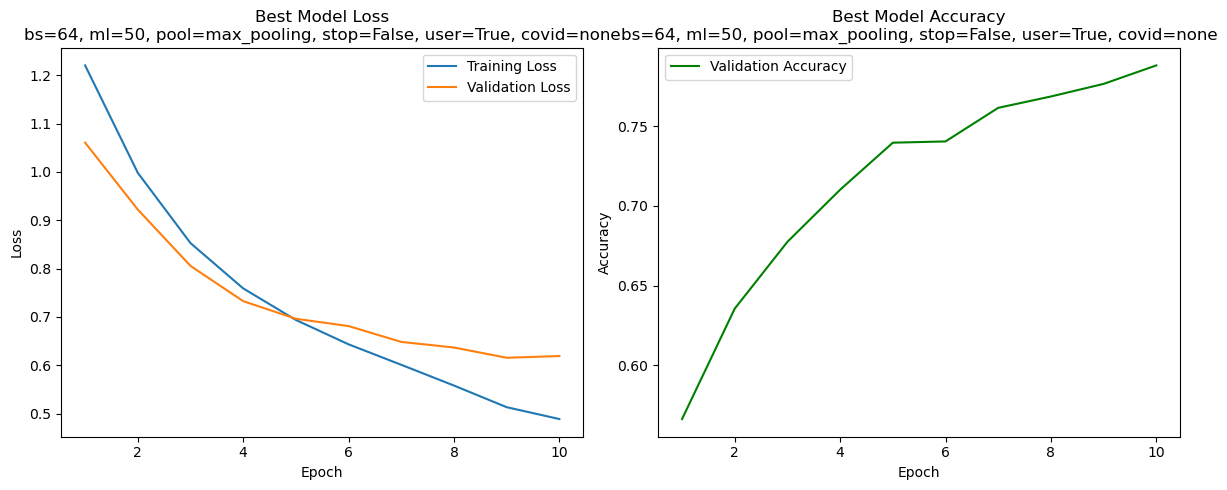

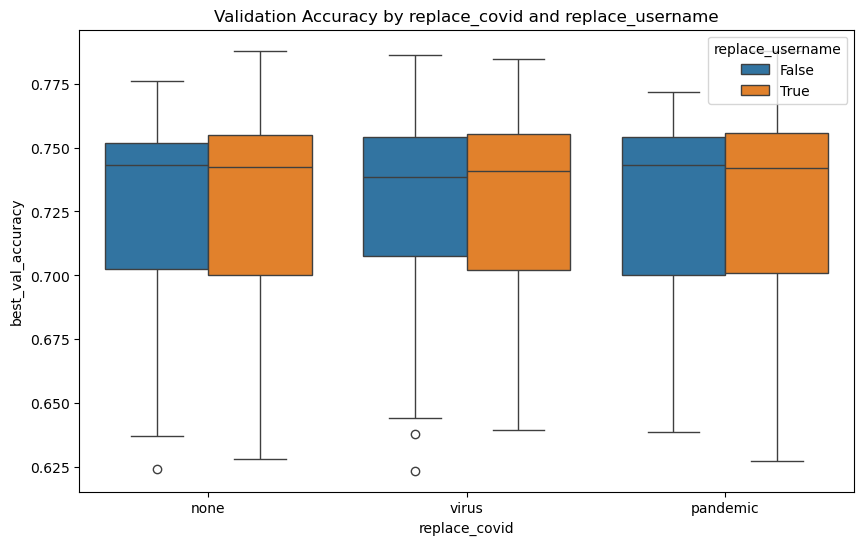

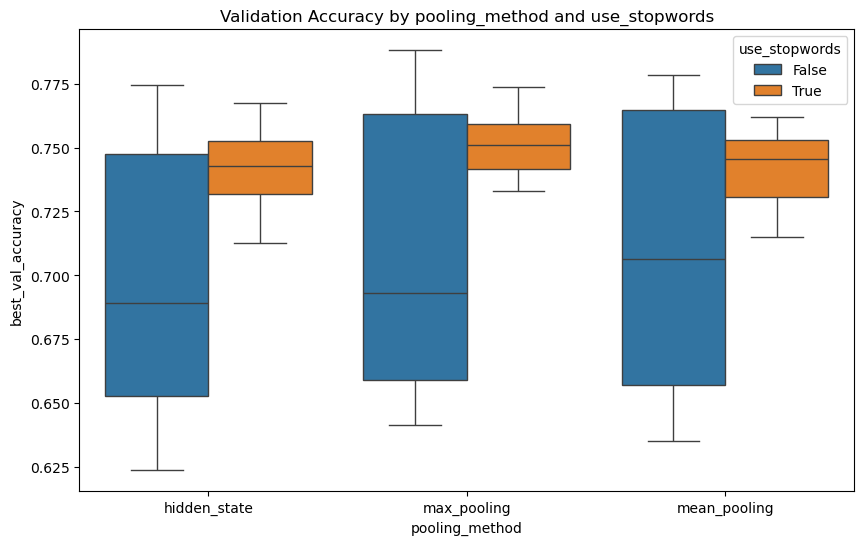

In [19]:
import seaborn as sns
# 分析影響
print("\nreplace_username 平均準確率：")
print(results_df.groupby('replace_username')['best_val_accuracy'].mean())
print("\nreplace_covid 平均準確率：")
print(results_df.groupby('replace_covid')['best_val_accuracy'].mean())
print("\npooling_method 平均準確率：")
print(results_df.groupby('pooling_method')['best_val_accuracy'].mean())

# 為最佳參數生成訓練曲線
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(best_train_losses)+1), best_train_losses, label='Training Loss')
plt.plot(range(1, len(best_val_losses)+1), best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best Model Loss\nbs={best_params["batch_size"]}, ml={best_params["max_length"]}, '
          f'pool={best_params["pooling_method"]}, stop={best_params["use_stopwords"]}, '
          f'user={best_params["replace_username"]}, covid={best_params["replace_covid"]}')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(best_val_accuracies)+1), best_val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Best Model Accuracy\nbs={best_params["batch_size"]}, ml={best_params["max_length"]}, '
          f'pool={best_params["pooling_method"]}, stop={best_params["use_stopwords"]}, '
          f'user={best_params["replace_username"]}, covid={best_params["replace_covid"]}')
plt.legend()
plt.tight_layout()
plt.savefig('best_training_curves.png')
plt.show()

# 可視化影響
plt.figure(figsize=(10, 6))
sns.boxplot(x='replace_covid', y='best_val_accuracy', hue='replace_username', data=results_df)
plt.title('Validation Accuracy by replace_covid and replace_username')
plt.savefig('accuracy_by_username_covid.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='pooling_method', y='best_val_accuracy', hue='use_stopwords', data=results_df)
plt.title('Validation Accuracy by pooling_method and use_stopwords')
plt.savefig('accuracy_by_pooling_stopwords.png')
plt.show()